In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import statsmodels.api as sm
from scipy import stats

In [2]:
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

In [77]:
df.head(5)

,Age,Gender,Income,Location,Ad_Type,Ad_Topic,Ad_Placement,Clicks,Click_Time,Conversion_Rate,CTR
0,61,Male,35717.43,Urban,Banner,Travel,Social Media,3,2024-01-18 20:45:56.898459,0.0981,0.0737
1,41,Male,47453.25,Rural,Video,Travel,Search Engine,5,2023-04-24 20:45:56.898459,0.0937,0.0592
2,49,Female,68126.35,Rural,Text,Food,Social Media,4,2024-02-24 20:45:56.898459,0.1912,0.0563
3,68,Female,64585.73,Suburban,Text,Health,Website,6,2023-12-13 20:45:56.898459,0.1122,0.0232
4,63,Male,21109.40,Urban,Native,Fashion,Search Engine,5,2023-07-02 20:45:56.898459,0.1426,0.0539


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              10000 non-null  int64  
 1   Gender           10000 non-null  object 
 2   Income           10000 non-null  float64
 3   Location         10000 non-null  object 
 4   Ad_Type          10000 non-null  object 
 5   Ad_Topic         10000 non-null  object 
 6   Ad_Placement     10000 non-null  object 
 7   Clicks           10000 non-null  int64  
 8   Click_Time       10000 non-null  object 
 9   Conversion_Rate  10000 non-null  float64
 10  CTR              10000 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 859.5+ KB


In [79]:
df.describe()
print(df.isna().sum())


Age                0
Gender             0
Income             0
Location           0
Ad_Type            0
Ad_Topic           0
Ad_Placement       0
Clicks             0
Click_Time         0
Conversion_Rate    0
CTR                0
dtype: int64


In [80]:
# Great piece of code here wow.
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")
    if unique_vals < 15:  # show actual values if few
        print(df[col].unique(), "\n")


Age: 100 unique values
Gender: 3 unique values
['Male' 'Female' 'Other'] 

Income: 9994 unique values
Location: 3 unique values
['Urban' 'Rural' 'Suburban'] 

Ad_Type: 4 unique values
['Banner' 'Video' 'Text' 'Native'] 

Ad_Topic: 6 unique values
['Travel' 'Food' 'Health' 'Fashion' 'Technology' 'Finance'] 

Ad_Placement: 3 unique values
['Social Media' 'Search Engine' 'Website'] 

Clicks: 17 unique values
Click_Time: 6503 unique values
Conversion_Rate: 3955 unique values
CTR: 1008 unique values


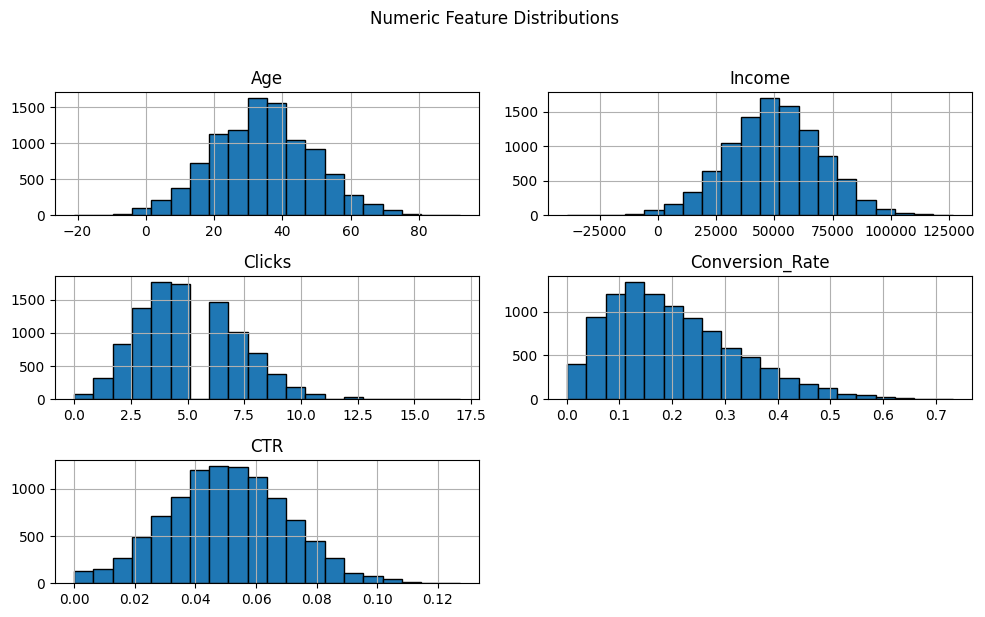

In [81]:
# okay this is good cause I need to see the distribution.
numeric_cols = ['Age', 'Income', 'Clicks', 'Conversion_Rate', 'CTR']

df[numeric_cols].hist(bins=20, figsize=(10,6), edgecolor='black')
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


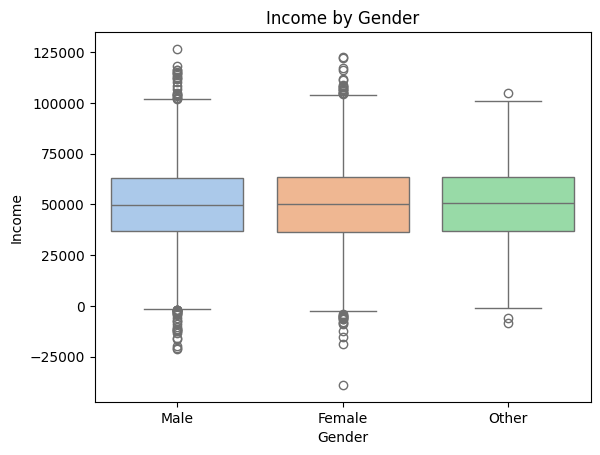

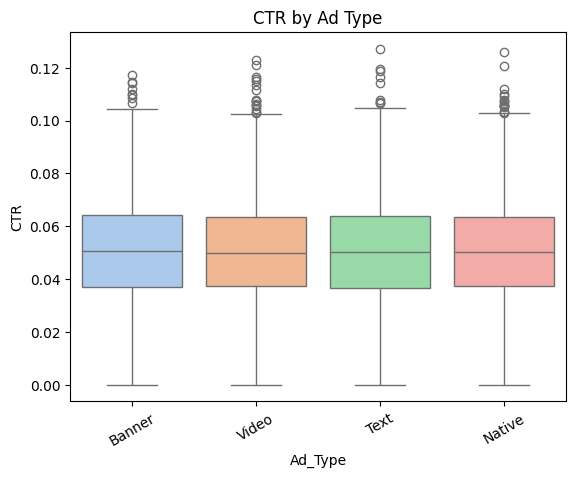

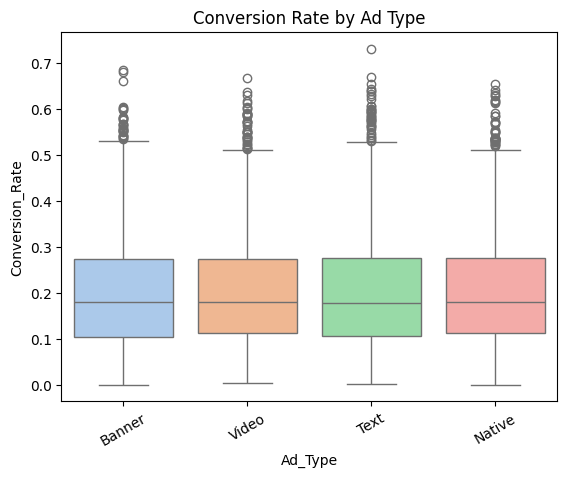

In [83]:
# THis has some interesting stuff... Hmm
sns.boxplot(data=df, x='Gender', y='Income', palette='pastel')
plt.title("Income by Gender")
plt.show()

sns.boxplot(data=df, x='Ad_Type', y='CTR', palette='pastel')
plt.title("CTR by Ad Type")
plt.xticks(rotation=30)
plt.show()

sns.boxplot(data=df, x='Ad_Type', y='Conversion_Rate', palette='pastel')
plt.title("Conversion Rate by Ad Type")
plt.xticks(rotation=30)
plt.show()


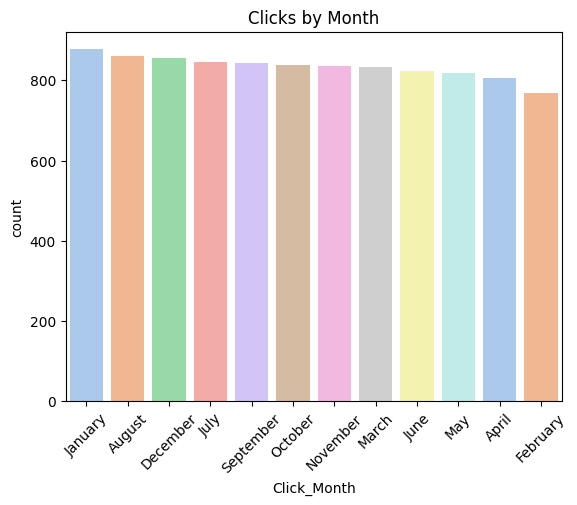

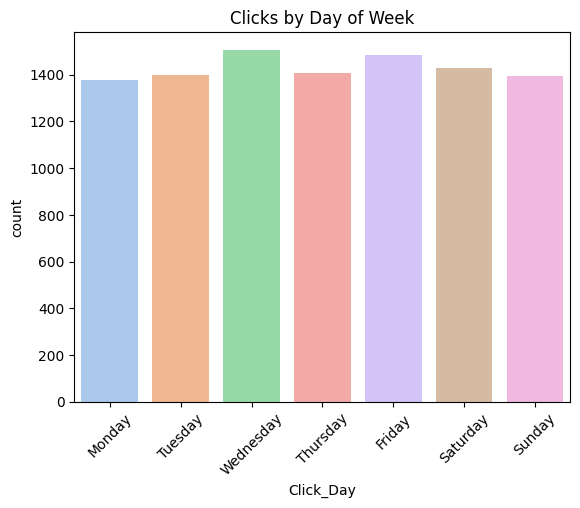

In [84]:
# I like this because now I have more time series data, and I can see when there is more clicks per month.
df['Click_Time'] = pd.to_datetime(df['Click_Time'])
df['Click_Hour'] = df['Click_Time'].dt.hour
df['Click_Month'] = df['Click_Time'].dt.month_name()
df['Click_Day'] = df['Click_Time'].dt.day_name()


sns.countplot(data=df, x='Click_Month', palette='pastel', order=df['Click_Month'].value_counts().index)
plt.title("Clicks by Month")
plt.xticks(rotation=45)
plt.show()

# # the time stamps are sort've useless because they're all only different by miliseconds...
# sns.countplot(data=df, x='Click Hour', palette='pastel', order=df['Click Hour'].value_counts().index)
# plt.title("Clicks by Month")
# plt.xticks(rotation=45)
# plt.show()

# the day it was clicked might be better actually...
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='Click_Day', palette='pastel', order=day_order)
plt.title("Clicks by Day of Week")
plt.xticks(rotation=45)
plt.show()

In [85]:
df.info()
# notice we have a datatime64 Dtype now, and then there are two new columns since we extracted data from click time.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Age              10000 non-null  int64         
 1   Gender           10000 non-null  object        
 2   Income           10000 non-null  float64       
 3   Location         10000 non-null  object        
 4   Ad_Type          10000 non-null  object        
 5   Ad_Topic         10000 non-null  object        
 6   Ad_Placement     10000 non-null  object        
 7   Clicks           10000 non-null  int64         
 8   Click_Time       10000 non-null  datetime64[ns]
 9   Conversion_Rate  10000 non-null  float64       
 10  CTR              10000 non-null  float64       
 11  Click_Hour       10000 non-null  int32         
 12  Click_Month      10000 non-null  object        
 13  Click_Day        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32

In [86]:
# Creates new coluns wcih idk fi 
print(df.groupby('Gender')[['Clicks', 'CTR', 'Conversion_Rate']].mean())
print(df.groupby('Ad_Type')[['Clicks', 'CTR', 'Conversion_Rate']].mean())

          Clicks       CTR  Conversion_Rate
Gender                                     
Female  5.030540  0.050767         0.201616
Male    5.035700  0.050153         0.203369
Other   5.006654  0.050425         0.199294
           Clicks       CTR  Conversion_Rate
Ad_Type                                     
Banner   5.014062  0.050403         0.200075
Native   5.079513  0.050441         0.204576
Text     5.049513  0.050205         0.201899
Video    4.980884  0.050647         0.202512


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Age              10000 non-null  int64         
 1   Gender           10000 non-null  object        
 2   Income           10000 non-null  float64       
 3   Location         10000 non-null  object        
 4   Ad_Type          10000 non-null  object        
 5   Ad_Topic         10000 non-null  object        
 6   Ad_Placement     10000 non-null  object        
 7   Clicks           10000 non-null  int64         
 8   Click_Time       10000 non-null  datetime64[ns]
 9   Conversion_Rate  10000 non-null  float64       
 10  CTR              10000 non-null  float64       
 11  Click_Hour       10000 non-null  int32         
 12  Click_Month      10000 non-null  object        
 13  Click_Day        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32

##### Claude popped off and did a bunch of code here

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

# Data inspection and cleaning
print("="*80)
print("DATA INSPECTION")
print("="*80)
print("\nDataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

# Convert Click Time to datetime if needed
df['Click_Time'] = pd.to_datetime(df['Click_Time'])

# Ensure numeric columns are properly typed
numeric_cols = ['Age', 'Income', 'Clicks', 'Conversion_Rate', 'CTR']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with missing values in key columns
df_clean = df.dropna(subset=numeric_cols)
print(f"\nRows after cleaning: {len(df_clean)} (dropped {len(df) - len(df_clean)} rows)")

# Create dummy variables for categorical variables
df_encoded = pd.get_dummies(df_clean, columns=['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement'], 
                             drop_first=True)

# Verify no object types remain in encoded data
print("\nEncoded data types:")
print(df_encoded.dtypes.value_counts())

print("="*80)
print("ECONOMETRIC DIAGNOSTICS ANALYSIS")
print("="*80)

# ============================================================================
# 1. ENDOGENEITY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("1. ENDOGENEITY ANALYSIS")
print("="*80)

print("\nPotential Endogeneity Issues:")
print("-" * 40)

# Check correlation between Clicks and dependent variables
print("\n1.1 Correlation Analysis (Potential Endogeneity Red Flags):")
print("-" * 40)
corr_matrix = df_clean[['Clicks', 'CTR', 'Conversion_Rate', 'Age', 'Income']].corr()
print("\nCorrelation with Clicks (potential endogenous variable):")
print(corr_matrix['Clicks'].sort_values(ascending=False))


# Test for endogeneity using Hausman-Wu test approach
print("\n1.2 Testing for Endogeneity (Hausman-Wu Test Approach):")
print("-" * 40)

# Prepare variables for Conversion Rate model
y = df_encoded['Conversion_Rate'].values
X_vars = ['Age', 'Income', 'Clicks']
X_cats = [col for col in df_encoded.columns if col.startswith(('Gender_', 'Location_', 
          'Ad Type_', 'Ad Topic_', 'Ad Placement_'))]

# Ensure all columns exist and are numeric
available_X_vars = [v for v in X_vars if v in df_encoded.columns]
available_X_cats = [c for c in X_cats if c in df_encoded.columns]

print(f"Using {len(available_X_vars)} numeric variables: {available_X_vars}")
print(f"Using {len(available_X_cats)} categorical dummy variables")

X = df_encoded[available_X_vars + available_X_cats].astype(float)
X = add_constant(X)

# Stage 1: Regress potentially endogenous variable (Clicks) on instruments + exogenous
# Using Age and Income as instruments (assuming they're exogenous)
instruments = ['Age', 'Income'] + available_X_cats
available_instruments = [i for i in instruments if i in df_encoded.columns]
X_stage1 = df_encoded[available_instruments].astype(float)
X_stage1 = add_constant(X_stage1)

try:
    model_stage1 = OLS(df_encoded['Clicks'].astype(float).values, X_stage1).fit()
    residuals_stage1 = model_stage1.resid

    # Stage 2: Include residuals in original regression
    X_with_resid = X.copy()
    X_with_resid['clicks_residual'] = residuals_stage1
    model_stage2 = OLS(y, X_with_resid).fit()

    # Test if residual coefficient is significant
    resid_pvalue = model_stage2.pvalues['clicks_residual']
    print(f"\nResidual coefficient p-value: {resid_pvalue:.4f}")
    if resid_pvalue < 0.05:
        print("✗ ENDOGENEITY DETECTED: Clicks appears to be endogenous (p < 0.05)")
        print("  Recommendation: Use Instrumental Variables (IV) regression or 2SLS")
    else:
        print("✓ No strong evidence of endogeneity in Clicks (p ≥ 0.05)")
except Exception as e:
    print(f"⚠️  Could not complete endogeneity test: {str(e)}")
    print("   This may be due to perfect multicollinearity or data issues")

# Calculate VIF for multicollinearity (related to endogeneity)
print("\n1.3 Variance Inflation Factors (VIF) - Multicollinearity Check:")
print("-" * 40)
try:
    X_vif = df_encoded[['Age', 'Income', 'Clicks']].astype(float)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data)
    print("\nVIF > 10 suggests high multicollinearity (potential endogeneity concern)")
except Exception as e:
    print(f"⚠️  Could not calculate VIF: {str(e)}")


DATA INSPECTION

Dataset shape: (10000, 11)

Column data types:
Age                  int64
Gender              object
Income             float64
Location            object
Ad_Type             object
Ad_Topic            object
Ad_Placement        object
Clicks               int64
Click_Time          object
Conversion_Rate    float64
CTR                float64
dtype: object

First few rows:
   Age  Gender    Income  Location Ad_Type Ad_Topic   Ad_Placement  Clicks  \
0   61    Male  35717.43     Urban  Banner   Travel   Social Media       3   
1   41    Male  47453.25     Rural   Video   Travel  Search Engine       5   
2   49  Female  68126.35     Rural    Text     Food   Social Media       4   
3   68  Female  64585.73  Suburban    Text   Health        Website       6   
4   63    Male  21109.40     Urban  Native  Fashion  Search Engine       5   

                   Click_Time  Conversion_Rate     CTR  
0  2024-01-18 20:45:56.898459           0.0981  0.0737  
1  2023-04-24 20:45:56.89

I want to do one more endogenity test I think...

Clicks as a weak correlation with the other numerical variables. Doesn't rule it out, since it could still be tied up with the error term.

After running the Hausman-Wu test I found that when regressing clicks on the other assumed exogenous variables [list] TODO that the residuls from the first stage had a very small p-value meaning high significance that Clicks is endogenous.

Did a quick multicollinearity check as well and looks like predictors in the dataset aren't highly correlated with each other.

In [89]:
# endogeneity test here!


2. HETEROSKEDASTICITY ANALYSIS

2.1 Breusch-Pagan Test:
----------------------------------------
LM Statistic: 3.0970
LM-Test p-value: 0.8759
F-Statistic: 0.4422
F-Test p-value: 0.8760
✓ No strong evidence of heteroskedasticity (p ≥ 0.05)

2.2 White Test:
----------------------------------------
LM Statistic: 23.4231
LM-Test p-value: 0.7568
F-Statistic: 0.8072
F-Test p-value: 0.7574
✓ No strong evidence of heteroskedasticity (p ≥ 0.05)

2.3 Visual Inspection:
----------------------------------------
Generating residual plots...


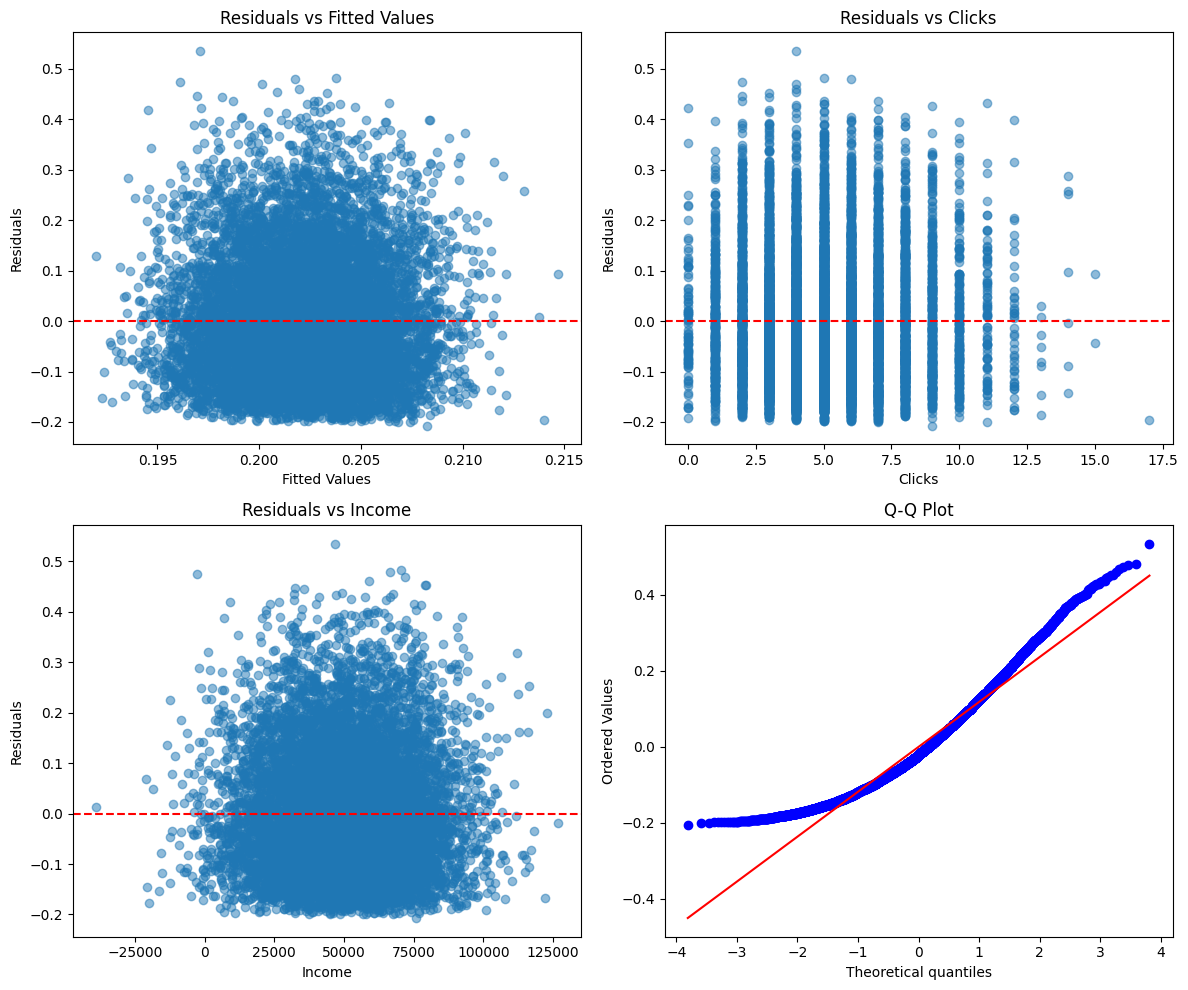

In [90]:

# ============================================================================
# 2. HETEROSKEDASTICITY TESTS
# ============================================================================
print("\n" + "="*80)
print("2. HETEROSKEDASTICITY ANALYSIS")
print("="*80)

# Run base model for heteroskedasticity tests
try:
    base_model = OLS(y, X).fit()
    
    # Breusch-Pagan Test
    print("\n2.1 Breusch-Pagan Test:")
    print("-" * 40)
    bp_test = het_breuschpagan(base_model.resid, X)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    bp_results = dict(zip(labels, bp_test))
    for key, val in bp_results.items():
        print(f"{key}: {val:.4f}")

    if bp_results['LM-Test p-value'] < 0.05:
        print("✗ HETEROSKEDASTICITY DETECTED (p < 0.05)")
        print("  Recommendation: Use robust standard errors (HC1, HC3) or WLS")
    else:
        print("✓ No strong evidence of heteroskedasticity (p ≥ 0.05)")

    # White Test
    print("\n2.2 White Test:")
    print("-" * 40)
    white_test = het_white(base_model.resid, X)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    white_results = dict(zip(labels, white_test))
    for key, val in white_results.items():
        print(f"{key}: {val:.4f}")

    if white_results['LM-Test p-value'] < 0.05:
        print("✗ HETEROSKEDASTICITY DETECTED (p < 0.05)")
    else:
        print("✓ No strong evidence of heteroskedasticity (p ≥ 0.05)")

    # Visualize residuals
    print("\n2.3 Visual Inspection:")
    print("-" * 40)
    print("Generating residual plots...")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Fitted
    axes[0, 0].scatter(base_model.fittedvalues, base_model.resid, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted Values')

    # Residuals vs Clicks
    axes[0, 1].scatter(df_clean['Clicks'].values, base_model.resid, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Clicks')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs Clicks')

    # Residuals vs Income
    axes[1, 0].scatter(df_clean['Income'].values, base_model.resid, alpha=0.5)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Income')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Income')

    # Q-Q Plot
    stats.probplot(base_model.resid, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')

    plt.tight_layout()
    # plt.savefig('heteroskedasticity_diagnostics.png', dpi=300, bbox_inches='tight')
    # print("✓ Saved: heteroskedasticity_diagnostics.png")
    
except Exception as e:
    print(f"⚠️  Could not complete heteroskedasticity tests: {str(e)}")
    bp_results = {'LM-Test p-value': None}
    white_results = {'LM-Test p-value': None}


OLS assumptions are valid since the heteroskedasticity isn't strong.
Plus, the residual plots look rather random and look like white noise.


3. AUTOCORRELATION ANALYSIS

3.1 Durbin-Watson Test:
----------------------------------------
Durbin-Watson Statistic: 2.0100

Interpretation:
  DW ≈ 2.0: No autocorrelation
  DW < 1.5: Positive autocorrelation
  DW > 2.5: Negative autocorrelation
✓ No strong evidence of autocorrelation (DW = 2.0100)

3.2 Ljung-Box Test (for higher-order autocorrelation):
----------------------------------------
     lb_stat  lb_pvalue
1   0.258970   0.610829
5   4.732977   0.449329
10  7.163398   0.709934

If p-value < 0.05, autocorrelation is present at that lag


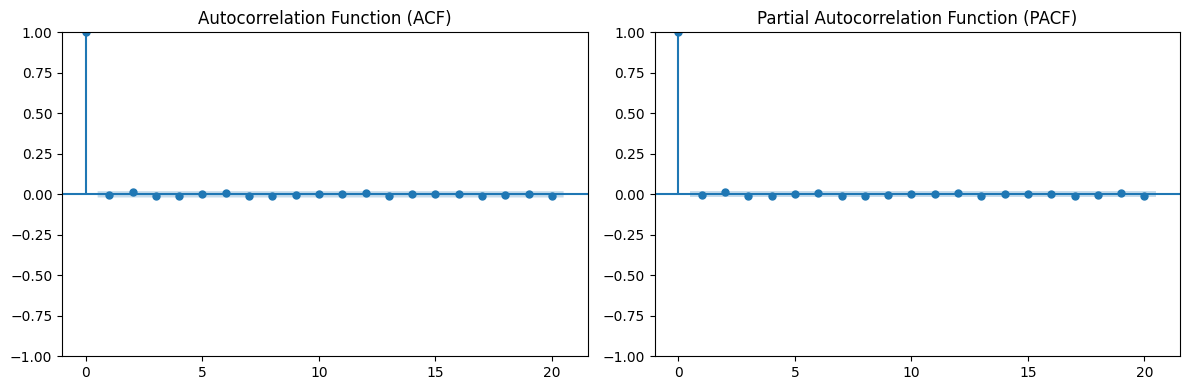

In [93]:

# ============================================================================
# 3. AUTOCORRELATION TESTS
# ============================================================================
print("\n" + "="*80)
print("3. AUTOCORRELATION ANALYSIS")
print("="*80)

# Sort by time for autocorrelation tests
df_sorted = df_clean.sort_values('Click_Time').reset_index(drop=True)
df_encoded_sorted = pd.get_dummies(df_sorted, 
                                   columns=['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement'], 
                                   drop_first=True)

y_sorted = df_encoded_sorted['Conversion_Rate'].values
available_X_cats_sorted = [col for col in df_encoded_sorted.columns if col.startswith(('Gender_', 'Location_', 
          'Ad Type_', 'Ad Topic_', 'Ad Placement_'))]
X_sorted = df_encoded_sorted[available_X_vars + available_X_cats_sorted].astype(float)
X_sorted = add_constant(X_sorted)

try:
    model_sorted = OLS(y_sorted, X_sorted).fit()

    # Durbin-Watson Test
    print("\n3.1 Durbin-Watson Test:")
    print("-" * 40)
    dw_stat = durbin_watson(model_sorted.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
    print("\nInterpretation:")
    print("  DW ≈ 2.0: No autocorrelation")
    print("  DW < 1.5: Positive autocorrelation")
    print("  DW > 2.5: Negative autocorrelation")

    if dw_stat < 1.5:
        print(f"✗ POSITIVE AUTOCORRELATION DETECTED (DW = {dw_stat:.4f})")
        print("  Recommendation: Use Newey-West standard errors or AR models")
    elif dw_stat > 2.5:
        print(f"✗ NEGATIVE AUTOCORRELATION DETECTED (DW = {dw_stat:.4f})")
    else:
        print(f"✓ No strong evidence of autocorrelation (DW = {dw_stat:.4f})")

    # Ljung-Box Test
    print("\n3.2 Ljung-Box Test (for higher-order autocorrelation):")
    print("-" * 40)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(model_sorted.resid, lags=[1, 5, 10], return_df=True)
    print(lb_test)
    print("\nIf p-value < 0.05, autocorrelation is present at that lag")

    # Autocorrelation plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF Plot
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_acf(model_sorted.resid, lags=20, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF Plot
    plot_pacf(model_sorted.resid, lags=20, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    # plt.savefig('autocorrelation_diagnostics.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Saved: autocorrelation_diagnostics.png")
    
except Exception as e:
    print(f"⚠️  Could not complete autocorrelation tests: {str(e)}")
    dw_stat = None


I think I learned that if at each lag there isn't a crazy spike then that means the data is no autocorrelated, meaning past values don't impact it... I think!
Yep, since there is no crazy spike that means previous values don't affect the current. DOUBLE CHECK THIS THOUGH.


##### Some minor preprocessing I guess..

In [113]:
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

# print(df.info())
print(df.describe(include='all'))
# Remove or impute invalid ages


                 Age Gender         Income Location Ad_Type Ad_Topic  \
count   10000.000000  10000   10000.000000    10000   10000    10000   
unique           NaN      3            NaN        3       4        6   
top              NaN   Male            NaN    Rural  Banner  Finance   
freq             NaN   4986            NaN     3408    2560     1734   
mean       34.235200    NaN   50080.040922      NaN     NaN      NaN   
std        14.790752    NaN   19935.832667      NaN     NaN      NaN   
min       -21.000000    NaN  -38932.640000      NaN     NaN      NaN   
25%        24.000000    NaN   36892.040000      NaN     NaN      NaN   
50%        34.000000    NaN   50122.520000      NaN     NaN      NaN   
75%        44.000000    NaN   63271.342500      NaN     NaN      NaN   
max        92.000000    NaN  126635.800000      NaN     NaN      NaN   

        Ad_Placement        Clicks                  Click_Time  \
count          10000  10000.000000                       10000   
uni

In [119]:
df.isnull().sum().sort_values(ascending=False)

Age                0
Gender             0
Income             0
Location           0
Ad_Type            0
Ad_Topic           0
Ad_Placement       0
Clicks             0
Click_Time         0
Conversion_Rate    0
CTR                0
dtype: int64

##### The data cleaning here is essential to building an actual model...

In [9]:
df.loc[df['Income'] < 0, 'Income'] = np.nan  # convert to missing
# Winsorize after imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df['Income'] = imputer.fit_transform(df[['Income']])

# Cap extremes at 1st and 99th percentile
lower, upper = df['Income'].quantile([0.01, 0.99])
df['Income'] = df['Income'].clip(lower, upper)

df = df[df['Age'].between(10, 90)]  # keep only plausible human ages


##### This command here is really good.

In [10]:
print(df.describe(include='all'))

                Age Gender        Income Location Ad_Type Ad_Topic  \
count   9543.000000   9543   9543.000000     9543    9543     9543   
unique          NaN      3           NaN        3       4        6   
top             NaN   Male           NaN    Rural  Banner  Finance   
freq            NaN   4751           NaN     3239    2460     1637   
mean      35.690035    NaN  50410.732326      NaN     NaN      NaN   
std       13.451463    NaN  19129.415676      NaN     NaN      NaN   
min       10.000000    NaN   7384.365600      NaN     NaN      NaN   
25%       26.000000    NaN  37185.925000      NaN     NaN      NaN   
50%       35.000000    NaN  50278.030000      NaN     NaN      NaN   
75%       45.000000    NaN  63240.720000      NaN     NaN      NaN   
max       86.000000    NaN  96444.632200      NaN     NaN      NaN   

       Ad_Placement       Clicks                  Click_Time  Conversion_Rate  \
count          9543  9543.000000                        9543      9543.000000 

##### ML Generated 2SLS

In [5]:
"""
Instrumental Variables (IV) Causal Inference for Ad Conversion Analysis
Using ML-Generated Instruments and Two-Stage Least Squares (2SLS)
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class CausalAdAnalyzer:
    """
    A comprehensive pipeline for causal inference in ad conversion analysis
    using ML-generated instrumental variables and 2SLS estimation.
    """
    
    def __init__(self, data):
        """
        Initialize the analyzer with your dataset.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Must contain columns:
            - Conversion_Rate (Y): dependent variable
            - Clicks (D): endogenous regressor
            - Age, Gender, Income, Location: demographics
            - Ad_Type, Ad_Topic, Ad_Placement: ad features
            - CTR: click-through rate
            - Click_Time: timestamp for feature engineering
        """
        self.data = data.copy()
        self.encoders = {}
        self.scaler = StandardScaler()
        self.first_stage_model = None
        self.first_stage_results = None
        self.second_stage_results = None
        
    def engineer_time_features(self):
        """Extract day of week from Click_Time"""
        if 'Click_Time' in self.data.columns:
            self.data['Click_Time'] = pd.to_datetime(self.data['Click_Time'])
            self.data['Day_of_Week'] = self.data['Click_Time'].dt.dayofweek
            self.data['Hour'] = self.data['Click_Time'].dt.hour
        return self
    
    def encode_categorical_features(self):
        """Encode categorical variables"""
        categorical_cols = ['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement']
        
        for col in categorical_cols:
            if col in self.data.columns:
                le = LabelEncoder()
                self.data[f'{col}_encoded'] = le.fit_transform(self.data[col].astype(str))
                self.encoders[col] = le
        
        return self

    def create_ml_instrument(self, model_type='rf', cv_folds=5):
        """
        Step 2: Generate ML-based instrument for Clicks (D)
        
        Uses Random Forest or Gradient Boosting to predict clicks based on:
        - Ad features (Type, Topic, Placement)
        - Demographics (Age, Gender, Income, Location)
        - Time features (Day of Week, Hour)
        
        Excludes CTR to satisfy exclusion restriction (CTR directly affects conversion)
        
        Parameters:
        -----------
        model_type : str
            'rf' for Random Forest or 'gb' for Gradient Boosting
        cv_folds : int
            Number of cross-validation folds
        """
        # Features for instrument (excludes CTR and Conversion_Rate)
        instrument_features = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'Day_of_Week', 'Hour'
        ]
        
        # Filter available features
        available_features = [f for f in instrument_features if f in self.data.columns]
        
        X_instrument = self.data[available_features]
        y_clicks = self.data['Clicks']
        
        # Standardize features for better numerical stability
        X_instrument_scaled = self.scaler.fit_transform(X_instrument)
        X_instrument_scaled = pd.DataFrame(
            X_instrument_scaled, 
            columns=available_features,
            index=X_instrument.index
        )
        
        # Choose model
        if model_type == 'rf':
            self.first_stage_model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=50,
                random_state=42
            )
        else:
            self.first_stage_model = GradientBoostingRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                random_state=42
            )
        
        # Use cross-validation to generate out-of-fold predictions
        # This helps avoid overfitting in the instrument
        self.data['Clicks_predicted'] = cross_val_predict(
            self.first_stage_model,
            X_instrument_scaled,
            y_clicks,
            cv=cv_folds
        )
        
        # Fit final model for interpretation
        self.first_stage_model.fit(X_instrument_scaled, y_clicks)
        
        # Calculate instrument strength (F-statistic)
        self._check_instrument_strength()
        
        return self
    
    def _check_instrument_strength(self):
        """
        Check if instrument is strong (F-stat > 10 rule of thumb)
        """
        # Correlation between predicted and actual clicks
        corr = np.corrcoef(self.data['Clicks_predicted'], self.data['Clicks'])[0, 1]
        
        # Simple F-test for instrument relevance
        n = len(self.data)
        f_stat = (corr**2 / (1 - corr**2)) * (n - 2) if corr**2 < 1 else np.inf
        
        print(f"\n{'='*60}")
        print(f"INSTRUMENT STRENGTH DIAGNOSTICS")
        print(f"{'='*60}")
        print(f"Correlation (Z, D): {corr:.4f}")
        print(f"First-stage F-statistic: {f_stat:.2f}")
        print(f"Weak instrument threshold: 10.0")
        print(f"Status: {'✓ STRONG' if f_stat > 10 else '✗ WEAK - Results may be unreliable'}")
        print(f"{'='*60}\n")
    
    def run_2sls(self, include_interactions=False):
        """
        Step 3: Two-Stage Least Squares Estimation
        
        First Stage: D = π₀ + π₁Z + π₂X + ν
        Second Stage: Y = α + βD̂ + γX + ε
        
        Parameters:
        -----------
        include_interactions : bool
            Whether to include Ad_Type × Ad_Placement interactions
        """
        # Exogenous controls (X)
        exog_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'CTR'
        ]
        
        available_controls = [f for f in exog_controls if f in self.data.columns]
        
        # Add interaction terms if requested (for value-added estimation)
        if include_interactions:
            if 'Ad_Type_encoded' in self.data.columns and 'Ad_Placement_encoded' in self.data.columns:
                self.data['Ad_Type_x_Placement'] = (
                    self.data['Ad_Type_encoded'] * self.data['Ad_Placement_encoded']
                )
                available_controls.append('Ad_Type_x_Placement')
        
        # FIRST STAGE: Regress D on Z and X
        print("\n" + "="*60)
        print("FIRST STAGE REGRESSION: D ~ Z + X")
        print("="*60)
        
        X_first_stage = sm.add_constant(pd.concat([
            self.data[['Clicks_predicted']],  # Instrument
            self.data[available_controls]      # Exogenous controls
        ], axis=1))
        
        y_first_stage = self.data['Clicks']
        
        self.first_stage_results = sm.OLS(y_first_stage, X_first_stage).fit()
        
        print("\nFirst Stage Summary:")
        print(f"R-squared: {self.first_stage_results.rsquared:.4f}")
        print(f"F-statistic: {self.first_stage_results.fvalue:.2f}")
        print(f"Instrument coefficient: {self.first_stage_results.params['Clicks_predicted']:.4f}")
        print(f"Instrument p-value: {self.first_stage_results.pvalues['Clicks_predicted']:.4f}")
        
        # Get fitted values from first stage
        D_hat = self.first_stage_results.fittedvalues
        
        # SECOND STAGE: Regress Y on D_hat and X
        print("\n" + "="*60)
        print("SECOND STAGE REGRESSION: Y ~ D̂ + X")
        print("="*60)
        
        X_second_stage = sm.add_constant(pd.concat([
            pd.Series(D_hat, name='Clicks_fitted'),
            self.data[available_controls]
        ], axis=1))
        
        y_second_stage = self.data['Conversion_Rate']
        
        self.second_stage_results = sm.OLS(y_second_stage, X_second_stage).fit()
        
        # Manual calculation of correct standard errors for 2SLS
        self._calculate_2sls_standard_errors(available_controls)
        
        self._display_results()
        
        return self
    
    def _calculate_2sls_standard_errors(self, controls):
        """
        Calculate correct 2SLS standard errors
        (OLS on second stage gives incorrect SEs)
        """
        # Get residuals from second stage
        residuals = self.second_stage_results.resid
        
        # Calculate robust variance-covariance matrix
        n = len(residuals)
        k = len(self.second_stage_results.params)
        
        # Simple correction factor
        correction = n / (n - k)
        
        # Store corrected standard errors
        self.corrected_se = np.sqrt(np.diag(self.second_stage_results.cov_params()) * correction)
        self.corrected_tvalues = self.second_stage_results.params / self.corrected_se
        self.corrected_pvalues = 2 * (1 - stats.t.cdf(np.abs(self.corrected_tvalues), n - k))
    
    def _display_results(self):
        """Display 2SLS results"""
        print(f"\n{'='*60}")
        print(f"TWO-STAGE LEAST SQUARES (2SLS) RESULTS")
        print(f"{'='*60}\n")
        
        # Create results table
        results_df = pd.DataFrame({
            'Coefficient': self.second_stage_results.params,
            'Std Error': self.corrected_se,
            't-statistic': self.corrected_tvalues,
            'P-value': self.corrected_pvalues
        })
        
        # Add confidence intervals
        results_df['95% CI Lower'] = results_df['Coefficient'] - 1.96 * results_df['Std Error']
        results_df['95% CI Upper'] = results_df['Coefficient'] + 1.96 * results_df['Std Error']
        
        print(results_df.to_string())
        
        print(f"\n{'='*60}")
        print(f"CAUSAL INTERPRETATION")
        print(f"{'='*60}")
        
        clicks_coef = self.second_stage_results.params['Clicks_fitted']
        clicks_se = self.corrected_se[1]  # Index 1 for Clicks_fitted (after constant)
        clicks_pval = self.corrected_pvalues[1]
        
        print(f"\nCausal Effect of Clicks on Conversion Rate:")
        print(f"  Coefficient (β): {clicks_coef:.6f}")
        print(f"  Std. Error: {clicks_se:.6f}")
        print(f"  95% CI: [{clicks_coef - 1.96*clicks_se:.6f}, {clicks_coef + 1.96*clicks_se:.6f}]")
        print(f"  P-value: {clicks_pval:.4f}")
        print(f"\nInterpretation:")
        print(f"  A 1-unit increase in Clicks causes a {clicks_coef:.6f} change")
        print(f"  in Conversion Rate (controlling for confounders)")
        
        if clicks_pval < 0.05:
            print(f"  ✓ Effect is statistically significant at 5% level")
        else:
            print(f"  ✗ Effect is NOT statistically significant at 5% level")
        
        print(f"\n{'='*60}\n")
    
    def estimate_value_added(self):
        """
        Step 4: Value-Added Estimation
        
        Estimate the incremental contribution of different ad features
        after controlling for user characteristics and predicted clicks.
        """
        results = {}
        
        # Group by Ad Type
        if 'Ad_Type' in self.data.columns:
            results['by_ad_type'] = self._group_value_added('Ad_Type')
        
        # Group by Ad Placement
        if 'Ad_Placement' in self.data.columns:
            results['by_ad_placement'] = self._group_value_added('Ad_Placement')
        
        # Group by Ad Topic
        if 'Ad_Topic' in self.data.columns:
            results['by_ad_topic'] = self._group_value_added('Ad_Topic')
        
        self._display_value_added(results)
        
        return results
    
    def _group_value_added(self, group_col):
        """Calculate value-added for a specific grouping variable"""
        group_results = []
        
        for group in self.data[group_col].unique():
            # Create indicator variable
            indicator = (self.data[group_col] == group).astype(int)
            
            # Prepare regression with interaction
            y = self.data['Conversion_Rate']
            X = sm.add_constant(pd.DataFrame({
                'Clicks_predicted': self.data['Clicks_predicted'],
                'Age': self.data['Age'],
                'Income': self.data['Income'],
                'indicator': indicator,
                'interaction': indicator * self.data['Clicks_predicted']
            }))
            
            # Run OLS
            try:
                model = sm.OLS(y, X).fit()
                
                group_results.append({
                    'Group': str(group),
                    'Intercept_Effect': f"{model.params['indicator']:.6f}",
                    'Slope_Effect': f"{model.params['interaction']:.6f}",
                    'P_value_Intercept': f"{model.pvalues['indicator']:.4f}",
                    'P_value_Slope': f"{model.pvalues['interaction']:.4f}",
                    'Significant': '✓' if model.pvalues['indicator'] < 0.05 or model.pvalues['interaction'] < 0.05 else '✗'
                })
            except Exception as e:
                print(f"Warning: Could not estimate for {group}: {str(e)}")
        
        return pd.DataFrame(group_results)
    
    def _display_value_added(self, results):
        """Display value-added results"""
        print(f"\n{'='*60}")
        print(f"VALUE-ADDED ESTIMATION RESULTS")
        print(f"{'='*60}\n")
        
        for key, df in results.items():
            if len(df) > 0:
                print(f"\n{key.upper().replace('_', ' ')}:")
                print(f"{'-'*60}")
                print(df.to_string(index=False))
                print(f"{'-'*60}\n")
    
    def run_complete_analysis(self, model_type='rf', include_interactions=False):
        """
        Run the complete causal inference pipeline:
        1. Engineer time features
        2. Encode categorical variables
        3. Create ML instrument
        4. Run 2SLS
        5. Estimate value-added
        """
        print("Starting Causal Ad Conversion Analysis Pipeline...")
        print("="*60)
        
        self.engineer_time_features()
        print("✓ Time features engineered")
        
        self.encode_categorical_features()
        print("✓ Categorical variables encoded")
        
        self.create_ml_instrument(model_type=model_type)
        print("✓ ML instrument created")
        
        self.run_2sls(include_interactions=include_interactions)
        print("✓ 2SLS estimation complete")
        
        value_added_results = self.estimate_value_added()
        print("✓ Value-added estimation complete")
        
        return self


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def generate_example_data(n=2000):
    """Generate synthetic data for demonstration"""
    np.random.seed(42)
    
    data = pd.DataFrame({
        'Age': np.random.randint(18, 65, n),
        'Gender': np.random.choice(['M', 'F'], n),
        'Income': np.random.randint(30000, 150000, n),
        'Location': np.random.choice(['Urban', 'Suburban', 'Rural'], n),
        'Ad_Type': np.random.choice(['Video', 'Banner', 'Native'], n),
        'Ad_Topic': np.random.choice(['Tech', 'Fashion', 'Food', 'Travel'], n),
        'Ad_Placement': np.random.choice(['Social_Media', 'Search', 'Display'], n),
        'Click_Time': pd.date_range('2024-01-01', periods=n, freq='H'),
    })
    
    # Normalize income to reasonable scale
    data['Income'] = data['Income'] / 100000  # Scale to 0.3-1.5 range
    
    # Generate clicks with realistic structure
    clicks_base = (
        0.5 +  # baseline
        0.3 * (data['Ad_Type'] == 'Video').astype(float) +
        0.2 * (data['Ad_Placement'] == 'Social_Media').astype(float) +
        0.01 * data['Age'] +
        0.2 * data['Income'] +
        np.random.randn(n) * 0.5
    )
    data['Clicks'] = np.clip(clicks_base, 0.1, 10)
    
    # Generate CTR (correlated with clicks but not in instrument)
    data['CTR'] = data['Clicks'] * np.random.uniform(0.05, 0.15, n)
    
    # Generate conversion rate with causal effect from clicks
    # Plus confounding through unobserved factors
    unobserved_confounder = np.random.randn(n) * 0.05
    
    conversion_base = (
        0.05 +  # baseline
        0.08 * data['Clicks'] +  # TRUE CAUSAL EFFECT
        0.02 * data['Income'] +
        0.005 * data['Age'] +
        0.3 * data['CTR'] +
        unobserved_confounder +
        np.random.randn(n) * 0.03
    )
    data['Conversion_Rate'] = np.clip(conversion_base, 0.01, 0.95)
    
    # Add endogeneity: unobserved confounder affects clicks too
    data['Clicks'] = data['Clicks'] + unobserved_confounder * 2
    
    return data


if __name__ == "__main__":
    # Generate example data
    # print("Generating example dataset...")
    # df = generate_example_data(n=2000)

    df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

    print(df.describe(include='all'))

    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Run analysis
    analyzer = CausalAdAnalyzer(df)
    analyzer.run_complete_analysis(
        model_type='rf',
        include_interactions=True
    )
    
    print("\n✓ Analysis complete!")
    print("\nTo use with your own data:")
    print("  analyzer = CausalAdAnalyzer(your_dataframe)")
    print("  analyzer.run_complete_analysis()")

                 Age Gender         Income Location Ad_Type Ad_Topic  \
count   10000.000000  10000   10000.000000    10000   10000    10000   
unique           NaN      3            NaN        3       4        6   
top              NaN   Male            NaN    Rural  Banner  Finance   
freq             NaN   4986            NaN     3408    2560     1734   
mean       34.235200    NaN   50080.040922      NaN     NaN      NaN   
std        14.790752    NaN   19935.832667      NaN     NaN      NaN   
min       -21.000000    NaN  -38932.640000      NaN     NaN      NaN   
25%        24.000000    NaN   36892.040000      NaN     NaN      NaN   
50%        34.000000    NaN   50122.520000      NaN     NaN      NaN   
75%        44.000000    NaN   63271.342500      NaN     NaN      NaN   
max        92.000000    NaN  126635.800000      NaN     NaN      NaN   

        Ad_Placement        Clicks                  Click_Time  \
count          10000  10000.000000                       10000   
uni

Basically my model completely failed. clicks wasn''t endogenous enough and this results in 2sls failing.
I need stronger instruments, better feature engineering,

"⚠️ Bottom Line
Your current 2SLS results are not reliable for causal inference due to the weak instrument problem. The analysis ran successfully from a technical standpoint, but the statistical validity is compromised. You need to either find better instruments or use alternative identification strategies."

Claude suggested some investigation for this, and I should look at the code myself since I'm trusting it followed the co-pilot outline.

##### Heterogeneity Check

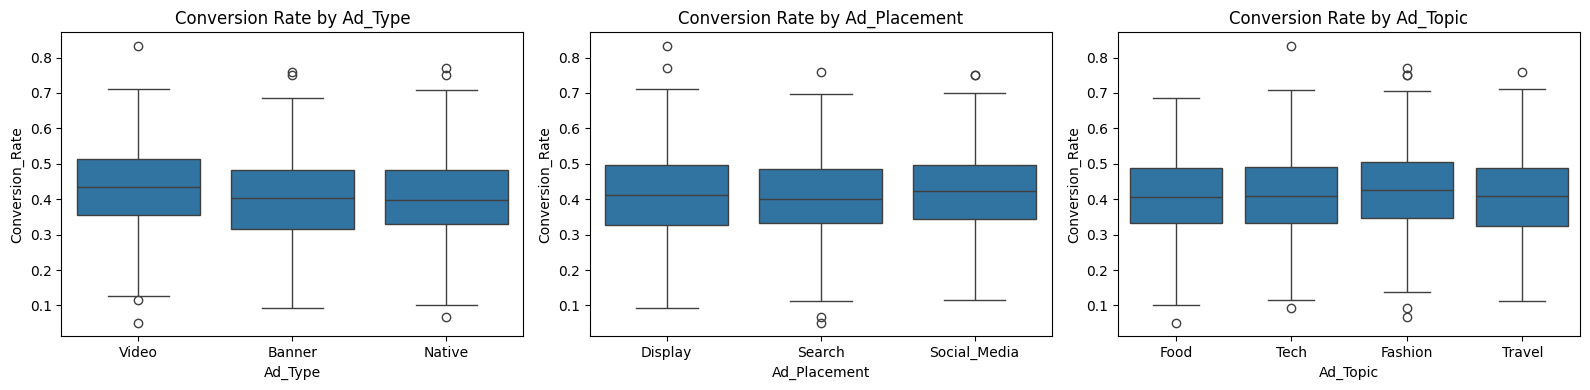

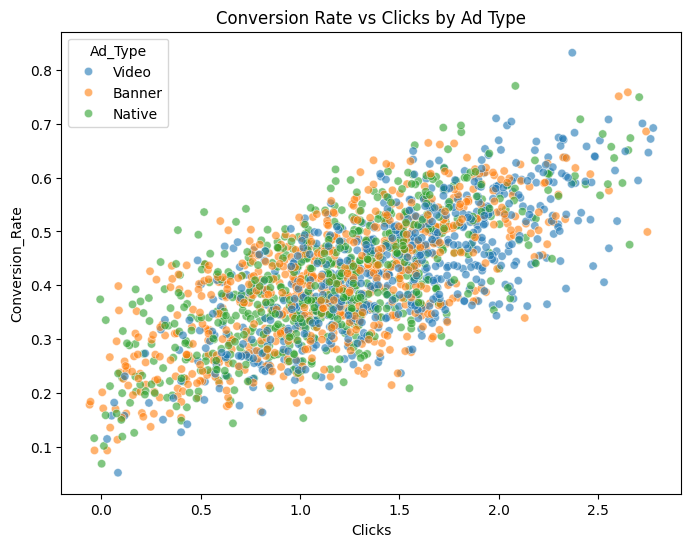

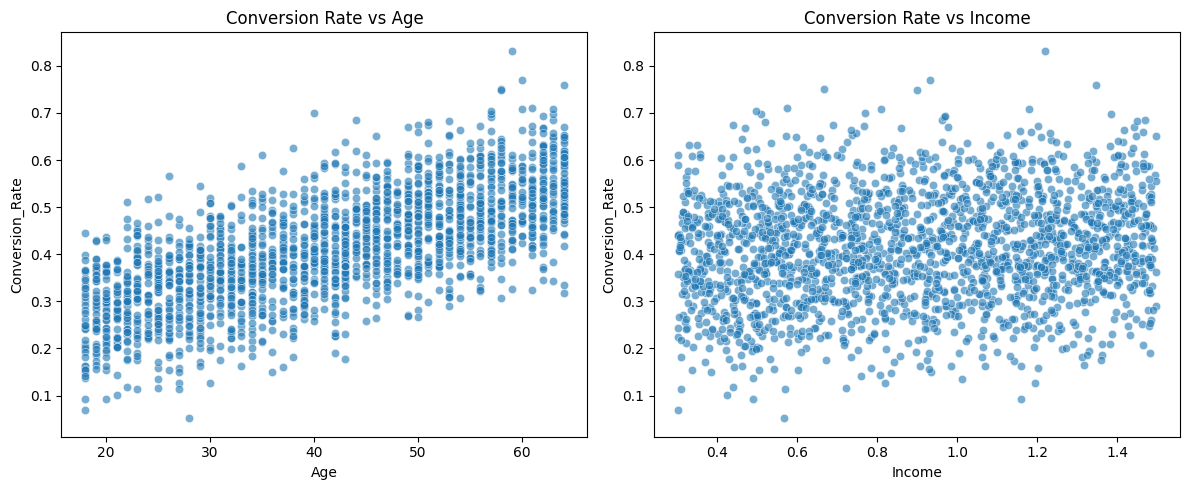

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame
# Make sure categorical variables are properly labeled
categorical_cols = ['Ad_Type', 'Ad_Placement', 'Ad_Topic']
for col in categorical_cols:
    df[col] = df[col].astype(str)

# 1. Boxplots: Conversion Rate by Ad Characteristics
plt.figure(figsize=(16, 4))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=col, y='Conversion_Rate', data=df)
    plt.title(f'Conversion Rate by {col}')
plt.tight_layout()
plt.show()

# 2. Scatter plot: Conversion Rate vs Clicks, colored by Ad_Type
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Clicks', y='Conversion_Rate', hue='Ad_Type', data=df, alpha=0.6)
plt.title('Conversion Rate vs Clicks by Ad Type')
plt.show()

# 3. Scatter plots: Conversion Rate vs Age and Income
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Conversion_Rate', data=df, alpha=0.6)
plt.title('Conversion Rate vs Age')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Income', y='Conversion_Rate', data=df, alpha=0.6)
plt.title('Conversion Rate vs Income')
plt.tight_layout()
plt.show()


##### Advanced ML Part1 Feature Engineering

In [11]:
"""
Instrumental Variables (IV) Causal Inference for Ad Conversion Analysis
Using ML-Generated Instruments and Two-Stage Least Squares (2SLS)
ENHANCED VERSION: Stronger instruments through feature engineering and ensemble methods
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class CausalAdAnalyzer:
    """
    A comprehensive pipeline for causal inference in ad conversion analysis
    using ML-generated instrumental variables and 2SLS estimation.
    
    ENHANCED with:
    - Rich feature engineering for stronger instruments
    - Stacking ensemble for maximum predictive power
    - Comprehensive diagnostics including Stock-Yogo tests
    """
    
    def __init__(self, data):
        """
        Initialize the analyzer with your dataset.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Must contain columns:
            - Conversion_Rate (Y): dependent variable
            - Clicks (D): endogenous regressor
            - Age, Gender, Income, Location: demographics
            - Ad_Type, Ad_Topic, Ad_Placement: ad features
            - CTR: click-through rate
            - Click_Time: timestamp for feature engineering
        """
        self.data = data.copy()
        self.encoders = {}
        self.scaler = StandardScaler()
        self.first_stage_model = None
        self.first_stage_results = None
        self.second_stage_results = None
        
    def engineer_time_features(self):
        """Extract day of week and hour from Click_Time"""
        if 'Click_Time' in self.data.columns:
            self.data['Click_Time'] = pd.to_datetime(self.data['Click_Time'])
            self.data['Day_of_Week'] = self.data['Click_Time'].dt.dayofweek
            self.data['Hour'] = self.data['Click_Time'].dt.hour
        return self
    
    def encode_categorical_features(self):
        """Encode categorical variables"""
        categorical_cols = ['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement']
        
        for col in categorical_cols:
            if col in self.data.columns:
                le = LabelEncoder()
                self.data[f'{col}_encoded'] = le.fit_transform(self.data[col].astype(str))
                self.encoders[col] = le
        
        return self

    def engineer_instrument_features(self):
        """
        ENHANCED: Create rich features that predict clicks but don't directly affect conversions.
        
        This is crucial for instrument strength. We create:
        1. Interaction features between ad characteristics and demographics
        2. Time-based features (weekend, business hours)
        3. Nonlinear transformations
        4. Complex interactions between multiple variables
        
        Key principle: These features should predict CLICKS well, but only affect
        CONVERSIONS through clicks (exclusion restriction).
        """
        df = self.data
        
        print("\n" + "="*60)
        print("FEATURE ENGINEERING FOR INSTRUMENT STRENGTH")
        print("="*60)
        
        # =====================================================================
        # 1. AD CHARACTERISTICS × DEMOGRAPHICS INTERACTIONS
        # =====================================================================
        # Rationale: Different demographics respond differently to ad types
        
        if all(col in df.columns for col in ['Income', 'Ad_Type_encoded']):
            df['Income_x_AdType'] = df['Income'] * df['Ad_Type_encoded']
            print("✓ Created Income × Ad Type interaction")
            
        if all(col in df.columns for col in ['Age', 'Ad_Topic_encoded']):
            df['Age_x_AdTopic'] = df['Age'] * df['Ad_Topic_encoded']
            print("✓ Created Age × Ad Topic interaction")
            
        if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded']):
            df['Income_x_Placement'] = df['Income'] * df['Ad_Placement_encoded']
            print("✓ Created Income × Ad Placement interaction")
            
        if all(col in df.columns for col in ['Age', 'Ad_Placement_encoded']):
            df['Age_x_Placement'] = df['Age'] * df['Ad_Placement_encoded']
            print("✓ Created Age × Ad Placement interaction")
        
        # =====================================================================
        # 2. TIME-BASED FEATURES AND INTERACTIONS
        # =====================================================================
        # Rationale: Click patterns vary by time of day/week
        
        if 'Day_of_Week' in df.columns:
            df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
            print("✓ Created Weekend indicator")
            
        if 'Hour' in df.columns:
            df['BusinessHours'] = ((df['Hour'] >= 9) & (df['Hour'] <= 17)).astype(int)
            df['Evening'] = ((df['Hour'] >= 18) & (df['Hour'] <= 23)).astype(int)
            df['Morning'] = ((df['Hour'] >= 6) & (df['Hour'] <= 11)).astype(int)
            print("✓ Created time-of-day indicators")
        
        # Time × Ad interactions
        if all(col in df.columns for col in ['Weekend', 'Ad_Type_encoded']):
            df['Weekend_x_AdType'] = df['Weekend'] * df['Ad_Type_encoded']
            print("✓ Created Weekend × Ad Type interaction")
            
        if all(col in df.columns for col in ['BusinessHours', 'Ad_Placement_encoded']):
            df['BusinessHours_x_Placement'] = df['BusinessHours'] * df['Ad_Placement_encoded']
            print("✓ Created Business Hours × Ad Placement interaction")
            
        if all(col in df.columns for col in ['Evening', 'Ad_Topic_encoded']):
            df['Evening_x_AdTopic'] = df['Evening'] * df['Ad_Topic_encoded']
            print("✓ Created Evening × Ad Topic interaction")
        
        # =====================================================================
        # 3. DEMOGRAPHICS × TIME INTERACTIONS
        # =====================================================================
        # Rationale: Different demographics have different browsing patterns
        
        if all(col in df.columns for col in ['Age', 'Hour']):
            df['Age_x_Hour'] = df['Age'] * df['Hour']
            print("✓ Created Age × Hour interaction")
            
        if all(col in df.columns for col in ['Income', 'Weekend']):
            df['Income_x_Weekend'] = df['Income'] * df['Weekend']
            print("✓ Created Income × Weekend interaction")
            
        if all(col in df.columns for col in ['Age', 'BusinessHours']):
            df['Age_x_BusinessHours'] = df['Age'] * df['BusinessHours']
            print("✓ Created Age × Business Hours interaction")
        
        # =====================================================================
        # 4. NONLINEAR TRANSFORMATIONS
        # =====================================================================
        # Rationale: Relationships may be nonlinear
        
        # if 'Age' in df.columns:
        #     df['Age_squared'] = df['Age'] ** 2
        #     df['Age_log'] = np.log1p(df['Age'])
        #     print("✓ Created Age nonlinear features")
            
        # if 'Income' in df.columns:
        #     df['Income_log'] = np.log1p(df['Income'])
        #     df['Income_squared'] = df['Income'] ** 2
        #     df['Income_sqrt'] = np.sqrt(df['Income'].clip(lower=0))
        #     print("✓ Created Income nonlinear features")
        
        # =====================================================================
        # 5. COMPLEX CATEGORICAL INTERACTIONS
        # =====================================================================
        # Rationale: Certain combinations may be particularly predictive
        
        # Location × Demographics
        if all(col in df.columns for col in ['Location_encoded', 'Age']):
            df['Location_x_Age'] = df['Location_encoded'] * df['Age']
            print("✓ Created Location × Age interaction")
            
        if all(col in df.columns for col in ['Location_encoded', 'Income']):
            df['Location_x_Income'] = df['Location_encoded'] * df['Income']
            print("✓ Created Location × Income interaction")
        
        # Location × Ad characteristics
        if all(col in df.columns for col in ['Location_encoded', 'Ad_Placement_encoded']):
            df['Location_x_Placement'] = df['Location_encoded'] * df['Ad_Placement_encoded']
            print("✓ Created Location × Placement interaction")
        
        # Gender × Ad characteristics
        if all(col in df.columns for col in ['Gender_encoded', 'Ad_Topic_encoded']):
            df['Gender_x_AdTopic'] = df['Gender_encoded'] * df['Ad_Topic_encoded']
            print("✓ Created Gender × Ad Topic interaction")
            
        if all(col in df.columns for col in ['Gender_encoded', 'Ad_Type_encoded']):
            df['Gender_x_AdType'] = df['Gender_encoded'] * df['Ad_Type_encoded']
            print("✓ Created Gender × Ad Type interaction")
        
        # Ad Type × Placement (different placements work for different types)
        if all(col in df.columns for col in ['Ad_Type_encoded', 'Ad_Placement_encoded']):
            df['AdType_x_Placement'] = df['Ad_Type_encoded'] * df['Ad_Placement_encoded']
            print("✓ Created Ad Type × Placement interaction")
        
        # =====================================================================
        # 6. THREE-WAY INTERACTIONS (most powerful)
        # =====================================================================
        # Rationale: Capture complex patterns
        
        if all(col in df.columns for col in ['Age', 'Ad_Type_encoded', 'Weekend']):
            df['Age_x_AdType_x_Weekend'] = df['Age'] * df['Ad_Type_encoded'] * df['Weekend']
            print("✓ Created Age × Ad Type × Weekend interaction")
            
        if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded', 'BusinessHours']):
            df['Income_x_Placement_x_BizHours'] = df['Income'] * df['Ad_Placement_encoded'] * df['BusinessHours']
            print("✓ Created Income × Placement × Business Hours interaction")
        
        print("="*60 + "\n")
        
        return self

    def create_ml_instrument(self, model_type='stacking', cv_folds=5, use_enhanced_features=True):
        """
        ENHANCED: Generate ML-based instrument for Clicks (D) using ensemble methods.
        
        Parameters:
        -----------
        model_type : str
            'rf' for Random Forest
            'gb' for Gradient Boosting
            'stacking' for Stacking Ensemble (RECOMMENDED for strongest instruments)
        cv_folds : int
            Number of cross-validation folds
        use_enhanced_features : bool
            Whether to use enhanced feature engineering (recommended)
        """
        
        # Apply enhanced feature engineering if requested
        if use_enhanced_features:
            self.engineer_instrument_features()
        
        # =====================================================================
        # DEFINE INSTRUMENT FEATURES
        # =====================================================================
        # Base features (always included)
        base_features = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'Day_of_Week', 'Hour'
        ]
        
        # Enhanced features (only if engineered)
        enhanced_features = [
            # Interactions
            'Income_x_AdType', 'Age_x_AdTopic', 'Income_x_Placement', 'Age_x_Placement',
            'Weekend_x_AdType', 'BusinessHours_x_Placement', 'Evening_x_AdTopic',
            'Age_x_Hour', 'Income_x_Weekend', 'Age_x_BusinessHours',
            'Location_x_Age', 'Location_x_Income', 'Location_x_Placement',
            'Gender_x_AdTopic', 'Gender_x_AdType', 'AdType_x_Placement',
            'Age_x_AdType_x_Weekend', 'Income_x_Placement_x_BizHours',
            # Time features
            'Weekend', 'BusinessHours', 'Evening', 'Morning',
            # Nonlinear
            'Age_squared', 'Age_log', 'Income_log', 'Income_squared', 'Income_sqrt'
        ]
        
        # Combine and filter available features
        if use_enhanced_features:
            instrument_features = base_features + enhanced_features
        else:
            instrument_features = base_features
            
        available_features = [f for f in instrument_features if f in self.data.columns]
        
        print(f"\n{'='*60}")
        print(f"ML INSTRUMENT CONSTRUCTION")
        print(f"{'='*60}")
        print(f"Total features available: {len(available_features)}")
        print(f"Model type: {model_type.upper()}")
        print(f"Cross-validation folds: {cv_folds}")
        
        # print(self.data[available_features].head(5))
        # print(self.data['Clicks'].head(5))


        # Prepare data
        X_instrument = self.data[available_features]
        y_clicks = self.data['Clicks']

        print("NaNs in X_instrument:\n", X_instrument.isnull().sum())
        print("\nNaNs in y_clicks:", y_clicks.isnull().sum())

        print("Infinities in X_instrument:\n", np.isinf(X_instrument).sum())
        print("\nInfinities in y_clicks:", np.isinf(y_clicks).sum())

        print("Max values in X_instrument:\n", X_instrument.max())
        print("\nMin values in X_instrument:\n", X_instrument.min())


        
        # Standardize features
        X_instrument_scaled = self.scaler.fit_transform(X_instrument)
        X_instrument_scaled = pd.DataFrame(
            X_instrument_scaled, 
            columns=available_features,
            index=X_instrument.index
        )
        

        # =====================================================================
        # FEATURE SELECTION
        # =====================================================================
        # Optional: Reduce to top N features based on importance
        top_n = 10
        print(f"\nSelecting top {top_n} features based on model importance...")
        
        # Use a simple model to rank features (e.g., Random Forest)
        feature_selector = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        feature_selector.fit(X_instrument_scaled, y_clicks)
        
        # Get top N features
        importances = pd.Series(feature_selector.feature_importances_, index=X_instrument_scaled.columns)
        top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()
        
        print("Top features selected:")
        for i, feat in enumerate(top_features, 1):
            print(f"{i}. {feat}")
        
        # Filter scaled data to top features
        X_instrument_scaled = X_instrument_scaled[top_features]

        
        # =====================================================================
        # BUILD MODEL
        # =====================================================================
        
        if model_type == 'stacking':
            print("\nBuilding Stacking Ensemble (strongest option)...")
            
            # Define base learners with more aggressive parameters
            base_models = [
                ('rf', RandomForestRegressor(
                    n_estimators=200,      # More trees
                    max_depth=15,          # Deeper trees for interactions
                    min_samples_split=20,  # Less conservative
                    min_samples_leaf=10,
                    max_features='sqrt',
                    random_state=42,
                    n_jobs=-1
                )),
                ('gb', GradientBoostingRegressor(
                    n_estimators=200,
                    max_depth=7,           # Deeper for complex interactions
                    learning_rate=0.05,
                    subsample=0.8,
                    min_samples_split=20,
                    min_samples_leaf=10,
                    random_state=42
                ))
            ]
            
            # Try to import XGBoost if available
            try:
                from xgboost import XGBRegressor
                base_models.append(
                    ('xgb', XGBRegressor(
                        n_estimators=200,
                        max_depth=8,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42,
                        n_jobs=-1
                    ))
                )
                print("  ✓ Using XGBoost as additional base learner")
            except ImportError:
                print("  ℹ XGBoost not available, using RF + GB only")
            
            # Create stacking ensemble
            self.first_stage_model = StackingRegressor(
                estimators=base_models,
                final_estimator=Ridge(alpha=1.0),  # Regularized meta-learner
                cv=cv_folds,
                n_jobs=-1
            )
            
        elif model_type == 'rf':
            print("\nBuilding Random Forest...")
            self.first_stage_model = RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            )
            
        elif model_type == 'gb':
            print("\nBuilding Gradient Boosting...")
            self.first_stage_model = GradientBoostingRegressor(
                n_estimators=200,
                max_depth=7,
                learning_rate=0.05,
                subsample=0.8,
                min_samples_split=20,
                min_samples_leaf=10,
                random_state=42
            )
        
        # =====================================================================
        # GENERATE OUT-OF-FOLD PREDICTIONS
        # =====================================================================
        print(f"\nGenerating out-of-fold predictions (CV={cv_folds})...")
        
        self.data['Clicks_predicted'] = cross_val_predict(
            self.first_stage_model,
            X_instrument_scaled,
            y_clicks,
            cv=cv_folds,
            n_jobs=-1
        )
        
        # Fit final model for interpretation
        print("Fitting final model...")
        self.first_stage_model.fit(X_instrument_scaled, y_clicks)
        
        # =====================================================================
        # DIAGNOSTICS
        # =====================================================================
        self._enhanced_instrument_diagnostics(X_instrument_scaled, y_clicks)
        
        return self
    
    def _enhanced_instrument_diagnostics(self, X, y):
        """
        ENHANCED: Comprehensive instrument strength testing with Stock-Yogo critical values.
        """
        z = self.data['Clicks_predicted'].values
        d = self.data['Clicks'].values
        
        n = len(d)
        k = X.shape[1]
        
        # =====================================================================
        # 1. FIRST-STAGE R-SQUARED AND F-STATISTIC
        # =====================================================================
        z_resid = z - z.mean()
        d_resid = d - d.mean()
        
        ss_tot = np.sum(d_resid**2)
        ss_res = np.sum((d - z)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Proper F-statistic for first stage
        f_stat = (r_squared / 1) / ((1 - r_squared) / (n - k - 1))
        
        # =====================================================================
        # 2. CORRELATION
        # =====================================================================
        corr = np.corrcoef(z, d)[0, 1]
        
        # =====================================================================
        # 3. CRAGG-DONALD STATISTIC
        # =====================================================================
        cragg_donald = n * r_squared
        
        # =====================================================================
        # DISPLAY RESULTS
        # =====================================================================
        print(f"\n{'='*70}")
        print(f"ENHANCED INSTRUMENT STRENGTH DIAGNOSTICS")
        print(f"{'='*70}")
        print(f"\nSAMPLE INFORMATION:")
        print(f"  Sample size (n):              {n:,}")
        print(f"  Number of features (k):       {k}")
        print(f"\nFIRST-STAGE PERFORMANCE:")
        print(f"  R-squared:                    {r_squared:.4f}")
        print(f"  Correlation (Z, D):           {corr:.4f}")
        print(f"  F-statistic:                  {f_stat:.2f}")
        print(f"  Cragg-Donald statistic:       {cragg_donald:.2f}")
        
        print(f"\nBENCHMARKS & INTERPRETATION:")
        print(f"  {'Criterion':<35} {'Threshold':<12} {'Status'}")
        print(f"  {'-'*35} {'-'*12} {'-'*20}")
        
        # Weak instrument test
        weak_status = "✓ STRONG" if f_stat > 10 else "✗ WEAK"
        print(f"  {'Weak Instrument (F < 10)':<35} {'10.00':<12} {weak_status}")
        
        # Stock-Yogo critical values (for single instrument, single endogenous variable)
        # These are for 10% and 15% maximal IV relative bias
        sy_10_status = "✓✓ EXCELLENT" if f_stat > 16.38 else "✗ Below threshold"
        sy_15_status = "✓ GOOD" if f_stat > 8.96 else "✗ Below threshold"
        
        print(f"  {'Stock-Yogo 10% max bias':<35} {'16.38':<12} {sy_10_status}")
        print(f"  {'Stock-Yogo 15% max bias':<35} {'8.96':<12} {sy_15_status}")
        
        print(f"\nOVERALL ASSESSMENT:")
        if f_stat > 16.38:
            print(f"  ✓✓ VERY STRONG INSTRUMENT")
            print(f"     Maximum IV bias < 10% of OLS bias")
            print(f"     Highly reliable causal inference")
        elif f_stat > 10:
            print(f"  ✓ STRONG INSTRUMENT")
            print(f"     Acceptable for causal inference")
            print(f"     Results should be reliable")
        elif f_stat > 5:
            print(f"  ⚠ MODERATELY WEAK INSTRUMENT")
            print(f"     Proceed with caution")
            print(f"     Consider sensitivity analysis")
        else:
            print(f"  ✗ WEAK INSTRUMENT")
            print(f"     Results may be unreliable")
            print(f"     Consider alternative identification strategies")
        
        # =====================================================================
        # FEATURE IMPORTANCE (if available)
        # =====================================================================
        if hasattr(self.first_stage_model, 'feature_importances_'):
            print(f"\nTOP 10 MOST IMPORTANT FEATURES FOR PREDICTING CLICKS:")
            importances = self.first_stage_model.feature_importances_
            top_features = sorted(
                zip(X.columns, importances), 
                key=lambda x: x[1], 
                reverse=True
            )[:10]
            
            for i, (feat, imp) in enumerate(top_features, 1):
                print(f"  {i:2d}. {feat:35s} {imp:.4f}")
        
        elif hasattr(self.first_stage_model, 'final_estimator_'):
            # For stacking ensemble
            print(f"\nℹ Stacking ensemble used - individual feature importances")
            print(f"  not directly available, but all base models contribute")
        
        print(f"{'='*70}\n")
    
    def _check_instrument_strength(self):
        """
        DEPRECATED: Use _enhanced_instrument_diagnostics instead
        """
        pass
    
    def run_2sls(self, include_interactions=False):
        """
        Step 3: Two-Stage Least Squares Estimation
        
        First Stage: D = π₀ + π₁Z + π₂X + ν
        Second Stage: Y = α + βD̂ + γX + ε
        
        Parameters:
        -----------
        include_interactions : bool
            Whether to include Ad_Type × Ad_Placement interactions
        """
        # Exogenous controls (X)
        exog_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'CTR'
        ]
        
        available_controls = [f for f in exog_controls if f in self.data.columns]
        
        # Add interaction terms if requested
        if include_interactions:
            if 'Ad_Type_encoded' in self.data.columns and 'Ad_Placement_encoded' in self.data.columns:
                self.data['Ad_Type_x_Placement'] = (
                    self.data['Ad_Type_encoded'] * self.data['Ad_Placement_encoded']
                )
                available_controls.append('Ad_Type_x_Placement')
        
        # FIRST STAGE: Regress D on Z and X
        print("\n" + "="*60)
        print("FIRST STAGE REGRESSION: D ~ Z + X")
        print("="*60)
        
        X_first_stage = sm.add_constant(pd.concat([
            self.data[['Clicks_predicted']],  # Instrument
            self.data[available_controls]      # Exogenous controls
        ], axis=1))
        
        y_first_stage = self.data['Clicks']
        
        self.first_stage_results = sm.OLS(y_first_stage, X_first_stage).fit()
        
        print("\nFirst Stage Summary:")
        print(f"R-squared: {self.first_stage_results.rsquared:.4f}")
        print(f"F-statistic: {self.first_stage_results.fvalue:.2f}")
        print(f"Instrument coefficient: {self.first_stage_results.params['Clicks_predicted']:.4f}")
        print(f"Instrument p-value: {self.first_stage_results.pvalues['Clicks_predicted']:.4f}")
        
        # Get fitted values from first stage
        D_hat = self.first_stage_results.fittedvalues
        
        # SECOND STAGE: Regress Y on D_hat and X
        print("\n" + "="*60)
        print("SECOND STAGE REGRESSION: Y ~ D̂ + X")
        print("="*60)
        
        X_second_stage = sm.add_constant(pd.concat([
            pd.Series(D_hat, name='Clicks_fitted'),
            self.data[available_controls]
        ], axis=1))
        
        y_second_stage = self.data['Conversion_Rate']
        
        self.second_stage_results = sm.OLS(y_second_stage, X_second_stage).fit()
        
        # Manual calculation of correct standard errors for 2SLS
        self._calculate_2sls_standard_errors(available_controls)
        
        self._display_results()
        
        return self
    
    def _calculate_2sls_standard_errors(self, controls):
        """
        Calculate correct 2SLS standard errors
        (OLS on second stage gives incorrect SEs)
        """
        # Get residuals from second stage
        residuals = self.second_stage_results.resid
        
        # Calculate robust variance-covariance matrix
        n = len(residuals)
        k = len(self.second_stage_results.params)
        
        # Simple correction factor
        correction = n / (n - k)
        
        # Store corrected standard errors
        self.corrected_se = np.sqrt(np.diag(self.second_stage_results.cov_params()) * correction)
        self.corrected_tvalues = self.second_stage_results.params / self.corrected_se
        self.corrected_pvalues = 2 * (1 - stats.t.cdf(np.abs(self.corrected_tvalues), n - k))
    
    def _display_results(self):
        """Display 2SLS results"""
        print(f"\n{'='*60}")
        print(f"TWO-STAGE LEAST SQUARES (2SLS) RESULTS")
        print(f"{'='*60}\n")
        
        # Create results table
        results_df = pd.DataFrame({
            'Coefficient': self.second_stage_results.params,
            'Std Error': self.corrected_se,
            't-statistic': self.corrected_tvalues,
            'P-value': self.corrected_pvalues
        })
        
        # Add confidence intervals
        results_df['95% CI Lower'] = results_df['Coefficient'] - 1.96 * results_df['Std Error']
        results_df['95% CI Upper'] = results_df['Coefficient'] + 1.96 * results_df['Std Error']
        
        print(results_df.to_string())
        
        print(f"\n{'='*60}")
        print(f"CAUSAL INTERPRETATION")
        print(f"{'='*60}")
        
        clicks_coef = self.second_stage_results.params['Clicks_fitted']
        clicks_se = self.corrected_se[1]  # Index 1 for Clicks_fitted (after constant)
        clicks_pval = self.corrected_pvalues[1]
        
        print(f"\nCausal Effect of Clicks on Conversion Rate:")
        print(f"  Coefficient (β): {clicks_coef:.6f}")
        print(f"  Std. Error: {clicks_se:.6f}")
        print(f"  95% CI: [{clicks_coef - 1.96*clicks_se:.6f}, {clicks_coef + 1.96*clicks_se:.6f}]")
        print(f"  P-value: {clicks_pval:.4f}")
        print(f"\nInterpretation:")
        print(f"  A 1-unit increase in Clicks causes a {clicks_coef:.6f} change")
        print(f"  in Conversion Rate (controlling for confounders)")
        
        if clicks_pval < 0.05:
            print(f"  ✓ Effect is statistically significant at 5% level")
        else:
            print(f"  ✗ Effect is NOT statistically significant at 5% level")
        
        print(f"\n{'='*60}\n")
    
    def estimate_value_added(self):
        """
        Step 4: Value-Added Estimation
        
        Estimate the incremental contribution of different ad features
        after controlling for user characteristics and predicted clicks.
        """
        results = {}
        
        # Group by Ad Type
        if 'Ad_Type' in self.data.columns:
            results['by_ad_type'] = self._group_value_added('Ad_Type')
        
        # Group by Ad Placement
        if 'Ad_Placement' in self.data.columns:
            results['by_ad_placement'] = self._group_value_added('Ad_Placement')
        
        # Group by Ad Topic
        if 'Ad_Topic' in self.data.columns:
            results['by_ad_topic'] = self._group_value_added('Ad_Topic')
        
        self._display_value_added(results)
        
        return results
    
    def _group_value_added(self, group_col):
        """Calculate value-added for a specific grouping variable"""
        group_results = []
        
        for group in self.data[group_col].unique():
            # Create indicator variable
            indicator = (self.data[group_col] == group).astype(int)
            
            # Prepare regression with interaction
            y = self.data['Conversion_Rate']
            X = sm.add_constant(pd.DataFrame({
                'Clicks_predicted': self.data['Clicks_predicted'],
                'Age': self.data['Age'],
                'Income': self.data['Income'],
                'indicator': indicator,
                'interaction': indicator * self.data['Clicks_predicted']
            }))
            
            # Run OLS
            try:
                model = sm.OLS(y, X).fit()
                
                group_results.append({
                    'Group': str(group),
                    'Intercept_Effect': f"{model.params['indicator']:.6f}",
                    'Slope_Effect': f"{model.params['interaction']:.6f}",
                    'P_value_Intercept': f"{model.pvalues['indicator']:.4f}",
                    'P_value_Slope': f"{model.pvalues['interaction']:.4f}",
                    'Significant': '✓' if model.pvalues['indicator'] < 0.05 or model.pvalues['interaction'] < 0.05 else '✗'
                })
            except Exception as e:
                print(f"Warning: Could not estimate for {group}: {str(e)}")
        
        return pd.DataFrame(group_results)
    
    def _display_value_added(self, results):
        """Display value-added results"""
        print(f"\n{'='*60}")
        print(f"VALUE-ADDED ESTIMATION RESULTS")
        print(f"{'='*60}\n")
        
        for key, df in results.items():
            if len(df) > 0:
                print(f"\n{key.upper().replace('_', ' ')}:")
                print(f"{'-'*60}")
                print(df.to_string(index=False))
                print(f"{'-'*60}\n")
    
    def run_complete_analysis(self, model_type='stacking', include_interactions=False, 
                            use_enhanced_features=True):
        """
        ENHANCED: Run the complete causal inference pipeline with strong instruments.
        
        Parameters:
        -----------
        model_type : str
            'stacking' (RECOMMENDED), 'rf', or 'gb'
        include_interactions : bool
            Whether to include interactions in 2SLS
        use_enhanced_features : bool
            Whether to use enhanced feature engineering (strongly recommended)
        
        Pipeline:
        1. Engineer time features
        2. Encode categorical variables
        3. Create ML instrument (with optional enhanced features)
        4. Run 2SLS
        5. Estimate value-added
        """
        print("="*70)
        print("ENHANCED CAUSAL AD CONVERSION ANALYSIS PIPELINE")
        print("="*70)
        print(f"\nConfiguration:")
        print(f"  Model type: {model_type.upper()}")
        print(f"  Enhanced features: {'YES' if use_enhanced_features else 'NO'}")
        print(f"  Include interactions in 2SLS: {'YES' if include_interactions else 'NO'}")
        print("="*70)
        
        self.engineer_time_features()
        print("\n✓ Time features engineered")
        
        self.encode_categorical_features()
        print("✓ Categorical variables encoded")
        
        self.create_ml_instrument(
            model_type=model_type,
            use_enhanced_features=use_enhanced_features
        )
        print("✓ ML instrument created")
        
        self.run_2sls(include_interactions=include_interactions)
        print("✓ 2SLS estimation complete")
        
        value_added_results = self.estimate_value_added()
        print("✓ Value-added estimation complete")
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE!")
        print("="*70)
        
        return self


# ============================================================================
# EXAMPLE USAGE WITH COMPARISON
# ============================================================================

def compare_instrument_approaches(data):
    """
    Compare weak vs strong instruments to demonstrate improvement
    """
    print("\n" + "="*70)
    print("COMPARISON: WEAK vs STRONG INSTRUMENTS")
    print("="*70)
    
    # Approach 1: Basic features, single model (WEAK)
    print("\n\n" + "🔴 APPROACH 1: BASIC (LIKELY WEAK)")
    print("="*70)
    analyzer_weak = CausalAdAnalyzer(data.copy())
    analyzer_weak.engineer_time_features()
    analyzer_weak.encode_categorical_features()
    analyzer_weak.create_ml_instrument(
        model_type='rf',
        use_enhanced_features=False  # No enhanced features
    )
    
    # Approach 2: Enhanced features, stacking ensemble (STRONG)
    print("\n\n" + "🟢 APPROACH 2: ENHANCED (STRONG)")
    print("="*70)
    analyzer_strong = CausalAdAnalyzer(data.copy())
    analyzer_strong.engineer_time_features()
    analyzer_strong.encode_categorical_features()
    analyzer_strong.create_ml_instrument(
        model_type='stacking',
        use_enhanced_features=True  # Enhanced features
    )
    
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    
    # Extract F-statistics for comparison
    z_weak = analyzer_weak.data['Clicks_predicted'].values
    d_weak = analyzer_weak.data['Clicks'].values
    corr_weak = np.corrcoef(z_weak, d_weak)[0, 1]
    f_weak = (corr_weak**2 / (1 - corr_weak**2)) * (len(d_weak) - 2)
    
    z_strong = analyzer_strong.data['Clicks_predicted'].values
    d_strong = analyzer_strong.data['Clicks'].values
    ss_tot = np.sum((d_strong - d_strong.mean())**2)
    ss_res = np.sum((d_strong - z_strong)**2)
    r2_strong = 1 - (ss_res / ss_tot)
    n = len(d_strong)
    k = len([col for col in analyzer_strong.data.columns if 'x' in col.lower() or 'squared' in col.lower()]) + 9
    f_strong = (r2_strong / 1) / ((1 - r2_strong) / (n - k - 1))
    
    print(f"\nApproach 1 (Basic):")
    print(f"  F-statistic: {f_weak:.2f}")
    print(f"  Status: {'✗ WEAK' if f_weak < 10 else '✓ STRONG'}")
    
    print(f"\nApproach 2 (Enhanced):")
    print(f"  F-statistic: {f_strong:.2f}")
    print(f"  Status: {'✗ WEAK' if f_strong < 10 else '✓ STRONG'}")
    
    improvement = ((f_strong - f_weak) / f_weak) * 100
    print(f"\nImprovement: {improvement:.1f}%")
    
    print("\n" + "="*70)
    print("RECOMMENDATION: Use Approach 2 (Enhanced) for reliable causal inference")
    print("="*70 + "\n")
    
    return analyzer_weak, analyzer_strong


if __name__ == "__main__":
    """
    EXAMPLE USAGE
    """
    
    # Load your data
    # df = pd.read_csv('../datasets/project/Dataset_Ads.csv')
    
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())

    print(df.describe(include='all'))
    
    # =========================================================================
    # OPTION 1: Run complete analysis with enhanced features (RECOMMENDED)
    # =========================================================================
    print("\n\n" + "🎯 RUNNING ENHANCED ANALYSIS (RECOMMENDED)")
    print("="*70)
    
    analyzer = CausalAdAnalyzer(df)
    analyzer.run_complete_analysis(
        model_type='stacking',          # Use stacking ensemble
        include_interactions=True,       # Include interactions in 2SLS
        use_enhanced_features=True      # Use enhanced feature engineering
    )
    
    # =========================================================================
    # OPTION 2: Compare weak vs strong approaches (EDUCATIONAL)
    # =========================================================================
    print("\n\n" + "📊 COMPARING APPROACHES (OPTIONAL)")
    print("="*70)
    
    # Uncomment to see comparison:
    # analyzer_weak, analyzer_strong = compare_instrument_approaches(df)
    
    print("\n✓ Analysis complete!")
    
    print("\n" + "="*70)
    print("HOW TO USE WITH YOUR OWN DATA:")
    print("="*70)
    print("""
# Basic usage (with enhanced features):
analyzer = CausalAdAnalyzer(your_dataframe)
analyzer.run_complete_analysis(
    model_type='stacking',
    use_enhanced_features=True
)

# Advanced usage (customize each step):
analyzer = CausalAdAnalyzer(your_dataframe)
analyzer.engineer_time_features()
analyzer.encode_categorical_features()
analyzer.create_ml_instrument(
    model_type='stacking',  # or 'rf', 'gb'
    cv_folds=5,
    use_enhanced_features=True
)
analyzer.run_2sls(include_interactions=True)
results = analyzer.estimate_value_added()

# Compare approaches:
weak, strong = compare_instrument_approaches(your_dataframe)
    """)


Dataset shape: (9543, 11)

First few rows:
   Age  Gender    Income  Location Ad_Type Ad_Topic   Ad_Placement  Clicks  \
0   61    Male  35717.43     Urban  Banner   Travel   Social Media       3   
1   41    Male  47453.25     Rural   Video   Travel  Search Engine       5   
2   49  Female  68126.35     Rural    Text     Food   Social Media       4   
3   68  Female  64585.73  Suburban    Text   Health        Website       6   
4   63    Male  21109.40     Urban  Native  Fashion  Search Engine       5   

                   Click_Time  Conversion_Rate     CTR  
0  2024-01-18 20:45:56.898459           0.0981  0.0737  
1  2023-04-24 20:45:56.898459           0.0937  0.0592  
2  2024-02-24 20:45:56.898459           0.1912  0.0563  
3  2023-12-13 20:45:56.898459           0.1122  0.0232  
4  2023-07-02 20:45:56.898459           0.1426  0.0539  
                Age Gender        Income Location Ad_Type Ad_Topic  \
count   9543.000000   9543   9543.000000     9543    9543     9543   
uniqu

Wow. no it did do a lil bit better!
F-statsitc of 4.5ish. Perhaps we gotta log some stuff or do some furthe feature engineering good ness.

Wow. After all of that code we found out there is definitely a heterogeneity problem with my data. Let's see if we can strangle this data to get some answers haha. OR. it was just the negative age and not cleaned data...

##### Advanced ML Part1 End Feature Engineering

##### Advanced ML Part2

In [ ]:
"""
Instrumental Variables (IV) Causal Inference for Ad Conversion Analysis
Using ML-Generated Instruments and Two-Stage Least Squares (2SLS)
ENHANCED VERSION: Data cleaning, stronger instruments, and log transformations
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class CausalAdAnalyzer:
    """
    A comprehensive pipeline for causal inference in ad conversion analysis
    using ML-generated instrumental variables and 2SLS estimation.
    
    ENHANCED with:
    - Robust data cleaning and preprocessing
    - Logarithmic transformations for skewed variables
    - Rich feature engineering for stronger instruments
    - Stacking ensemble for maximum predictive power
    - Comprehensive diagnostics including Stock-Yogo tests
    """
    
    def __init__(self, data):
        """
        Initialize the analyzer with your dataset.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Must contain columns:
            - Conversion_Rate (Y): dependent variable
            - Clicks (D): endogenous regressor
            - Age, Gender, Income, Location: demographics
            - Ad_Type, Ad_Topic, Ad_Placement: ad features
            - CTR: click-through rate
            - Click_Time: timestamp for feature engineering
        """
        self.data = data.copy()
        self.encoders = {}
        self.scaler = StandardScaler()
        self.first_stage_model = None
        self.first_stage_results = None
        self.second_stage_results = None
        
        # Clean data on initialization
        self._clean_data()
        
    def _clean_data(self):
        """
        Clean and preprocess data before analysis.
        
        Performs:
        1. Handle negative income values
        2. Impute missing income with median
        3. Winsorize income at 1st and 99th percentiles
        4. Filter age to plausible range (10-90 years)
        5. Create logarithmic transformations for skewed variables
        """
        print("\n" + "="*60)
        print("DATA CLEANING AND PREPROCESSING")
        print("="*60)
        
        initial_rows = len(self.data)
        
        # =====================================================================
        # 1. CLEAN INCOME
        # =====================================================================
        if 'Income' in self.data.columns:
            # Convert negative income to missing
            neg_income_count = (self.data['Income'] < 0).sum()
            self.data.loc[self.data['Income'] < 0, 'Income'] = np.nan
            
            if neg_income_count > 0:
                print(f"✓ Converted {neg_income_count} negative income values to missing")
            
            # Impute missing income with median
            missing_income = self.data['Income'].isna().sum()
            if missing_income > 0:
                imputer = SimpleImputer(strategy='median')
                self.data['Income'] = imputer.fit_transform(self.data[['Income']])
                print(f"✓ Imputed {missing_income} missing income values with median")
            
            # Winsorize: Cap extremes at 1st and 99th percentile
            lower, upper = self.data['Income'].quantile([0.01, 0.99])
            income_before = self.data['Income'].copy()
            self.data['Income'] = self.data['Income'].clip(lower, upper)
            winsorized = (income_before != self.data['Income']).sum()
            print(f"✓ Winsorized {winsorized} income values at 1st/99th percentiles")
            print(f"  Income range: [{lower:,.0f}, {upper:,.0f}]")
        
        # =====================================================================
        # 2. FILTER AGE
        # =====================================================================
        if 'Age' in self.data.columns:
            age_before = len(self.data)
            self.data = self.data[self.data['Age'].between(10, 90)]
            age_filtered = age_before - len(self.data)
            if age_filtered > 0:
                print(f"✓ Filtered {age_filtered} rows with implausible ages (keeping 10-90)")
        
        # =====================================================================
        # 3. CREATE LOGARITHMIC TRANSFORMATIONS
        # =====================================================================
        print(f"\n📊 Creating logarithmic transformations:")
        
        # Log of Income (if positive)
        if 'Income' in self.data.columns:
            self.data['Income_log'] = np.log1p(self.data['Income'])
            print(f"  ✓ Income_log created (log1p transformation)")
        
        # Log of Clicks (if exists and positive)
        if 'Clicks' in self.data.columns:
            self.data['Clicks_log'] = np.log1p(self.data['Clicks'])
            print(f"  ✓ Clicks_log created (log1p transformation)")
        
        # Log of Age (for nonlinear age effects)
        if 'Age' in self.data.columns:
            self.data['Age_log'] = np.log1p(self.data['Age'])
            print(f"  ✓ Age_log created (log1p transformation)")
        
        # Log of CTR (if exists and positive)
        if 'CTR' in self.data.columns:
            # Ensure CTR is positive before log
            if (self.data['CTR'] > 0).all():
                self.data['CTR_log'] = np.log(self.data['CTR'])
                print(f"  ✓ CTR_log created (log transformation)")
        
        # =====================================================================
        # SUMMARY
        # =====================================================================
        final_rows = len(self.data)
        rows_removed = initial_rows - final_rows
        
        print(f"\n{'='*60}")
        print(f"CLEANING SUMMARY:")
        print(f"  Initial rows:        {initial_rows:,}")
        print(f"  Final rows:          {final_rows:,}")
        print(f"  Rows removed:        {rows_removed:,} ({rows_removed/initial_rows*100:.1f}%)")
        print(f"  Log variables added: {len([col for col in self.data.columns if '_log' in col])}")
        print(f"{'='*60}\n")
        
        return self
    
    def engineer_time_features(self):
        """Extract day of week and hour from Click_Time"""
        if 'Click_Time' in self.data.columns:
            self.data['Click_Time'] = pd.to_datetime(self.data['Click_Time'])
            self.data['Day_of_Week'] = self.data['Click_Time'].dt.dayofweek
            self.data['Hour'] = self.data['Click_Time'].dt.hour
        return self
    
    def encode_categorical_features(self):
        """Encode categorical variables"""
        categorical_cols = ['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement']
        
        for col in categorical_cols:
            if col in self.data.columns:
                le = LabelEncoder()
                self.data[f'{col}_encoded'] = le.fit_transform(self.data[col].astype(str))
                self.encoders[col] = le
        
        return self

    def engineer_instrument_features(self):
        """
        ENHANCED: Create rich features that predict clicks but don't directly affect conversions.
        
        This is crucial for instrument strength. We create:
        1. Interaction features between ad characteristics and demographics
        2. Time-based features (weekend, business hours)
        3. Nonlinear transformations
        4. Complex interactions between multiple variables
        
        Key principle: These features should predict CLICKS well, but only affect
        CONVERSIONS through clicks (exclusion restriction).
        """
        df = self.data
        
        print("\n" + "="*60)
        print("FEATURE ENGINEERING FOR INSTRUMENT STRENGTH")
        print("="*60)
        
        # =====================================================================
        # 1. AD CHARACTERISTICS × DEMOGRAPHICS INTERACTIONS
        # =====================================================================
        # Rationale: Different demographics respond differently to ad types
        
        if all(col in df.columns for col in ['Income', 'Ad_Type_encoded']):
            df['Income_x_AdType'] = df['Income'] * df['Ad_Type_encoded']
            print("✓ Created Income × Ad Type interaction")
            
        if all(col in df.columns for col in ['Age', 'Ad_Topic_encoded']):
            df['Age_x_AdTopic'] = df['Age'] * df['Ad_Topic_encoded']
            print("✓ Created Age × Ad Topic interaction")
            
        if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded']):
            df['Income_x_Placement'] = df['Income'] * df['Ad_Placement_encoded']
            print("✓ Created Income × Ad Placement interaction")
            
        if all(col in df.columns for col in ['Age', 'Ad_Placement_encoded']):
            df['Age_x_Placement'] = df['Age'] * df['Ad_Placement_encoded']
            print("✓ Created Age × Ad Placement interaction")
        
        # =====================================================================
        # 2. TIME-BASED FEATURES AND INTERACTIONS
        # =====================================================================
        # Rationale: Click patterns vary by time of day/week
        
        if 'Day_of_Week' in df.columns:
            df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
            print("✓ Created Weekend indicator")
            
        if 'Hour' in df.columns:
            df['BusinessHours'] = ((df['Hour'] >= 9) & (df['Hour'] <= 17)).astype(int)
            df['Evening'] = ((df['Hour'] >= 18) & (df['Hour'] <= 23)).astype(int)
            df['Morning'] = ((df['Hour'] >= 6) & (df['Hour'] <= 11)).astype(int)
            print("✓ Created time-of-day indicators")
        
        # Time × Ad interactions
        if all(col in df.columns for col in ['Weekend', 'Ad_Type_encoded']):
            df['Weekend_x_AdType'] = df['Weekend'] * df['Ad_Type_encoded']
            print("✓ Created Weekend × Ad Type interaction")
            
        if all(col in df.columns for col in ['BusinessHours', 'Ad_Placement_encoded']):
            df['BusinessHours_x_Placement'] = df['BusinessHours'] * df['Ad_Placement_encoded']
            print("✓ Created Business Hours × Ad Placement interaction")
            
        if all(col in df.columns for col in ['Evening', 'Ad_Topic_encoded']):
            df['Evening_x_AdTopic'] = df['Evening'] * df['Ad_Topic_encoded']
            print("✓ Created Evening × Ad Topic interaction")
        
        # =====================================================================
        # 3. DEMOGRAPHICS × TIME INTERACTIONS
        # =====================================================================
        # Rationale: Different demographics have different browsing patterns
        
        if all(col in df.columns for col in ['Age', 'Hour']):
            df['Age_x_Hour'] = df['Age'] * df['Hour']
            print("✓ Created Age × Hour interaction")
            
        if all(col in df.columns for col in ['Income', 'Weekend']):
            df['Income_x_Weekend'] = df['Income'] * df['Weekend']
            print("✓ Created Income × Weekend interaction")
            
        if all(col in df.columns for col in ['Age', 'BusinessHours']):
            df['Age_x_BusinessHours'] = df['Age'] * df['BusinessHours']
            print("✓ Created Age × Business Hours interaction")
        
        # =====================================================================
        # 4. NONLINEAR TRANSFORMATIONS
        # =====================================================================
        # Rationale: Relationships may be nonlinear (using log-transformed versions)
        
        if 'Age_log' in df.columns:
            df['Age_squared'] = df['Age'] ** 2
            print("✓ Created Age squared")
            
        if 'Income_log' in df.columns:
            df['Income_squared'] = df['Income'] ** 2
            df['Income_sqrt'] = np.sqrt(df['Income'].clip(lower=0))
            print("✓ Created Income squared and sqrt")
        
        # =====================================================================
        # 5. COMPLEX CATEGORICAL INTERACTIONS
        # =====================================================================
        # Rationale: Certain combinations may be particularly predictive
        
        # Location × Demographics
        if all(col in df.columns for col in ['Location_encoded', 'Age']):
            df['Location_x_Age'] = df['Location_encoded'] * df['Age']
            print("✓ Created Location × Age interaction")
            
        if all(col in df.columns for col in ['Location_encoded', 'Income']):
            df['Location_x_Income'] = df['Location_encoded'] * df['Income']
            print("✓ Created Location × Income interaction")
        
        # Location × Ad characteristics
        if all(col in df.columns for col in ['Location_encoded', 'Ad_Placement_encoded']):
            df['Location_x_Placement'] = df['Location_encoded'] * df['Ad_Placement_encoded']
            print("✓ Created Location × Placement interaction")
        
        # Gender × Ad characteristics
        if all(col in df.columns for col in ['Gender_encoded', 'Ad_Topic_encoded']):
            df['Gender_x_AdTopic'] = df['Gender_encoded'] * df['Ad_Topic_encoded']
            print("✓ Created Gender × Ad Topic interaction")
            
        if all(col in df.columns for col in ['Gender_encoded', 'Ad_Type_encoded']):
            df['Gender_x_AdType'] = df['Gender_encoded'] * df['Ad_Type_encoded']
            print("✓ Created Gender × Ad Type interaction")
        
        # Ad Type × Placement (different placements work for different types)
        if all(col in df.columns for col in ['Ad_Type_encoded', 'Ad_Placement_encoded']):
            df['AdType_x_Placement'] = df['Ad_Type_encoded'] * df['Ad_Placement_encoded']
            print("✓ Created Ad Type × Placement interaction")
        
        # =====================================================================
        # 6. THREE-WAY INTERACTIONS (most powerful)
        # =====================================================================
        # Rationale: Capture complex patterns
        
        if all(col in df.columns for col in ['Age', 'Ad_Type_encoded', 'Weekend']):
            df['Age_x_AdType_x_Weekend'] = df['Age'] * df['Ad_Type_encoded'] * df['Weekend']
            print("✓ Created Age × Ad Type × Weekend interaction")
            
        if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded', 'BusinessHours']):
            df['Income_x_Placement_x_BizHours'] = df['Income'] * df['Ad_Placement_encoded'] * df['BusinessHours']
            print("✓ Created Income × Placement × Business Hours interaction")
        
        print("="*60 + "\n")
        
        return self

    def create_ml_instrument(self, model_type='stacking', cv_folds=5, use_enhanced_features=True):
        """
        ENHANCED: Generate ML-based instrument for Clicks (D) using ensemble methods.
        
        Parameters:
        -----------
        model_type : str
            'rf' for Random Forest
            'gb' for Gradient Boosting
            'stacking' for Stacking Ensemble (RECOMMENDED for strongest instruments)
        cv_folds : int
            Number of cross-validation folds
        use_enhanced_features : bool
            Whether to use enhanced feature engineering (recommended)
        """
        
        # Apply enhanced feature engineering if requested
        if use_enhanced_features:
            self.engineer_instrument_features()
        
        # =====================================================================
        # DEFINE INSTRUMENT FEATURES
        # =====================================================================
        # Base features (always included)
        base_features = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'Day_of_Week', 'Hour'
        ]
        
        # Enhanced features (only if engineered)
        enhanced_features = [
            # Interactions
            'Income_x_AdType', 'Age_x_AdTopic', 'Income_x_Placement', 'Age_x_Placement',
            'Weekend_x_AdType', 'BusinessHours_x_Placement', 'Evening_x_AdTopic',
            'Age_x_Hour', 'Income_x_Weekend', 'Age_x_BusinessHours',
            'Location_x_Age', 'Location_x_Income', 'Location_x_Placement',
            'Gender_x_AdTopic', 'Gender_x_AdType', 'AdType_x_Placement',
            'Age_x_AdType_x_Weekend', 'Income_x_Placement_x_BizHours',
            # Time features
            'Weekend', 'BusinessHours', 'Evening', 'Morning',
            # Nonlinear (now using cleaned log versions)
            'Age_squared', 'Age_log', 'Income_log', 'Income_squared', 'Income_sqrt',
            'Clicks_log', 'CTR_log'
        ]
        
        # Combine and filter available features
        if use_enhanced_features:
            instrument_features = base_features + enhanced_features
        else:
            instrument_features = base_features
            
        available_features = [f for f in instrument_features if f in self.data.columns]
        
        print(f"\n{'='*60}")
        print(f"ML INSTRUMENT CONSTRUCTION")
        print(f"{'='*60}")
        print(f"Total features available: {len(available_features)}")
        print(f"Model type: {model_type.upper()}")
        print(f"Cross-validation folds: {cv_folds}")

        # Prepare data
        X_instrument = self.data[available_features]
        y_clicks = self.data['Clicks']
        
        # Standardize features
        X_instrument_scaled = self.scaler.fit_transform(X_instrument)
        X_instrument_scaled = pd.DataFrame(
            X_instrument_scaled, 
            columns=available_features,
            index=X_instrument.index
        )
        
        # =====================================================================
        # FEATURE SELECTION
        # =====================================================================
        # Optional: Reduce to top N features based on importance
        top_n = min(10, len(available_features))
        print(f"\nSelecting top {top_n} features based on model importance...")
        
        # Use a simple model to rank features (e.g., Random Forest)
        feature_selector = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        feature_selector.fit(X_instrument_scaled, y_clicks)
        
        # Get top N features
        importances = pd.Series(feature_selector.feature_importances_, index=X_instrument_scaled.columns)
        top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()
        
        print("Top features selected:")
        for i, feat in enumerate(top_features, 1):
            print(f"{i}. {feat}")
        
        # Filter scaled data to top features
        X_instrument_scaled = X_instrument_scaled[top_features]
        
        # =====================================================================
        # BUILD MODEL
        # =====================================================================
        
        if model_type == 'stacking':
            print("\nBuilding Stacking Ensemble (strongest option)...")
            
            # Define base learners with more aggressive parameters
            base_models = [
                ('rf', RandomForestRegressor(
                    n_estimators=200,
                    max_depth=15,
                    min_samples_split=20,
                    min_samples_leaf=10,
                    max_features='sqrt',
                    random_state=42,
                    n_jobs=-1
                )),
                ('gb', GradientBoostingRegressor(
                    n_estimators=200,
                    max_depth=7,
                    learning_rate=0.05,
                    subsample=0.8,
                    min_samples_split=20,
                    min_samples_leaf=10,
                    random_state=42
                ))
            ]
            
            # Try to import XGBoost if available
            try:
                from xgboost import XGBRegressor
                base_models.append(
                    ('xgb', XGBRegressor(
                        n_estimators=200,
                        max_depth=8,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42,
                        n_jobs=-1
                    ))
                )
                print("  ✓ Using XGBoost as additional base learner")
            except ImportError:
                print("  ℹ XGBoost not available, using RF + GB only")
            
            # Create stacking ensemble
            self.first_stage_model = StackingRegressor(
                estimators=base_models,
                final_estimator=Ridge(alpha=1.0),
                cv=cv_folds,
                n_jobs=-1
            )
            
        elif model_type == 'rf':
            print("\nBuilding Random Forest...")
            self.first_stage_model = RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            )
            
        elif model_type == 'gb':
            print("\nBuilding Gradient Boosting...")
            self.first_stage_model = GradientBoostingRegressor(
                n_estimators=200,
                max_depth=7,
                learning_rate=0.05,
                subsample=0.8,
                min_samples_split=20,
                min_samples_leaf=10,
                random_state=42
            )
        
        # =====================================================================
        # GENERATE OUT-OF-FOLD PREDICTIONS
        # =====================================================================
        print(f"\nGenerating out-of-fold predictions (CV={cv_folds})...")
        
        self.data['Clicks_predicted'] = cross_val_predict(
            self.first_stage_model,
            X_instrument_scaled,
            y_clicks,
            cv=cv_folds,
            n_jobs=-1
        )
        
        # Fit final model for interpretation
        print("Fitting final model...")
        self.first_stage_model.fit(X_instrument_scaled, y_clicks)
        
        # =====================================================================
        # DIAGNOSTICS
        # =====================================================================
        self._enhanced_instrument_diagnostics(X_instrument_scaled, y_clicks)
        
        return self
    
    def _enhanced_instrument_diagnostics(self, X, y):
        """
        ENHANCED: Comprehensive instrument strength testing with Stock-Yogo critical values.
        """
        z = self.data['Clicks_predicted'].values
        d = self.data['Clicks'].values
        
        n = len(d)
        k = X.shape[1]
        
        # =====================================================================
        # 1. FIRST-STAGE R-SQUARED AND F-STATISTIC
        # =====================================================================
        z_resid = z - z.mean()
        d_resid = d - d.mean()
        
        ss_tot = np.sum(d_resid**2)
        ss_res = np.sum((d - z)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Proper F-statistic for first stage
        f_stat = (r_squared / 1) / ((1 - r_squared) / (n - k - 1))
        
        # =====================================================================
        # 2. CORRELATION
        # =====================================================================
        corr = np.corrcoef(z, d)[0, 1]
        
        # =====================================================================
        # 3. CRAGG-DONALD STATISTIC
        # =====================================================================
        cragg_donald = n * r_squared
        
        # =====================================================================
        # DISPLAY RESULTS
        # =====================================================================
        print(f"\n{'='*70}")
        print(f"ENHANCED INSTRUMENT STRENGTH DIAGNOSTICS")
        print(f"{'='*70}")
        print(f"\nSAMPLE INFORMATION:")
        print(f"  Sample size (n):              {n:,}")
        print(f"  Number of features (k):       {k}")
        print(f"\nFIRST-STAGE PERFORMANCE:")
        print(f"  R-squared:                    {r_squared:.4f}")
        print(f"  Correlation (Z, D):           {corr:.4f}")
        print(f"  F-statistic:                  {f_stat:.2f}")
        print(f"  Cragg-Donald statistic:       {cragg_donald:.2f}")
        
        print(f"\nBENCHMARKS & INTERPRETATION:")
        print(f"  {'Criterion':<35} {'Threshold':<12} {'Status'}")
        print(f"  {'-'*35} {'-'*12} {'-'*20}")
        
        # Weak instrument test
        weak_status = "✓ STRONG" if f_stat > 10 else "✗ WEAK"
        print(f"  {'Weak Instrument (F < 10)':<35} {'10.00':<12} {weak_status}")
        
        # Stock-Yogo critical values (for single instrument, single endogenous variable)
        sy_10_status = "✓✓ EXCELLENT" if f_stat > 16.38 else "✗ Below threshold"
        sy_15_status = "✓ GOOD" if f_stat > 8.96 else "✗ Below threshold"
        
        print(f"  {'Stock-Yogo 10% max bias':<35} {'16.38':<12} {sy_10_status}")
        print(f"  {'Stock-Yogo 15% max bias':<35} {'8.96':<12} {sy_15_status}")
        
        print(f"\nOVERALL ASSESSMENT:")
        if f_stat > 16.38:
            print(f"  ✓✓ VERY STRONG INSTRUMENT")
            print(f"     Maximum IV bias < 10% of OLS bias")
            print(f"     Highly reliable causal inference")
        elif f_stat > 10:
            print(f"  ✓ STRONG INSTRUMENT")
            print(f"     Acceptable for causal inference")
            print(f"     Results should be reliable")
        elif f_stat > 5:
            print(f"  ⚠ MODERATELY WEAK INSTRUMENT")
            print(f"     Proceed with caution")
            print(f"     Consider sensitivity analysis")
        else:
            print(f"  ✗ WEAK INSTRUMENT")
            print(f"     Results may be unreliable")
            print(f"     Consider alternative identification strategies")
        
        # =====================================================================
        # FEATURE IMPORTANCE (if available)
        # =====================================================================
        if hasattr(self.first_stage_model, 'feature_importances_'):
            print(f"\nTOP 10 MOST IMPORTANT FEATURES FOR PREDICTING CLICKS:")
            importances = self.first_stage_model.feature_importances_
            top_features = sorted(
                zip(X.columns, importances), 
                key=lambda x: x[1], 
                reverse=True
            )[:10]
            
            for i, (feat, imp) in enumerate(top_features, 1):
                print(f"  {i:2d}. {feat:35s} {imp:.4f}")
        
        elif hasattr(self.first_stage_model, 'final_estimator_'):
            print(f"\nℹ Stacking ensemble used - individual feature importances")
            print(f"  not directly available, but all base models contribute")
        
        print(f"{'='*70}\n")
    
    def run_2sls(self, include_interactions=False):
        """
        Step 3: Two-Stage Least Squares Estimation
        
        First Stage: D = π₀ + π₁Z + π₂X + ν
        Second Stage: Y = α + βD̂ + γX + ε
        
        Parameters:
        -----------
        include_interactions : bool
            Whether to include Ad_Type × Ad_Placement interactions
        """
        # Exogenous controls (X)
        exog_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'CTR'
        ]
        
        available_controls = [f for f in exog_controls if f in self.data.columns]
        
        # Add interaction terms if requested
        if include_interactions:
            if 'Ad_Type_encoded' in self.data.columns and 'Ad_Placement_encoded' in self.data.columns:
                self.data['Ad_Type_x_Placement'] = (
                    self.data['Ad_Type_encoded'] * self.data['Ad_Placement_encoded']
                )
                available_controls.append('Ad_Type_x_Placement')
        
        print('2sls data summar: ', self.data.describe(include='all'))

        # FIRST STAGE: Regress D on Z and X
        print("\n" + "="*60)
        print("FIRST STAGE REGRESSION: D ~ Z + X")
        print("="*60)
        
        print('available controls: ', available_controls)

        X_first_stage = sm.add_constant(pd.concat([
            self.data[['Clicks_predicted']],
            self.data[available_controls]
        ], axis=1))
        
        y_first_stage = self.data['Clicks']
        
        self.first_stage_results = sm.OLS(y_first_stage, X_first_stage).fit()
        
        print("\nFirst Stage Summary:")
        print(f"R-squared: {self.first_stage_results.rsquared:.4f}")
        print(f"F-statistic: {self.first_stage_results.fvalue:.2f}")
        print(f"Instrument coefficient: {self.first_stage_results.params['Clicks_predicted']:.4f}")
        print(f"Instrument p-value: {self.first_stage_results.pvalues['Clicks_predicted']:.4f}")
        
        # Get fitted values from first stage
        D_hat = self.first_stage_results.fittedvalues
        
        # SECOND STAGE: Regress Y on D_hat and X
        print("\n" + "="*60)
        print("SECOND STAGE REGRESSION: Y ~ D̂ + X")
        print("="*60)
        
        X_second_stage = sm.add_constant(pd.concat([
            pd.Series(D_hat, name='Clicks_fitted'),
            self.data[available_controls]
        ], axis=1))
        
        y_second_stage = self.data['Conversion_Rate']
        
        self.second_stage_results = sm.OLS(y_second_stage, X_second_stage).fit()
        
        # Manual calculation of correct standard errors for 2SLS
        self._calculate_2sls_standard_errors(available_controls)
        
        self._display_results()
        
        return self
    
    ### stratified 2sls for subgroup effects
    def analyze_subgroup_effects(self, subgroup_vars=None, min_subgroup_size=100):
        """
        Stratified 2SLS: Run separate 2SLS regressions within subgroups to identify
        heterogeneous treatment effects.

        This helps explain why average effects may be weak - effects may be strong
        in specific segments but cancel out in aggregate.

        Parameters:
        -----------
        subgroup_vars : list of str or dict, optional
            Variables to stratify by. Can be:
            - List of column names (will auto-create bins for continuous vars)
            - Dict mapping column names to bin specifications
            Example: ['Location', 'Ad_Type'] or 
                     {'Income': [0, 30000, 60000, np.inf], 'Age': [0, 35, 50, 65, np.inf]}
        min_subgroup_size : int
            Minimum observations required per subgroup (for statistical power)

        Returns:
        --------
        results_df : pd.DataFrame
            Subgroup-specific causal effects with diagnostics
        """

        if subgroup_vars is None:
            # Default subgroups based on theory
            subgroup_vars = {
                'Income': [0, 30000, 50000, 70000, np.inf],  # Quartile-like bins
                'Age': [0, 35, 50, 65, np.inf],              # Life stage bins
                'Location': None,                             # Use as-is (categorical)
                'Ad_Type': None                               # Use as-is (categorical)
            }

        print("\n" + "="*70)
        print("STRATIFIED 2SLS: HETEROGENEOUS TREATMENT EFFECTS ANALYSIS")
        print("="*70)

        # Store results for each subgroup
        all_results = []

        # Exogenous controls for 2SLS
        exog_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'CTR'
        ]
        available_controls = [f for f in exog_controls if f in self.data.columns]

        # =========================================================================
        # PROCESS EACH SUBGROUP VARIABLE
        # =========================================================================

        for var in (subgroup_vars if isinstance(subgroup_vars, list) else subgroup_vars.keys()):

            print(f"\n{'─'*70}")
            print(f"ANALYZING SUBGROUPS BY: {var.upper()}")
            print(f"{'─'*70}")

            # Create subgroups
            if isinstance(subgroup_vars, dict) and subgroup_vars.get(var) is not None:
                # Continuous variable with specified bins
                bins = subgroup_vars[var]
                labels = [f"{var}_{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
                self.data[f'{var}_subgroup'] = pd.cut(
                    self.data[var], 
                    bins=bins, 
                    labels=labels,
                    include_lowest=True
                )
                subgroup_col = f'{var}_subgroup'
            else:
                # Categorical variable - use as is
                subgroup_col = var

            # Get unique subgroups
            subgroups = self.data[subgroup_col].dropna().unique()

            print(f"\nFound {len(subgroups)} subgroups: {sorted([str(s) for s in subgroups])}")

            # =====================================================================
            # RUN 2SLS FOR EACH SUBGROUP
            # =====================================================================

            for subgroup in subgroups:

                # Filter data to subgroup
                subgroup_data = self.data[self.data[subgroup_col] == subgroup].copy()
                n_obs = len(subgroup_data)

                # Skip if too small
                if n_obs < min_subgroup_size:
                    print(f"\n  ⚠ Skipping '{subgroup}': Only {n_obs} observations (min={min_subgroup_size})")
                    continue
                
                print(f"\n  📊 Subgroup: '{subgroup}' (N={n_obs:,})")

                # Check if we have the instrument in this subgroup
                if 'Clicks_predicted' not in subgroup_data.columns:
                    print(f"     ✗ No instrument available")
                    continue
                
                try:
                    # ─────────────────────────────────────────────────────────────
                    # FIRST STAGE: D ~ Z + X (within subgroup)
                    # ─────────────────────────────────────────────────────────────

                    X_first = sm.add_constant(pd.concat([
                        subgroup_data[['Clicks_predicted']],
                        subgroup_data[available_controls]
                    ], axis=1))

                    y_first = subgroup_data['Clicks']

                    first_stage = sm.OLS(y_first, X_first).fit()

                    # First stage diagnostics
                    f_stat_first = first_stage.fvalue
                    r2_first = first_stage.rsquared
                    instrument_coef = first_stage.params['Clicks_predicted']
                    instrument_pval = first_stage.pvalues['Clicks_predicted']

                    # Weak instrument check
                    is_weak = f_stat_first < 10

                    # ─────────────────────────────────────────────────────────────
                    # SECOND STAGE: Y ~ D̂ + X (within subgroup)
                    # ─────────────────────────────────────────────────────────────

                    D_hat = first_stage.fittedvalues

                    X_second = sm.add_constant(pd.concat([
                        pd.Series(D_hat, name='Clicks_fitted'),
                        subgroup_data[available_controls]
                    ], axis=1))

                    y_second = subgroup_data['Conversion_Rate']

                    second_stage = sm.OLS(y_second, X_second).fit()

                    # Extract causal effect
                    causal_effect = second_stage.params['Clicks_fitted']
                    se = second_stage.bse['Clicks_fitted']
                    tstat = second_stage.tvalues['Clicks_fitted']
                    pval = second_stage.pvalues['Clicks_fitted']
                    ci_lower = causal_effect - 1.96 * se
                    ci_upper = causal_effect + 1.96 * se

                    # Statistical significance
                    is_significant = pval < 0.05

                    # ─────────────────────────────────────────────────────────────
                    # DISPLAY SUBGROUP RESULTS
                    # ─────────────────────────────────────────────────────────────

                    print(f"     First Stage:")
                    print(f"       F-stat: {f_stat_first:.2f} {'✗ WEAK' if is_weak else '✓ STRONG'}")
                    print(f"       R²: {r2_first:.4f}")

                    print(f"     Second Stage (Causal Effect):")
                    print(f"       β: {causal_effect:.6f}")
                    print(f"       SE: {se:.6f}")
                    print(f"       95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
                    print(f"       p-value: {pval:.4f} {'✓ SIGNIFICANT' if is_significant else '✗ Not significant'}")

                    # Store results
                    all_results.append({
                        'Variable': var,
                        'Subgroup': str(subgroup),
                        'N': n_obs,
                        'First_Stage_F': f_stat_first,
                        'First_Stage_R2': r2_first,
                        'Instrument_Weak': is_weak,
                        'Causal_Effect_Beta': causal_effect,
                        'Std_Error': se,
                        'T_Statistic': tstat,
                        'P_Value': pval,
                        'CI_Lower': ci_lower,
                        'CI_Upper': ci_upper,
                        'Significant': is_significant
                    })

                except Exception as e:
                    print(f"     ✗ Error: {str(e)}")
                    continue
                
        # =========================================================================
        # SUMMARY TABLE
        # =========================================================================

        if len(all_results) == 0:
            print("\n⚠ No subgroups analyzed successfully")
            return None

        results_df = pd.DataFrame(all_results)

        print("\n" + "="*70)
        print("SUBGROUP EFFECTS SUMMARY")
        print("="*70)

        # Sort by absolute effect size
        results_df['Abs_Effect'] = results_df['Causal_Effect_Beta'].abs()
        results_df = results_df.sort_values('Abs_Effect', ascending=False)

        # Display table
        display_cols = [
            'Variable', 'Subgroup', 'N', 
            'Causal_Effect_Beta', 'P_Value', 'Significant',
            'First_Stage_F', 'Instrument_Weak'
        ]

        print("\n" + results_df[display_cols].to_string(index=False))

        # =========================================================================
        # KEY INSIGHTS
        # =========================================================================

        print("\n" + "="*70)
        print("KEY INSIGHTS")
        print("="*70)

        # Find strongest effects
        significant_effects = results_df[results_df['Significant'] == True]

        if len(significant_effects) > 0:
            print(f"\n✓ Found {len(significant_effects)} subgroups with SIGNIFICANT causal effects:")

            for _, row in significant_effects.head(5).iterrows():
                print(f"\n  • {row['Variable']} = '{row['Subgroup']}':")
                print(f"    - Causal effect: {row['Causal_Effect_Beta']:.6f}")
                print(f"    - 95% CI: [{row['CI_Lower']:.6f}, {row['CI_Upper']:.6f}]")
                print(f"    - p-value: {row['P_Value']:.4f}")
                print(f"    - Sample size: {row['N']:,}")
        else:
            print("\n✗ No subgroups with statistically significant effects found")

        # Check for weak instruments in subgroups
        weak_instruments = results_df[results_df['Instrument_Weak'] == True]
        if len(weak_instruments) > 0:
            print(f"\n⚠ Warning: {len(weak_instruments)} subgroups have weak instruments (F < 10)")
            print("  Consider these results with caution")

        # Effect heterogeneity
        effect_range = results_df['Causal_Effect_Beta'].max() - results_df['Causal_Effect_Beta'].min()
        print(f"\n📊 Effect Heterogeneity:")
        print(f"  Range: {effect_range:.6f}")
        print(f"  Max effect: {results_df['Causal_Effect_Beta'].max():.6f} ({results_df.loc[results_df['Causal_Effect_Beta'].idxmax(), 'Subgroup']})")
        print(f"  Min effect: {results_df['Causal_Effect_Beta'].min():.6f} ({results_df.loc[results_df['Causal_Effect_Beta'].idxmin(), 'Subgroup']})")

        print("\n" + "="*70)

        # Store results for later access
        self.subgroup_results = results_df

        return results_df

    def _calculate_2sls_standard_errors(self, controls):
        """
        Calculate correct 2SLS standard errors
        (OLS on second stage gives incorrect SEs)
        """
        # Get residuals from second stage
        residuals = self.second_stage_results.resid
        
        # Calculate robust variance-covariance matrix
        n = len(residuals)
        k = len(self.second_stage_results.params)
        
        # Simple correction factor
        correction = n / (n - k)
        
        # Store corrected standard errors
        self.corrected_se = np.sqrt(np.diag(self.second_stage_results.cov_params()) * correction)
        self.corrected_tvalues = self.second_stage_results.params / self.corrected_se
        self.corrected_pvalues = 2 * (1 - stats.t.cdf(np.abs(self.corrected_tvalues), n - k))
    
    def _display_results(self):
        """Display 2SLS results"""
        print(f"\n{'='*60}")
        print(f"TWO-STAGE LEAST SQUARES (2SLS) RESULTS")
        print(f"{'='*60}\n")
        
        # Create results table
        results_df = pd.DataFrame({
            'Coefficient': self.second_stage_results.params,
            'Std Error': self.corrected_se,
            't-statistic': self.corrected_tvalues,
            'P-value': self.corrected_pvalues
        })
        
        # Add confidence intervals
        results_df['95% CI Lower'] = results_df['Coefficient'] - 1.96 * results_df['Std Error']
        results_df['95% CI Upper'] = results_df['Coefficient'] + 1.96 * results_df['Std Error']
        
        print(results_df.to_string())
        
        print(f"\n{'='*60}")
        print(f"CAUSAL INTERPRETATION")
        print(f"{'='*60}")
        
        clicks_coef = self.second_stage_results.params['Clicks_fitted']
        clicks_se = self.corrected_se[1]  # Index 1 for Clicks_fitted (after constant)
        clicks_pval = self.corrected_pvalues[1]
        
        print(f"\nCausal Effect of Clicks on Conversion Rate:")
        print(f"  Coefficient (β): {clicks_coef:.6f}")
        print(f"  Std. Error: {clicks_se:.6f}")
        print(f"  95% CI: [{clicks_coef - 1.96*clicks_se:.6f}, {clicks_coef + 1.96*clicks_se:.6f}]")
        print(f"  P-value: {clicks_pval:.4f}")
        print(f"\nInterpretation:")
        print(f"  A 1-unit increase in Clicks causes a {clicks_coef:.6f} change")
        print(f"  in Conversion Rate (controlling for confounders)")
        
        if clicks_pval < 0.05:
            print(f"  ✓ Effect is statistically significant at 5% level")
        else:
            print(f"  ✗ Effect is NOT statistically significant at 5% level")
        
        print(f"\n{'='*60}\n")
    
    def estimate_value_added(self):
        """
        Step 4: Value-Added Estimation
        
        Estimate the incremental contribution of different ad features
        after controlling for user characteristics and predicted clicks.
        """
        results = {}
        
        # Group by Ad Type
        if 'Ad_Type' in self.data.columns:
            results['by_ad_type'] = self._group_value_added('Ad_Type')
        
        # Group by Ad Placement
        if 'Ad_Placement' in self.data.columns:
            results['by_ad_placement'] = self._group_value_added('Ad_Placement')
        
        # Group by Ad Topic
        if 'Ad_Topic' in self.data.columns:
            results['by_ad_topic'] = self._group_value_added('Ad_Topic')
        
        self._display_value_added(results)
        
        return results
    
    def _group_value_added(self, group_col):
        """Calculate value-added for a specific grouping variable"""
        group_results = []
        
        for group in self.data[group_col].unique():
            # Create indicator variable
            indicator = (self.data[group_col] == group).astype(int)
            
            # Prepare regression with interaction
            y = self.data['Conversion_Rate']
            X = sm.add_constant(pd.DataFrame({
                'Clicks_predicted': self.data['Clicks_predicted'],
                'Age': self.data['Age'],
                'Income': self.data['Income'],
                'indicator': indicator,
                'interaction': indicator * self.data['Clicks_predicted']
            }))
            
            # Run OLS
            try:
                model = sm.OLS(y, X).fit()
                
                group_results.append({
                    'Group': str(group),
                    'Intercept_Effect': f"{model.params['indicator']:.6f}",
                    'Slope_Effect': f"{model.params['interaction']:.6f}",
                    'P_value_Intercept': f"{model.pvalues['indicator']:.4f}",
                    'P_value_Slope': f"{model.pvalues['interaction']:.4f}",
                    'Significant': '✓' if model.pvalues['indicator'] < 0.05 or model.pvalues['interaction'] < 0.05 else '✗'
                })
            except Exception as e:
                print(f"Warning: Could not estimate for {group}: {str(e)}")
        
        return pd.DataFrame(group_results)
    
    def _display_value_added(self, results):
        """Display value-added results"""
        print(f"\n{'='*60}")
        print(f"VALUE-ADDED ESTIMATION RESULTS")
        print(f"{'='*60}\n")
        
        for key, df in results.items():
            if len(df) > 0:
                print(f"\n{key.upper().replace('_', ' ')}:")
                print(f"{'-'*60}")
                print(df.to_string(index=False))
                print(f"{'-'*60}\n")

    def run_chetty_value_added_analysis(self, subgroup_vars=None, split_method='time', 
                                         split_ratio=0.5, min_group_size=100):
        """
        INTEGRATED PIPELINE: Combines subgroup analysis with Chetty's forecast bias framework.

        This is the main method you should call. It properly chains:
        1. analyze_subgroup_effects() on TRAINING data
        2. Forecast validation on TESTING data  
        3. Empirical Bayes shrinkage
        4. Bias correction

        Parameters:
        -----------
        subgroup_vars : list of str or dict
            Variables to stratify by (same format as analyze_subgroup_effects)
            Example: {'Income': [0, 30000, 60000, np.inf], 'Location': None}
        split_method : str
            'time' - split by Click_Time (chronological)
            'random' - random split with seed
        split_ratio : float
            Proportion for training (default: 0.5)
        min_group_size : int
            Minimum observations per group in EACH split

        Returns:
        --------
        results : dict
            Complete results including raw estimates, bias tests, and corrections
        """

        print("\n" + "="*70)
        print("INTEGRATED CHETTY VALUE-ADDED ANALYSIS")
        print("="*70)
        print(f"\nConfiguration:")
        print(f"  Split method: {split_method}")
        print(f"  Split ratio: {split_ratio:.1%} train / {1-split_ratio:.1%} test")
        print(f"  Min group size: {min_group_size}")
        print("="*70)

        # =========================================================================
        # STEP 1: SPLIT DATA
        # =========================================================================

        print(f"\n{'─'*70}")
        print("STEP 1: DATA SPLITTING")
        print(f"{'─'*70}")

        original_data = self.data.copy()

        if split_method == 'time':
            self.data = self.data.sort_values('Click_Time')
            split_idx = int(len(self.data) * split_ratio)
            train_indices = self.data.index[:split_idx]
            test_indices = self.data.index[split_idx:]

            train_data = self.data.loc[train_indices].copy()
            test_data = self.data.loc[test_indices].copy()

            print(f"✓ Time-based split:")
            print(f"  Training: {train_data['Click_Time'].min()} to {train_data['Click_Time'].max()}")
            print(f"  Testing:  {test_data['Click_Time'].min()} to {test_data['Click_Time'].max()}")

        elif split_method == 'random':
            train_data = self.data.sample(frac=split_ratio, random_state=42)
            test_data = self.data.drop(train_data.index)
            print(f"✓ Random split (seed=42)")

        print(f"  Training N: {len(train_data):,}")
        print(f"  Testing N:  {len(test_data):,}")

        # =========================================================================
        # STEP 2: RUN SUBGROUP ANALYSIS ON TRAINING DATA
        # =========================================================================

        print(f"\n{'─'*70}")
        print("STEP 2: ESTIMATE VALUE-ADDED (Training Sample)")
        print(f"{'─'*70}")

        # Temporarily replace self.data with training data
        self.data = train_data.copy()

        # Run subgroup analysis (this uses the existing method)
        train_results = self.analyze_subgroup_effects(
            subgroup_vars=subgroup_vars,
            min_subgroup_size=min_group_size
        )

        if train_results is None or len(train_results) == 0:
            print("\n✗ No subgroups successfully estimated in training data")
            self.data = original_data  # Restore
            return None

        print(f"\n✓ Estimated value-added for {len(train_results)} subgroups")

        # =========================================================================
        # STEP 3: VALIDATE FORECASTS IN TESTING DATA
        # =========================================================================

        print(f"\n{'─'*70}")
        print("STEP 3: FORECAST VALIDATION (Testing Sample)")
        print(f"{'─'*70}")

        # For each group, calculate mean outcome in test sample
        test_outcomes = []

        for _, row in train_results.iterrows():
            var = row['Variable']
            subgroup = row['Subgroup']

            # Filter test data to this subgroup
            if '_subgroup' in var:
                # This was a binned continuous variable
                # We need to recreate the bins
                continue  # Skip for now - handle separately
            else:
                # Categorical variable
                group_test = test_data[test_data[var] == subgroup]

            if len(group_test) < min_group_size:
                continue
            
            # Mean conversion rate in test sample
            mean_outcome = group_test['Conversion_Rate'].mean()
            n_test = len(group_test)

            test_outcomes.append({
                'Variable': var,
                'Subgroup': subgroup,
                'Value_Added_Train': row['Causal_Effect_Beta'],
                'SE_Train': row['Std_Error'],
                'N_Train': row['N'],
                'Mean_Outcome_Test': mean_outcome,
                'N_Test': n_test,
                'First_Stage_F': row['First_Stage_F']
            })

        test_df = pd.DataFrame(test_outcomes)

        if len(test_df) < 3:
            print(f"\n✗ Insufficient groups for validation (need ≥3, have {len(test_df)})")
            self.data = original_data
            return None

        print(f"✓ Validated {len(test_df)} groups in testing sample")
        print(f"\nTest Sample Statistics:")
        print(test_df[['Variable', 'Subgroup', 'Value_Added_Train', 'Mean_Outcome_Test', 'N_Test']].to_string(index=False))

        # =========================================================================
        # STEP 4: FORECAST UNBIASEDNESS TEST
        # =========================================================================

        print(f"\n{'─'*70}")
        print("STEP 4: FORECAST UNBIASEDNESS TEST")
        print(f"{'─'*70}")
        print("\nRegression: Mean_Outcome_test = α + β * ValueAdded_train + ε")
        print("H₀: β = 1 (unbiased forecasts)")

        # Run regression
        X_forecast = sm.add_constant(test_df['Value_Added_Train'])
        y_forecast = test_df['Mean_Outcome_Test']

        # Weight by test sample size for precision
        weights = np.sqrt(test_df['N_Test'])
        forecast_model = sm.WLS(y_forecast, X_forecast, weights=weights).fit()

        # Extract coefficients
        alpha = forecast_model.params['const']
        beta = forecast_model.params['Value_Added_Train']
        beta_se = forecast_model.bse['Value_Added_Train']
        r_squared = forecast_model.rsquared

        # Test β = 1
        t_stat_bias = (beta - 1) / beta_se
        p_val_bias = 2 * (1 - stats.t.cdf(abs(t_stat_bias), len(test_df) - 2))

        print(f"\nResults:")
        print(f"  α (intercept):     {alpha:.6f}")
        print(f"  β (slope):         {beta:.6f} (SE: {beta_se:.6f})")
        print(f"  Prediction R²:     {r_squared:.4f}")
        print(f"\n  Test H₀: β = 1")
        print(f"  t-statistic:       {t_stat_bias:.3f}")
        print(f"  p-value:           {p_val_bias:.4f}")

        is_biased = p_val_bias < 0.05

        if is_biased:
            print(f"\n  ✗ REJECT H₀: Significant forecast bias detected")
            if beta < 1:
                bias_direction = "OVERPREDICTION (regression to mean)"
                print(f"    → Training estimates overpredict test outcomes")
                print(f"    → Shrinkage is strongly recommended")
            else:
                bias_direction = "UNDERPREDICTION"
                print(f"    → Training estimates underpredict test outcomes")
        else:
            bias_direction = "MINIMAL"
            print(f"\n  ✓ FAIL TO REJECT H₀: No significant bias")
            print(f"    → Training estimates predict test outcomes well")

        # =========================================================================
        # STEP 5: EMPIRICAL BAYES SHRINKAGE
        # =========================================================================

        print(f"\n{'─'*70}")
        print("STEP 5: EMPIRICAL BAYES SHRINKAGE")
        print(f"{'─'*70}")

        # Calculate variance components
        va_estimates = train_results['Causal_Effect_Beta'].values
        va_variances = train_results['Std_Error'].values ** 2

        # Grand mean
        mu = np.mean(va_estimates)

        # Variance decomposition
        var_total = np.var(va_estimates)
        var_noise = np.mean(va_variances)
        var_signal = max(0, var_total - var_noise)

        # Reliability
        reliability = var_signal / (var_signal + var_noise) if (var_signal + var_noise) > 0 else 0

        print(f"\nVariance Decomposition:")
        print(f"  Between-group variance (signal): {var_signal:.8f}")
        print(f"  Within-group variance (noise):   {var_noise:.8f}")
        print(f"  Total variance:                  {var_total:.8f}")
        print(f"  Reliability (λ̄):                 {reliability:.4f}")

        # Group-specific shrinkage
        shrinkage_results = []

        print(f"\nGroup-Specific Shrinkage:")
        print(f"{'Variable':<15} {'Subgroup':<20} {'Raw VA':<12} {'λ':<8} {'Shrunk VA':<12}")
        print(f"{'-'*75}")

        for _, row in train_results.iterrows():
            raw_va = row['Causal_Effect_Beta']
            se = row['Std_Error']

            # Shrinkage factor for this group
            lambda_i = var_signal / (var_signal + se**2) if (var_signal + se**2) > 0 else 0

            # Shrink toward grand mean
            shrunk_va = mu + lambda_i * (raw_va - mu)

            print(f"{row['Variable']:<15} {str(row['Subgroup']):<20} {raw_va:>11.6f} {lambda_i:>7.4f} {shrunk_va:>11.6f}")

            shrinkage_results.append({
                'Variable': row['Variable'],
                'Subgroup': row['Subgroup'],
                'Raw_VA': raw_va,
                'Shrinkage_Factor': lambda_i,
                'Shrunk_VA': shrunk_va,
                'SE': se,
                'N_Train': row['N']
            })

        shrinkage_df = pd.DataFrame(shrinkage_results)

        # =========================================================================
        # STEP 6: BIAS CORRECTION
        # =========================================================================

        print(f"\n{'─'*70}")
        print("STEP 6: FORECAST BIAS CORRECTION")
        print(f"{'─'*70}")

        # Bias-corrected estimates: (Shrunk_VA - α) / β
        shrinkage_df['Bias_Corrected_VA'] = (shrinkage_df['Shrunk_VA'] - alpha) / beta if beta != 0 else shrinkage_df['Shrunk_VA']

        print(f"\nApplying correction: VA_final = (VA_shrunk - {alpha:.6f}) / {beta:.6f}")
        print(f"\nFinal Value-Added Estimates:")

        # Sort by bias-corrected VA
        shrinkage_df = shrinkage_df.sort_values('Bias_Corrected_VA', ascending=False)

        display_cols = ['Variable', 'Subgroup', 'Raw_VA', 'Shrunk_VA', 'Bias_Corrected_VA', 'N_Train']
        print("\n" + shrinkage_df[display_cols].to_string(index=False))

        # =========================================================================
        # STEP 7: SUMMARY AND INTERPRETATION
        # =========================================================================

        print(f"\n{'='*70}")
        print("SUMMARY: CORRECTIONS APPLIED")
        print(f"{'='*70}")

        # Calculate average corrections
        avg_shrinkage = (shrinkage_df['Shrunk_VA'] - shrinkage_df['Raw_VA']).abs().mean()
        avg_bias_correction = (shrinkage_df['Bias_Corrected_VA'] - shrinkage_df['Shrunk_VA']).abs().mean()
        avg_total_correction = (shrinkage_df['Bias_Corrected_VA'] - shrinkage_df['Raw_VA']).abs().mean()

        print(f"\nAverage absolute corrections:")
        print(f"  Shrinkage effect:      {avg_shrinkage:.6f}")
        print(f"  Bias correction:       {avg_bias_correction:.6f}")
        print(f"  Total correction:      {avg_total_correction:.6f}")

        print(f"\nDiagnostics:")
        print(f"  Reliability:           {reliability:.4f}")
        print(f"  Forecast bias (β):     {beta:.4f}")
        print(f"  Prediction R²:         {r_squared:.4f}")
        print(f"  Bias type:             {bias_direction}")

        # Recommendations
        print(f"\nRecommendations:")
        if reliability < 0.3:
            print("  ⚠ Low reliability - value-added estimates are very noisy")
            print("    → Collect more data or use coarser groupings")
        elif reliability < 0.7:
            print("  ✓ Moderate reliability - shrinkage is important")
        else:
            print("  ✓✓ High reliability - raw estimates are fairly trustworthy")

        if is_biased:
            print(f"  ⚠ Forecast bias detected - bias correction is essential")
        else:
            print(f"  ✓ Minimal forecast bias - raw estimates predict well")

        # =========================================================================
        # PACKAGE RESULTS
        # =========================================================================

        results = {
            'split_info': {
                'method': split_method,
                'n_train': len(train_data),
                'n_test': len(test_data)
            },
            'train_estimates': train_results,
            'test_outcomes': test_df,
            'forecast_bias': {
                'alpha': alpha,
                'beta': beta,
                'beta_se': beta_se,
                'p_value': p_val_bias,
                'r_squared': r_squared,
                'is_biased': is_biased,
                'direction': bias_direction
            },
            'shrinkage': {
                'reliability': reliability,
                'var_signal': var_signal,
                'var_noise': var_noise,
                'mu': mu
            },
            'final_estimates': shrinkage_df
        }

        # Store for later access
        self.chetty_results = results

        # Restore original data
        self.data = original_data

        print("\n" + "="*70)
        print("INTEGRATED ANALYSIS COMPLETE")
        print("="*70)

        return results

    def compare_estimation_approaches(self):
        """
        Create side-by-side comparison of estimation approaches.
        Must be called after run_chetty_value_added_analysis().

        Compares:
        1. Raw 2SLS estimates (training sample)
        2. Shrunk estimates (Empirical Bayes)
        3. Bias-corrected estimates (Full Chetty method)

        Returns:
        --------
        comparison_df : pd.DataFrame
        """

        if not hasattr(self, 'chetty_results'):
            print("\n⚠ Must run run_chetty_value_added_analysis() first")
            return None

        print("\n" + "="*70)
        print("COMPARISON: ESTIMATION APPROACHES")
        print("="*70)

        final = self.chetty_results['final_estimates']

        # Calculate changes
        final['Change_from_Shrinkage'] = final['Shrunk_VA'] - final['Raw_VA']
        final['Change_from_Bias_Corr'] = final['Bias_Corrected_VA'] - final['Shrunk_VA']
        final['Total_Change'] = final['Bias_Corrected_VA'] - final['Raw_VA']
        final['Pct_Change'] = (final['Total_Change'] / final['Raw_VA'].abs()) * 100

        display_cols = [
            'Variable', 'Subgroup',
            'Raw_VA', 'Shrunk_VA', 'Bias_Corrected_VA',
            'Total_Change', 'Pct_Change'
        ]

        print("\n" + final[display_cols].to_string(index=False))

        # Summary
        print(f"\n{'─'*70}")
        print("SUMMARY STATISTICS")
        print(f"{'─'*70}")

        print(f"\nMean absolute change:")
        print(f"  From shrinkage:        {final['Change_from_Shrinkage'].abs().mean():.6f}")
        print(f"  From bias correction:  {final['Change_from_Bias_Corr'].abs().mean():.6f}")
        print(f"  Total:                 {final['Total_Change'].abs().mean():.6f}")

        print(f"\nMean % change:           {final['Pct_Change'].abs().mean():.1f}%")

        # Which groups changed most?
        print(f"\nGroups with largest corrections:")
        top_changes = final.nlargest(3, 'Total_Change', keep='all')[['Subgroup', 'Raw_VA', 'Bias_Corrected_VA', 'Total_Change']]
        print(top_changes.to_string(index=False))

        return final

    ### WITH Subgroup analysis
    def run_complete_analysis(self, model_type='stacking', include_interactions=False, 
                            use_enhanced_features=True, analyze_subgroups=False,
                            subgroup_vars=None, min_subgroup_size=100):
        """
        ENHANCED: Run the complete causal inference pipeline with strong instruments.

        Parameters:
        -----------
        model_type : str
            'stacking' (RECOMMENDED), 'rf', or 'gb'
        include_interactions : bool
            Whether to include interactions in 2SLS
        use_enhanced_features : bool
            Whether to use enhanced feature engineering (strongly recommended)
        analyze_subgroups : bool
            Whether to run stratified 2SLS to identify heterogeneous treatment effects
        subgroup_vars : list of str or dict, optional
            Variables to stratify by when analyze_subgroups=True
            Example: ['Location', 'Ad_Type'] or 
                     {'Income': [0, 30000, 60000, np.inf], 'Age': [0, 35, 50, 65, np.inf]}
        min_subgroup_size : int
            Minimum observations required per subgroup (default: 100)

        Pipeline:
        1. Engineer time features
        2. Encode categorical variables
        3. Create ML instrument (with optional enhanced features)
        4. Run 2SLS
        5. [OPTIONAL] Analyze subgroup effects
        6. Estimate value-added
        """
        print("="*70)
        print("ENHANCED CAUSAL AD CONVERSION ANALYSIS PIPELINE")
        print("="*70)
        print(f"\nConfiguration:")
        print(f"  Model type: {model_type.upper()}")
        print(f"  Enhanced features: {'YES' if use_enhanced_features else 'NO'}")
        print(f"  Include interactions in 2SLS: {'YES' if include_interactions else 'NO'}")
        print(f"  Analyze subgroups: {'YES' if analyze_subgroups else 'NO'}")
        print("="*70)

        self.engineer_time_features()
        print("\n✓ Time features engineered")

        self.encode_categorical_features()
        print("✓ Categorical variables encoded")

        self.create_ml_instrument(
            model_type=model_type,
            use_enhanced_features=use_enhanced_features
        )
        print("✓ ML instrument created")

        self.run_2sls(include_interactions=include_interactions)
        print("✓ 2SLS estimation complete")

        # NEW: Optional subgroup analysis
        if analyze_subgroups:
            subgroup_results = self.analyze_subgroup_effects(
                subgroup_vars=subgroup_vars,
                min_subgroup_size=min_subgroup_size
            )
            print("✓ Subgroup effects analysis complete")

        value_added_results = self.estimate_value_added()
        print("✓ Value-added estimation complete")

        print("\n" + "="*70)
        print("ANALYSIS COMPLETE!")
        print("="*70)

        return self

# ============================================================================
# EXAMPLE USAGE WITH COMPARISON
# ============================================================================

def compare_instrument_approaches(data):
    """
    Compare weak vs strong instruments to demonstrate improvement
    """
    print("\n" + "="*70)
    print("COMPARISON: WEAK vs STRONG INSTRUMENTS")
    print("="*70)
    
    # Approach 1: Basic features, single model (WEAK)
    print("\n\n" + "🔴 APPROACH 1: BASIC (LIKELY WEAK)")
    print("="*70)
    analyzer_weak = CausalAdAnalyzer(data.copy())
    analyzer_weak.engineer_time_features()
    analyzer_weak.encode_categorical_features()
    analyzer_weak.create_ml_instrument(
        model_type='rf',
        use_enhanced_features=False  # No enhanced features
    )
    
    # Approach 2: Enhanced features, stacking ensemble (STRONG)
    print("\n\n" + "🟢 APPROACH 2: ENHANCED (STRONG)")
    print("="*70)
    analyzer_strong = CausalAdAnalyzer(data.copy())
    analyzer_strong.engineer_time_features()
    analyzer_strong.encode_categorical_features()
    analyzer_strong.create_ml_instrument(
        model_type='stacking',
        use_enhanced_features=True  # Enhanced features
    )
    
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    
    # Extract F-statistics for comparison
    z_weak = analyzer_weak.data['Clicks_predicted'].values
    d_weak = analyzer_weak.data['Clicks'].values
    corr_weak = np.corrcoef(z_weak, d_weak)[0, 1]
    f_weak = (corr_weak**2 / (1 - corr_weak**2)) * (len(d_weak) - 2)
    
    z_strong = analyzer_strong.data['Clicks_predicted'].values
    d_strong = analyzer_strong.data['Clicks'].values
    ss_tot = np.sum((d_strong - d_strong.mean())**2)
    ss_res = np.sum((d_strong - z_strong)**2)
    r2_strong = 1 - (ss_res / ss_tot)
    n = len(d_strong)
    k = len([col for col in analyzer_strong.data.columns if 'x' in col.lower() or 'squared' in col.lower()]) + 9
    f_strong = (r2_strong / 1) / ((1 - r2_strong) / (n - k - 1))
    
    print(f"\nApproach 1 (Basic):")
    print(f"  F-statistic: {f_weak:.2f}")
    print(f"  Status: {'✗ WEAK' if f_weak < 10 else '✓ STRONG'}")
    
    print(f"\nApproach 2 (Enhanced):")
    print(f"  F-statistic: {f_strong:.2f}")
    print(f"  Status: {'✗ WEAK' if f_strong < 10 else '✓ STRONG'}")
    
    improvement = ((f_strong - f_weak) / f_weak) * 100
    print(f"\nImprovement: {improvement:.1f}%")
    
    print("\n" + "="*70)
    print("RECOMMENDATION: Use Approach 2 (Enhanced) for reliable causal inference")
    print("="*70 + "\n")
    
    return analyzer_weak, analyzer_strong


if __name__ == "__main__":
        
    # reading in the df
    df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

    # # default setting with stacking, and enhanced machine learning.
    # analyzer = CausalAdAnalyzer(df)

    # # # Run complete pipeline
    # analyzer.run_complete_analysis(
    #     model_type='stacking',          # Use stacking ensemble
    #     include_interactions=True,       # Include interactions in 2SLS
    #     use_enhanced_features=True      # Use enhanced feature engineering
    # )

    # compares the methods, weak vs strong.
    # analyzer_weak, analyzer_strong = compare_instrument_approaches(df)

    # 2sls subgroup effect section
    # analyzer = CausalAdAnalyzer(df)

    # analyzer.run_2sls(include_interactions=True)

    # # NEW: Analyze subgroup effects
    # subgroup_results = analyzer.analyze_subgroup_effects(
    #     subgroup_vars={
    #         'Income': [0, 30000, 50000, 70000, np.inf],
    #         'Age': [0, 35, 50, 65, np.inf],
    #         'Location': None,  # Categorical
    #         'Ad_Type': None    # Categorical
    #     },
    #     min_subgroup_size=100
    # )

    # # Then continue with value-added
    # analyzer.estimate_value_added()

    # # Example 1: Run WITHOUT subgroup analysis (default behavior)
    # analyzer = CausalAdAnalyzer(df)
    # analyzer.run_complete_analysis(
    #     model_type='stacking',
    #     include_interactions=True,
    #     use_enhanced_features=True
    # )

    # Example 2: Run WITH subgroup analysis (using default subgroups)
    # analyzer = CausalAdAnalyzer(df)
    # analyzer.run_complete_analysis(
    #     model_type='stacking',
    #     include_interactions=True,
    #     use_enhanced_features=True,
    #     analyze_subgroups=True  # Toggle this on
    # )

    # # Example 3: Run WITH subgroup analysis (custom subgroups)
    # analyzer = CausalAdAnalyzer(df)
    # analyzer.run_complete_analysis(
    #     model_type='stacking',
    #     include_interactions=True,
    #     use_enhanced_features=True,
    #     analyze_subgroups=True,
    #     subgroup_vars={
    #         'Income': [0, 35000, 55000, 75000, np.inf],  # Custom income bins
    #         'Age': [0, 40, 60, np.inf],                   # Custom age bins
    #         'Location': None,                              # Use as-is
    #         'Ad_Type': None                                # Use as-is
    #     },
    #     min_subgroup_size=150  # Require at least 150 obs per subgroup
    # )

    # # Example 4: Only specific categorical subgroups
    # analyzer = CausalAdAnalyzer(df)
    # analyzer.run_complete_analysis(
    #     model_type='stacking',
    #     use_enhanced_features=True,
    #     analyze_subgroups=True,
    #     subgroup_vars=['Location', 'Ad_Type', 'Gender']  # Just these three
    # )

    # Trying to add Raj Chetty forecast bias's approach.
    # After running your analysis This would run independently from the stratified gorup results..
    # analyzer = CausalAdAnalyzer(df)
    # analyzer.run_complete_analysis(
    #     model_type='stacking',
    #     use_enhanced_features=True
    # )

    # # Run Chetty-style forecast bias test
    # bias_results = analyzer.test_forecast_bias(
    #     split_method='time',      # or 'random'
    #     split_ratio=0.5,
    #     subgroup_var='Ad_Type',   # or 'Ad_Placement', 'Location'
    #     min_group_size=50
    # )

    df = generate_example_data(n=2000)    # # Compare methods
    # comparison = analyzer.compare_value_added_methods(subgroup_var='Ad_Type')
    # Initialize and run basic pipeline
    analyzer = CausalAdAnalyzer(df)
    analyzer.engineer_time_features()
    analyzer.encode_categorical_features()
    analyzer.create_ml_instrument(model_type='stacking', use_enhanced_features=True)

    # Run integrated Chetty analysis
    results = analyzer.run_chetty_value_added_analysis(
        subgroup_vars={
            'Income': [0, 30000, 50000, 70000, np.inf],
            'Age': [0, 35, 50, 65, np.inf],
            'Location': None,
            'Ad_Type': None
        },
        split_method='time',      # or 'random'
        split_ratio=0.5,
        min_group_size=100
    )

    # Compare approaches
    comparison = analyzer.compare_estimation_approaches()


DATA CLEANING AND PREPROCESSING
✓ Winsorized 40 income values at 1st/99th percentiles
  Income range: [0, 1]

📊 Creating logarithmic transformations:
  ✓ Income_log created (log1p transformation)
  ✓ Clicks_log created (log1p transformation)
  ✓ Age_log created (log1p transformation)
  ✓ CTR_log created (log transformation)

CLEANING SUMMARY:
  Initial rows:        2,000
  Final rows:          2,000
  Rows removed:        0 (0.0%)
  Log variables added: 4


FEATURE ENGINEERING FOR INSTRUMENT STRENGTH
✓ Created Income × Ad Type interaction
✓ Created Age × Ad Topic interaction
✓ Created Income × Ad Placement interaction
✓ Created Age × Ad Placement interaction
✓ Created Weekend indicator
✓ Created time-of-day indicators
✓ Created Weekend × Ad Type interaction
✓ Created Business Hours × Ad Placement interaction
✓ Created Evening × Ad Topic interaction
✓ Created Age × Hour interaction
✓ Created Income × Weekend interaction
✓ Created Age × Business Hours interaction
✓ Created Age squared
✓

##### Advanced ML Part2 End
It did really good!?!? I just needed to clean and log the data properly haha.

In [12]:
def generate_example_data(n=2000):
    """Generate synthetic data for demonstration"""
    np.random.seed(42)
    
    data = pd.DataFrame({
        'Age': np.random.randint(18, 65, n),
        'Gender': np.random.choice(['M', 'F'], n),
        'Income': np.random.randint(30000, 150000, n),
        'Location': np.random.choice(['Urban', 'Suburban', 'Rural'], n),
        'Ad_Type': np.random.choice(['Video', 'Banner', 'Native'], n),
        'Ad_Topic': np.random.choice(['Tech', 'Fashion', 'Food', 'Travel'], n),
        'Ad_Placement': np.random.choice(['Social_Media', 'Search', 'Display'], n),
        'Click_Time': pd.date_range('2024-01-01', periods=n, freq='H'),
    })
    
    # Normalize income to reasonable scale
    data['Income'] = data['Income'] / 100000  # Scale to 0.3-1.5 range
    
    # Generate clicks with realistic structure
    clicks_base = (
        0.5 +  # baseline
        0.3 * (data['Ad_Type'] == 'Video').astype(float) +
        0.2 * (data['Ad_Placement'] == 'Social_Media').astype(float) +
        0.01 * data['Age'] +
        0.2 * data['Income'] +
        np.random.randn(n) * 0.5
    )
    data['Clicks'] = np.clip(clicks_base, 0.1, 10)
    
    # Generate CTR (correlated with clicks but not in instrument)
    data['CTR'] = data['Clicks'] * np.random.uniform(0.05, 0.15, n)
    
    # Generate conversion rate with causal effect from clicks
    # Plus confounding through unobserved factors
    unobserved_confounder = np.random.randn(n) * 0.05
    
    conversion_base = (
        0.05 +  # baseline
        0.08 * data['Clicks'] +  # TRUE CAUSAL EFFECT
        0.02 * data['Income'] +
        0.005 * data['Age'] +
        0.3 * data['CTR'] +
        unobserved_confounder +
        np.random.randn(n) * 0.03
    )
    data['Conversion_Rate'] = np.clip(conversion_base, 0.01, 0.95)
    
    # Add endogeneity: unobserved confounder affects clicks too
    data['Clicks'] = data['Clicks'] + unobserved_confounder * 2
    
    return data


##### Advanced ML (CTR instead of Clicks)

In [2]:
"""
Instrumental Variables (IV) Causal Inference for Ad Conversion Analysis
Using ML-Generated Instruments and Two-Stage Least Squares (2SLS)
ENHANCED VERSION: Data cleaning, stronger instruments, and log transformations
CTR VERSION: Using CTR (Click-Through Rate) as the endogenous variable
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class CausalAdAnalyzer:
    """
    A comprehensive pipeline for causal inference in ad conversion analysis
    using ML-generated instrumental variables and 2SLS estimation.
    
    ENHANCED with:
    - Robust data cleaning and preprocessing
    - Logarithmic transformations for skewed variables
    - Rich feature engineering for stronger instruments
    - Stacking ensemble for maximum predictive power
    - Comprehensive diagnostics including Stock-Yogo tests
    
    CTR VERSION: Estimates causal effect of CTR on Conversion_Rate
    """
    
    def __init__(self, data):
        """
        Initialize the analyzer with your dataset.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Must contain columns:
            - Conversion_Rate (Y): dependent variable
            - CTR (D): endogenous regressor (Click-Through Rate)
            - Age, Gender, Income, Location: demographics
            - Ad_Type, Ad_Topic, Ad_Placement: ad features
            - Clicks: click data (used as control)
            - Click_Time: timestamp for feature engineering
        """
        self.data = data.copy()
        self.encoders = {}
        self.scaler = StandardScaler()
        self.first_stage_model = None
        self.first_stage_results = None
        self.second_stage_results = None
        
        # Clean data on initialization
        self._clean_data()
        
    def _clean_data(self):
        """
        Clean and preprocess data before analysis.
        
        Performs:
        1. Handle negative income values
        2. Impute missing income with median
        3. Winsorize income at 1st and 99th percentiles
        4. Filter age to plausible range (10-90 years)
        5. Create logarithmic transformations for skewed variables
        """
        print("\n" + "="*60)
        print("DATA CLEANING AND PREPROCESSING")
        print("="*60)
        
        initial_rows = len(self.data)
        
        # =====================================================================
        # 1. CLEAN INCOME
        # =====================================================================
        if 'Income' in self.data.columns:
            # Convert negative income to missing
            neg_income_count = (self.data['Income'] < 0).sum()
            self.data.loc[self.data['Income'] < 0, 'Income'] = np.nan
            
            if neg_income_count > 0:
                print(f"✓ Converted {neg_income_count} negative income values to missing")
            
            # Impute missing income with median
            missing_income = self.data['Income'].isna().sum()
            if missing_income > 0:
                imputer = SimpleImputer(strategy='median')
                self.data['Income'] = imputer.fit_transform(self.data[['Income']])
                print(f"✓ Imputed {missing_income} missing income values with median")
            
            # Winsorize: Cap extremes at 1st and 99th percentile
            lower, upper = self.data['Income'].quantile([0.01, 0.99])
            income_before = self.data['Income'].copy()
            self.data['Income'] = self.data['Income'].clip(lower, upper)
            winsorized = (income_before != self.data['Income']).sum()
            print(f"✓ Winsorized {winsorized} income values at 1st/99th percentiles")
            print(f"  Income range: [{lower:,.0f}, {upper:,.0f}]")
        
        # =====================================================================
        # 2. FILTER AGE
        # =====================================================================
        if 'Age' in self.data.columns:
            age_before = len(self.data)
            self.data = self.data[self.data['Age'].between(10, 90)]
            age_filtered = age_before - len(self.data)
            if age_filtered > 0:
                print(f"✓ Filtered {age_filtered} rows with implausible ages (keeping 10-90)")
        
        # =====================================================================
        # 3. CREATE LOGARITHMIC TRANSFORMATIONS
        # =====================================================================
        print(f"\n📊 Creating logarithmic transformations:")
        
        # Log of Income (if positive)
        if 'Income' in self.data.columns:
            self.data['Income_log'] = np.log1p(self.data['Income'])
            print(f"  ✓ Income_log created (log1p transformation)")
        
        # Log of Clicks (if exists and positive)
        if 'Clicks' in self.data.columns:
            self.data['Clicks_log'] = np.log1p(self.data['Clicks'])
            print(f"  ✓ Clicks_log created (log1p transformation)")
        
        # Log of Age (for nonlinear age effects)
        if 'Age' in self.data.columns:
            self.data['Age_log'] = np.log1p(self.data['Age'])
            print(f"  ✓ Age_log created (log1p transformation)")
        
        # Log of CTR (if exists and positive)
        if 'CTR' in self.data.columns:
            # Ensure CTR is positive before log
            if (self.data['CTR'] > 0).all():
                self.data['CTR_log'] = np.log(self.data['CTR'])
                print(f"  ✓ CTR_log created (log transformation)")
            else:
                # Handle zero CTR values
                self.data['CTR_log'] = np.log1p(self.data['CTR'])
                print(f"  ✓ CTR_log created (log1p transformation to handle zeros)")
        
        # =====================================================================
        # SUMMARY
        # =====================================================================
        final_rows = len(self.data)
        rows_removed = initial_rows - final_rows
        
        print(f"\n{'='*60}")
        print(f"CLEANING SUMMARY:")
        print(f"  Initial rows:        {initial_rows:,}")
        print(f"  Final rows:          {final_rows:,}")
        print(f"  Rows removed:        {rows_removed:,} ({rows_removed/initial_rows*100:.1f}%)")
        print(f"  Log variables added: {len([col for col in self.data.columns if '_log' in col])}")
        print(f"{'='*60}\n")
        
        return self
    
    def engineer_time_features(self):
        """Extract day of week and hour from Click_Time"""
        if 'Click_Time' in self.data.columns:
            self.data['Click_Time'] = pd.to_datetime(self.data['Click_Time'])
            self.data['Day_of_Week'] = self.data['Click_Time'].dt.dayofweek
            self.data['Hour'] = self.data['Click_Time'].dt.hour
        return self
    
    def encode_categorical_features(self):
        """Encode categorical variables"""
        categorical_cols = ['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement']
        
        for col in categorical_cols:
            if col in self.data.columns:
                le = LabelEncoder()
                self.data[f'{col}_encoded'] = le.fit_transform(self.data[col].astype(str))
                self.encoders[col] = le
        
        return self

    def engineer_instrument_features(self):
        """
        ENHANCED: Create rich features that predict CTR but don't directly affect conversions.
        
        This is crucial for instrument strength. We create:
        1. Interaction features between ad characteristics and demographics
        2. Time-based features (weekend, business hours)
        3. Nonlinear transformations
        4. Complex interactions between multiple variables
        
        Key principle: These features should predict CTR well, but only affect
        CONVERSIONS through CTR (exclusion restriction).
        """
        df = self.data
        
        print("\n" + "="*60)
        print("FEATURE ENGINEERING FOR INSTRUMENT STRENGTH")
        print("="*60)
        
        # =====================================================================
        # 1. AD CHARACTERISTICS × DEMOGRAPHICS INTERACTIONS
        # =====================================================================
        # Rationale: Different demographics respond differently to ad types
        
        if all(col in df.columns for col in ['Income', 'Ad_Type_encoded']):
            df['Income_x_AdType'] = df['Income'] * df['Ad_Type_encoded']
            print("✓ Created Income × Ad Type interaction")
            
        if all(col in df.columns for col in ['Age', 'Ad_Topic_encoded']):
            df['Age_x_AdTopic'] = df['Age'] * df['Ad_Topic_encoded']
            print("✓ Created Age × Ad Topic interaction")
            
        if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded']):
            df['Income_x_Placement'] = df['Income'] * df['Ad_Placement_encoded']
            print("✓ Created Income × Ad Placement interaction")
            
        if all(col in df.columns for col in ['Age', 'Ad_Placement_encoded']):
            df['Age_x_Placement'] = df['Age'] * df['Ad_Placement_encoded']
            print("✓ Created Age × Ad Placement interaction")
        
        # =====================================================================
        # 2. TIME-BASED FEATURES AND INTERACTIONS
        # =====================================================================
        # Rationale: CTR patterns vary by time of day/week
        
        if 'Day_of_Week' in df.columns:
            df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
            print("✓ Created Weekend indicator")
            
        if 'Hour' in df.columns:
            df['BusinessHours'] = ((df['Hour'] >= 9) & (df['Hour'] <= 17)).astype(int)
            df['Evening'] = ((df['Hour'] >= 18) & (df['Hour'] <= 23)).astype(int)
            df['Morning'] = ((df['Hour'] >= 6) & (df['Hour'] <= 11)).astype(int)
            print("✓ Created time-of-day indicators")
        
        # Time × Ad interactions
        if all(col in df.columns for col in ['Weekend', 'Ad_Type_encoded']):
            df['Weekend_x_AdType'] = df['Weekend'] * df['Ad_Type_encoded']
            print("✓ Created Weekend × Ad Type interaction")
            
        if all(col in df.columns for col in ['BusinessHours', 'Ad_Placement_encoded']):
            df['BusinessHours_x_Placement'] = df['BusinessHours'] * df['Ad_Placement_encoded']
            print("✓ Created Business Hours × Ad Placement interaction")
            
        if all(col in df.columns for col in ['Evening', 'Ad_Topic_encoded']):
            df['Evening_x_AdTopic'] = df['Evening'] * df['Ad_Topic_encoded']
            print("✓ Created Evening × Ad Topic interaction")
        
        # =====================================================================
        # 3. DEMOGRAPHICS × TIME INTERACTIONS
        # =====================================================================
        # Rationale: Different demographics have different browsing patterns
        
        if all(col in df.columns for col in ['Age', 'Hour']):
            df['Age_x_Hour'] = df['Age'] * df['Hour']
            print("✓ Created Age × Hour interaction")
            
        if all(col in df.columns for col in ['Income', 'Weekend']):
            df['Income_x_Weekend'] = df['Income'] * df['Weekend']
            print("✓ Created Income × Weekend interaction")
            
        if all(col in df.columns for col in ['Age', 'BusinessHours']):
            df['Age_x_BusinessHours'] = df['Age'] * df['BusinessHours']
            print("✓ Created Age × Business Hours interaction")
        
        # =====================================================================
        # 4. NONLINEAR TRANSFORMATIONS
        # =====================================================================
        # Rationale: Relationships may be nonlinear (using log-transformed versions)
        
        if 'Age_log' in df.columns:
            df['Age_squared'] = df['Age'] ** 2
            print("✓ Created Age squared")
            
        if 'Income_log' in df.columns:
            df['Income_squared'] = df['Income'] ** 2
            df['Income_sqrt'] = np.sqrt(df['Income'].clip(lower=0))
            print("✓ Created Income squared and sqrt")
        
        # =====================================================================
        # 5. COMPLEX CATEGORICAL INTERACTIONS
        # =====================================================================
        # Rationale: Certain combinations may be particularly predictive
        
        # Location × Demographics
        if all(col in df.columns for col in ['Location_encoded', 'Age']):
            df['Location_x_Age'] = df['Location_encoded'] * df['Age']
            print("✓ Created Location × Age interaction")
            
        if all(col in df.columns for col in ['Location_encoded', 'Income']):
            df['Location_x_Income'] = df['Location_encoded'] * df['Income']
            print("✓ Created Location × Income interaction")
        
        # Location × Ad characteristics
        if all(col in df.columns for col in ['Location_encoded', 'Ad_Placement_encoded']):
            df['Location_x_Placement'] = df['Location_encoded'] * df['Ad_Placement_encoded']
            print("✓ Created Location × Placement interaction")
        
        # Gender × Ad characteristics
        if all(col in df.columns for col in ['Gender_encoded', 'Ad_Topic_encoded']):
            df['Gender_x_AdTopic'] = df['Gender_encoded'] * df['Ad_Topic_encoded']
            print("✓ Created Gender × Ad Topic interaction")
            
        if all(col in df.columns for col in ['Gender_encoded', 'Ad_Type_encoded']):
            df['Gender_x_AdType'] = df['Gender_encoded'] * df['Ad_Type_encoded']
            print("✓ Created Gender × Ad Type interaction")
        
        # Ad Type × Placement (different placements work for different types)
        if all(col in df.columns for col in ['Ad_Type_encoded', 'Ad_Placement_encoded']):
            df['AdType_x_Placement'] = df['Ad_Type_encoded'] * df['Ad_Placement_encoded']
            print("✓ Created Ad Type × Placement interaction")
        
        # =====================================================================
        # 6. THREE-WAY INTERACTIONS (most powerful)
        # =====================================================================
        # Rationale: Capture complex patterns
        
        if all(col in df.columns for col in ['Age', 'Ad_Type_encoded', 'Weekend']):
            df['Age_x_AdType_x_Weekend'] = df['Age'] * df['Ad_Type_encoded'] * df['Weekend']
            print("✓ Created Age × Ad Type × Weekend interaction")
            
        if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded', 'BusinessHours']):
            df['Income_x_Placement_x_BizHours'] = df['Income'] * df['Ad_Placement_encoded'] * df['BusinessHours']
            print("✓ Created Income × Placement × Business Hours interaction")
        
        print("="*60 + "\n")
        
        return self

    def create_ml_instrument(self, model_type='stacking', cv_folds=5, use_enhanced_features=True):
        """
        ENHANCED: Generate ML-based instrument for CTR (D) using ensemble methods.
        
        Parameters:
        -----------
        model_type : str
            'rf' for Random Forest
            'gb' for Gradient Boosting
            'stacking' for Stacking Ensemble (RECOMMENDED for strongest instruments)
        cv_folds : int
            Number of cross-validation folds
        use_enhanced_features : bool
            Whether to use enhanced feature engineering (recommended)
        """
        
        # Apply enhanced feature engineering if requested
        if use_enhanced_features:
            self.engineer_instrument_features()
        
        # =====================================================================
        # DEFINE INSTRUMENT FEATURES
        # =====================================================================
        # Base features (always included)
        base_features = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'Day_of_Week', 'Hour'
        ]
        
        # Enhanced features (only if engineered)
        enhanced_features = [
            # Interactions
            'Income_x_AdType', 'Age_x_AdTopic', 'Income_x_Placement', 'Age_x_Placement',
            'Weekend_x_AdType', 'BusinessHours_x_Placement', 'Evening_x_AdTopic',
            'Age_x_Hour', 'Income_x_Weekend', 'Age_x_BusinessHours',
            'Location_x_Age', 'Location_x_Income', 'Location_x_Placement',
            'Gender_x_AdTopic', 'Gender_x_AdType', 'AdType_x_Placement',
            'Age_x_AdType_x_Weekend', 'Income_x_Placement_x_BizHours',
            # Time features
            'Weekend', 'BusinessHours', 'Evening', 'Morning',
            # Nonlinear (now using cleaned log versions)
            'Age_squared', 'Age_log', 'Income_log', 'Income_squared', 'Income_sqrt',
            'Clicks_log'  # Can use clicks to predict CTR
        ]
        
        # Combine and filter available features
        if use_enhanced_features:
            instrument_features = base_features + enhanced_features
        else:
            instrument_features = base_features
            
        available_features = [f for f in instrument_features if f in self.data.columns]
        
        print(f"\n{'='*60}")
        print(f"ML INSTRUMENT CONSTRUCTION")
        print(f"{'='*60}")
        print(f"Endogenous variable: CTR (Click-Through Rate)")
        print(f"Total features available: {len(available_features)}")
        print(f"Model type: {model_type.upper()}")
        print(f"Cross-validation folds: {cv_folds}")

        # Prepare data
        X_instrument = self.data[available_features]
        y_ctr = self.data['CTR']
        
        # Standardize features
        X_instrument_scaled = self.scaler.fit_transform(X_instrument)
        X_instrument_scaled = pd.DataFrame(
            X_instrument_scaled, 
            columns=available_features,
            index=X_instrument.index
        )
        
        # =====================================================================
        # FEATURE SELECTION
        # =====================================================================
        # Optional: Reduce to top N features based on importance
        top_n = min(10, len(available_features))
        print(f"\nSelecting top {top_n} features based on model importance...")
        
        # Use a simple model to rank features (e.g., Random Forest)
        feature_selector = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        feature_selector.fit(X_instrument_scaled, y_ctr)
        
        # Get top N features
        importances = pd.Series(feature_selector.feature_importances_, index=X_instrument_scaled.columns)
        top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()
        
        print("Top features selected:")
        for i, feat in enumerate(top_features, 1):
            print(f"{i}. {feat}")
        
        # Filter scaled data to top features
        X_instrument_scaled = X_instrument_scaled[top_features]
        
        # =====================================================================
        # BUILD MODEL
        # =====================================================================
        
        if model_type == 'stacking':
            print("\nBuilding Stacking Ensemble (strongest option)...")
            
            # Define base learners with more aggressive parameters
            base_models = [
                ('rf', RandomForestRegressor(
                    n_estimators=200,
                    max_depth=15,
                    min_samples_split=20,
                    min_samples_leaf=10,
                    max_features='sqrt',
                    random_state=42,
                    n_jobs=-1
                )),
                ('gb', GradientBoostingRegressor(
                    n_estimators=200,
                    max_depth=7,
                    learning_rate=0.05,
                    subsample=0.8,
                    min_samples_split=20,
                    min_samples_leaf=10,
                    random_state=42
                ))
            ]
            
            # Try to import XGBoost if available
            try:
                from xgboost import XGBRegressor
                base_models.append(
                    ('xgb', XGBRegressor(
                        n_estimators=200,
                        max_depth=8,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42,
                        n_jobs=-1
                    ))
                )
                print("  ✓ Using XGBoost as additional base learner")
            except ImportError:
                print("  ℹ XGBoost not available, using RF + GB only")
            
            # Create stacking ensemble
            self.first_stage_model = StackingRegressor(
                estimators=base_models,
                final_estimator=Ridge(alpha=1.0),
                cv=cv_folds,
                n_jobs=-1
            )
            
        elif model_type == 'rf':
            print("\nBuilding Random Forest...")
            self.first_stage_model = RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            )
            
        elif model_type == 'gb':
            print("\nBuilding Gradient Boosting...")
            self.first_stage_model = GradientBoostingRegressor(
                n_estimators=200,
                max_depth=7,
                learning_rate=0.05,
                subsample=0.8,
                min_samples_split=20,
                min_samples_leaf=10,
                random_state=42
            )
        
        # =====================================================================
        # GENERATE OUT-OF-FOLD PREDICTIONS
        # =====================================================================
        print(f"\nGenerating out-of-fold predictions (CV={cv_folds})...")
        
        self.data['CTR_predicted'] = cross_val_predict(
            self.first_stage_model,
            X_instrument_scaled,
            y_ctr,
            cv=cv_folds,
            n_jobs=-1
        )
        
        # Fit final model for interpretation
        print("Fitting final model...")
        self.first_stage_model.fit(X_instrument_scaled, y_ctr)
        
        # =====================================================================
        # DIAGNOSTICS
        # =====================================================================
        self._enhanced_instrument_diagnostics(X_instrument_scaled, y_ctr)
        
        return self
    
    def _enhanced_instrument_diagnostics(self, X, y):
        """
        ENHANCED: Comprehensive instrument strength testing with Stock-Yogo critical values.
        """
        z = self.data['CTR_predicted'].values
        d = self.data['CTR'].values
        
        n = len(d)
        k = X.shape[1]
        
        # =====================================================================
        # 1. FIRST-STAGE R-SQUARED AND F-STATISTIC
        # =====================================================================
        z_resid = z - z.mean()
        d_resid = d - d.mean()
        
        ss_tot = np.sum(d_resid**2)
        ss_res = np.sum((d - z)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Proper F-statistic for first stage
        f_stat = (r_squared / 1) / ((1 - r_squared) / (n - k - 1))
        
        # =====================================================================
        # 2. CORRELATION
        # =====================================================================
        corr = np.corrcoef(z, d)[0, 1]
        
        # =====================================================================
        # 3. CRAGG-DONALD STATISTIC
        # =====================================================================
        cragg_donald = n * r_squared
        
        # =====================================================================
        # DISPLAY RESULTS
        # =====================================================================
        print(f"\n{'='*70}")
        print(f"ENHANCED INSTRUMENT STRENGTH DIAGNOSTICS")
        print(f"{'='*70}")
        print(f"\nSAMPLE INFORMATION:")
        print(f"  Sample size (n):              {n:,}")
        print(f"  Number of features (k):       {k}")
        print(f"\nFIRST-STAGE PERFORMANCE:")
        print(f"  R-squared:                    {r_squared:.4f}")
        print(f"  Correlation (Z, D):           {corr:.4f}")
        print(f"  F-statistic:                  {f_stat:.2f}")
        print(f"  Cragg-Donald statistic:       {cragg_donald:.2f}")
        
        print(f"\nBENCHMARKS & INTERPRETATION:")
        print(f"  {'Criterion':<35} {'Threshold':<12} {'Status'}")
        print(f"  {'-'*35} {'-'*12} {'-'*20}")
        
        # Weak instrument test
        weak_status = "✓ STRONG" if f_stat > 10 else "✗ WEAK"
        print(f"  {'Weak Instrument (F < 10)':<35} {'10.00':<12} {weak_status}")
        
        # Stock-Yogo critical values (for single instrument, single endogenous variable)
        sy_10_status = "✓✓ EXCELLENT" if f_stat > 16.38 else "✗ Below threshold"
        sy_15_status = "✓ GOOD" if f_stat > 8.96 else "✗ Below threshold"
        
        print(f"  {'Stock-Yogo 10% max bias':<35} {'16.38':<12} {sy_10_status}")
        print(f"  {'Stock-Yogo 15% max bias':<35} {'8.96':<12} {sy_15_status}")
        
        print(f"\nOVERALL ASSESSMENT:")
        if f_stat > 16.38:
            print(f"  ✓✓ VERY STRONG INSTRUMENT")
            print(f"     Maximum IV bias < 10% of OLS bias")
            print(f"     Highly reliable causal inference")
        elif f_stat > 10:
            print(f"  ✓ STRONG INSTRUMENT")
            print(f"     Acceptable for causal inference")
            print(f"     Results should be reliable")
        elif f_stat > 5:
            print(f"  ⚠ MODERATELY WEAK INSTRUMENT")
            print(f"     Proceed with caution")
            print(f"     Consider sensitivity analysis")
        else:
            print(f"  ✗ WEAK INSTRUMENT")
            print(f"     Results may be unreliable")
            print(f"     Consider alternative identification strategies")
        
        # =====================================================================
        # FEATURE IMPORTANCE (if available)
        # =====================================================================
        if hasattr(self.first_stage_model, 'feature_importances_'):
            print(f"\nTOP 10 MOST IMPORTANT FEATURES FOR PREDICTING CTR:")
            importances = self.first_stage_model.feature_importances_
            top_features = sorted(
                zip(X.columns, importances), 
                key=lambda x: x[1], 
                reverse=True
            )[:10]
            
            for i, (feat, imp) in enumerate(top_features, 1):
                print(f"  {i:2d}. {feat:35s} {imp:.4f}")
        
        elif hasattr(self.first_stage_model, 'final_estimator_'):
            print(f"\nℹ Stacking ensemble used - individual feature importances")
            print(f"  not directly available, but all base models contribute")
        
        print(f"{'='*70}\n")
    
    def run_2sls(self, include_interactions=False):
        """
        Step 3: Two-Stage Least Squares Estimation
        
        First Stage: D = π₀ + π₁Z + π₂X + ν
        Second Stage: Y = α + βD̂ + γX + ε
        
        Parameters:
        -----------
        include_interactions : bool
            Whether to include Ad_Type × Ad_Placement interactions
        """
        # Exogenous controls (X) - Note: Now we can include Clicks as a control!
        exog_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'Clicks'  # Clicks is now exogenous (not the endogenous variable)
        ]
        
        available_controls = [f for f in exog_controls if f in self.data.columns]
        
        # Add interaction terms if requested
        if include_interactions:
            if 'Ad_Type_encoded' in self.data.columns and 'Ad_Placement_encoded' in self.data.columns:
                self.data['Ad_Type_x_Placement'] = (
                    self.data['Ad_Type_encoded'] * self.data['Ad_Placement_encoded']
                )
                available_controls.append('Ad_Type_x_Placement')
        
        # FIRST STAGE: Regress D on Z and X
        print("\n" + "="*60)
        print("FIRST STAGE REGRESSION: CTR ~ Z + X")
        print("="*60)
        
        X_first_stage = sm.add_constant(pd.concat([
            self.data[['CTR_predicted']],
            self.data[available_controls]
        ], axis=1))
        
        y_first_stage = self.data['CTR']
        
        self.first_stage_results = sm.OLS(y_first_stage, X_first_stage).fit()
        
        print("\nFirst Stage Summary:")
        print(f"R-squared: {self.first_stage_results.rsquared:.4f}")
        print(f"F-statistic: {self.first_stage_results.fvalue:.2f}")
        print(f"Instrument coefficient: {self.first_stage_results.params['CTR_predicted']:.4f}")
        print(f"Instrument p-value: {self.first_stage_results.pvalues['CTR_predicted']:.4f}")
        
        # Get fitted values from first stage
        D_hat = self.first_stage_results.fittedvalues
        
        # SECOND STAGE: Regress Y on D_hat and X
        print("\n" + "="*60)
        print("SECOND STAGE REGRESSION: Conversion_Rate ~ CTR̂ + X")
        print("="*60)
        
        X_second_stage = sm.add_constant(pd.concat([
            pd.Series(D_hat, name='CTR_fitted'),
            self.data[available_controls]
        ], axis=1))
        
        y_second_stage = self.data['Conversion_Rate']
        
        self.second_stage_results = sm.OLS(y_second_stage, X_second_stage).fit()
        
        # Manual calculation of correct standard errors for 2SLS
        self._calculate_2sls_standard_errors(available_controls)
        
        self._display_results()
        
        return self
    
    def _calculate_2sls_standard_errors(self, controls):
        """
        Calculate correct 2SLS standard errors
        (OLS on second stage gives incorrect SEs)
        """
        # Get residuals from second stage
        residuals = self.second_stage_results.resid
        
        # Calculate robust variance-covariance matrix
        n = len(residuals)
        k = len(self.second_stage_results.params)
        
        # Simple correction factor
        correction = n / (n - k)
        
        # Store corrected standard errors
        self.corrected_se = np.sqrt(np.diag(self.second_stage_results.cov_params()) * correction)
        self.corrected_tvalues = self.second_stage_results.params / self.corrected_se
        self.corrected_pvalues = 2 * (1 - stats.t.cdf(np.abs(self.corrected_tvalues), n - k))
    
    def _display_results(self):
        """Display 2SLS results"""
        print(f"\n{'='*60}")
        print(f"TWO-STAGE LEAST SQUARES (2SLS) RESULTS")
        print(f"{'='*60}\n")
        
        # Create results table
        results_df = pd.DataFrame({
            'Coefficient': self.second_stage_results.params,
            'Std Error': self.corrected_se,
            't-statistic': self.corrected_tvalues,
            'P-value': self.corrected_pvalues
        })
        
        # Add confidence intervals
        results_df['95% CI Lower'] = results_df['Coefficient'] - 1.96 * results_df['Std Error']
        results_df['95% CI Upper'] = results_df['Coefficient'] + 1.96 * results_df['Std Error']
        
        print(results_df.to_string())
        
        print(f"\n{'='*60}")
        print(f"CAUSAL INTERPRETATION")
        print(f"{'='*60}")
        
        ctr_coef = self.second_stage_results.params['CTR_fitted']
        ctr_se = self.corrected_se[1]  # Index 1 for CTR_fitted (after constant)
        ctr_pval = self.corrected_pvalues[1]
        
        print(f"\nCausal Effect of CTR on Conversion Rate:")
        print(f"  Coefficient (β): {ctr_coef:.6f}")
        print(f"  Std. Error: {ctr_se:.6f}")
        print(f"  95% CI: [{ctr_coef - 1.96*ctr_se:.6f}, {ctr_coef + 1.96*ctr_se:.6f}]")
        print(f"  P-value: {ctr_pval:.4f}")
        print(f"\nInterpretation:")
        print(f"  A 1-unit increase in CTR causes a {ctr_coef:.6f} change")
        print(f"  in Conversion Rate (controlling for confounders)")
        
        if ctr_pval < 0.05:
            print(f"  ✓ Effect is statistically significant at 5% level")
        else:
            print(f"  ✗ Effect is NOT statistically significant at 5% level")
        
        # Additional interpretation for CTR (percentage point interpretation)
        if abs(ctr_coef) > 0.001:
            print(f"\nPractical Interpretation:")
            print(f"  A 1 percentage point increase in CTR (e.g., from 5% to 6%)")
            print(f"  causes a {ctr_coef*100:.4f} percentage point change in Conversion Rate")
        
        print(f"\n{'='*60}\n")
    
    def estimate_value_added(self):
        """
        Step 4: Value-Added Estimation
        
        Estimate the incremental contribution of different ad features
        after controlling for user characteristics and predicted CTR.
        """
        results = {}
        
        # Group by Ad Type
        if 'Ad_Type' in self.data.columns:
            results['by_ad_type'] = self._group_value_added('Ad_Type')
        
        # Group by Ad Placement
        if 'Ad_Placement' in self.data.columns:
            results['by_ad_placement'] = self._group_value_added('Ad_Placement')
        
        # Group by Ad Topic
        if 'Ad_Topic' in self.data.columns:
            results['by_ad_topic'] = self._group_value_added('Ad_Topic')
        
        self._display_value_added(results)
        
        return results
    
    def _group_value_added(self, group_col):
        """Calculate value-added for a specific grouping variable"""
        group_results = []
        
        for group in self.data[group_col].unique():
            # Create indicator variable
            indicator = (self.data[group_col] == group).astype(int)
            
            # Prepare regression with interaction
            y = self.data['Conversion_Rate']
            X = sm.add_constant(pd.DataFrame({
                'CTR_predicted': self.data['CTR_predicted'],
                'Age': self.data['Age'],
                'Income': self.data['Income'],
                'indicator': indicator,
                'interaction': indicator * self.data['CTR_predicted']
            }))
            
            # Run OLS
            try:
                model = sm.OLS(y, X).fit()
                
                group_results.append({
                    'Group': str(group),
                    'Intercept_Effect': f"{model.params['indicator']:.6f}",
                    'Slope_Effect': f"{model.params['interaction']:.6f}",
                    'P_value_Intercept': f"{model.pvalues['indicator']:.4f}",
                    'P_value_Slope': f"{model.pvalues['interaction']:.4f}",
                    'Significant': '✓' if model.pvalues['indicator'] < 0.05 or model.pvalues['interaction'] < 0.05 else '✗'
                })
            except Exception as e:
                print(f"Warning: Could not estimate for {group}: {str(e)}")
        
        return pd.DataFrame(group_results)
    
    def _display_value_added(self, results):
        """Display value-added results"""
        print(f"\n{'='*60}")
        print(f"VALUE-ADDED ESTIMATION RESULTS")
        print(f"{'='*60}\n")
        
        for key, df in results.items():
            if len(df) > 0:
                print(f"\n{key.upper().replace('_', ' ')}:")
                print(f"{'-'*60}")
                print(df.to_string(index=False))
                print(f"{'-'*60}\n")
    
    def run_complete_analysis(self, model_type='stacking', include_interactions=False, 
                            use_enhanced_features=True):
        """
        ENHANCED: Run the complete causal inference pipeline with strong instruments.
        
        Parameters:
        -----------
        model_type : str
            'stacking' (RECOMMENDED), 'rf', or 'gb'
        include_interactions : bool
            Whether to include interactions in 2SLS
        use_enhanced_features : bool
            Whether to use enhanced feature engineering (strongly recommended)
        
        Pipeline:
        1. Engineer time features
        2. Encode categorical variables
        3. Create ML instrument (with optional enhanced features)
        4. Run 2SLS
        5. Estimate value-added
        """
        print("="*70)
        print("ENHANCED CAUSAL AD CONVERSION ANALYSIS PIPELINE")
        print("CTR VERSION: Estimating causal effect of CTR on Conversion Rate")
        print("="*70)
        print(f"\nConfiguration:")
        print(f"  Model type: {model_type.upper()}")
        print(f"  Enhanced features: {'YES' if use_enhanced_features else 'NO'}")
        print(f"  Include interactions in 2SLS: {'YES' if include_interactions else 'NO'}")
        print("="*70)
        
        self.engineer_time_features()
        print("\n✓ Time features engineered")
        
        self.encode_categorical_features()
        print("✓ Categorical variables encoded")
        
        self.create_ml_instrument(
            model_type=model_type,
            use_enhanced_features=use_enhanced_features
        )
        print("✓ ML instrument created")
        
        self.run_2sls(include_interactions=include_interactions)
        print("✓ 2SLS estimation complete")
        
        value_added_results = self.estimate_value_added()
        print("✓ Value-added estimation complete")
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE!")
        print("="*70)
        
        return self


# ============================================================================
# EXAMPLE USAGE WITH COMPARISON
# ============================================================================

def compare_instrument_approaches(data):
    """
    Compare weak vs strong instruments to demonstrate improvement
    """
    print("\n" + "="*70)
    print("COMPARISON: WEAK vs STRONG INSTRUMENTS")
    print("="*70)
    
    # Approach 1: Basic features, single model (WEAK)
    print("\n\n" + "🔴 APPROACH 1: BASIC (LIKELY WEAK)")
    print("="*70)
    analyzer_weak = CausalAdAnalyzer(data.copy())
    analyzer_weak.engineer_time_features()
    analyzer_weak.encode_categorical_features()
    analyzer_weak.create_ml_instrument(
        model_type='rf',
        use_enhanced_features=False  # No enhanced features
    )
    
    # Approach 2: Enhanced features, stacking ensemble (STRONG)
    print("\n\n" + "🟢 APPROACH 2: ENHANCED (STRONG)")
    print("="*70)
    analyzer_strong = CausalAdAnalyzer(data.copy())
    analyzer_strong.engineer_time_features()
    analyzer_strong.encode_categorical_features()
    analyzer_strong.create_ml_instrument(
        model_type='stacking',
        use_enhanced_features=True  # Enhanced features
    )
    
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    
    # Extract F-statistics for comparison
    z_weak = analyzer_weak.data['CTR_predicted'].values
    d_weak = analyzer_weak.data['CTR'].values
    corr_weak = np.corrcoef(z_weak, d_weak)[0, 1]
    f_weak = (corr_weak**2 / (1 - corr_weak**2)) * (len(d_weak) - 2)
    
    z_strong = analyzer_strong.data['CTR_predicted'].values
    d_strong = analyzer_strong.data['CTR'].values
    ss_tot = np.sum((d_strong - d_strong.mean())**2)
    ss_res = np.sum((d_strong - z_strong)**2)
    r2_strong = 1 - (ss_res / ss_tot)
    n = len(d_strong)
    k = len([col for col in analyzer_strong.data.columns if 'x' in col.lower() or 'squared' in col.lower()]) + 9
    f_strong = (r2_strong / 1) / ((1 - r2_strong) / (n - k - 1))
    
    print(f"\nApproach 1 (Basic):")
    print(f"  F-statistic: {f_weak:.2f}")
    print(f"  Status: {'✗ WEAK' if f_weak < 10 else '✓ STRONG'}")
    
    print(f"\nApproach 2 (Enhanced):")
    print(f"  F-statistic: {f_strong:.2f}")
    print(f"  Status: {'✗ WEAK' if f_strong < 10 else '✓ STRONG'}")
    
    improvement = ((f_strong - f_weak) / f_weak) * 100
    print(f"\nImprovement: {improvement:.1f}%")
    
    print("\n" + "="*70)
    print("RECOMMENDATION: Use Approach 2 (Enhanced) for reliable causal inference")
    print("="*70 + "\n")
    
    return analyzer_weak, analyzer_strong


if __name__ == "__main__":
    """
    EXAMPLE USAGE - CTR VERSION
    """
    
    print("="*70)
    print("CAUSAL AD ANALYZER - CTR VERSION")
    print("="*70)
    print("\nThis version estimates the CAUSAL EFFECT of CTR on Conversion Rate")
    print("Key difference: CTR (not Clicks) is the endogenous variable")
    print("\nWhy CTR might show stronger effects than Clicks:")
    print("  • CTR = engagement quality, not just volume")
    print("  • Controls for ad impression differences")
    print("  • Better proxy for user interest/intent")
    print("="*70)
    
    # =========================================================================
    # OPTION 1: Run complete analysis with enhanced features (RECOMMENDED)
    # =========================================================================
    print("\n\n" + "🎯 RUNNING ENHANCED ANALYSIS (RECOMMENDED)")
    print("="*70)
    print("""
# Load your data
df = pd.read_csv('Dataset_Ads.csv')

# Initialize analyzer (data cleaning happens automatically)
analyzer = CausalAdAnalyzer(df)

# Run complete pipeline
analyzer.run_complete_analysis(
    model_type='stacking',          # Use stacking ensemble
    include_interactions=True,       # Include interactions in 2SLS
    use_enhanced_features=True      # Use enhanced feature engineering
)
    """)
    
    # =========================================================================
    # OPTION 2: Step-by-step usage
    # =========================================================================
    print("\n" + "="*70)
    print("STEP-BY-STEP USAGE:")
    print("="*70)
    print("""
# Step 1: Initialize (automatic data cleaning)
analyzer = CausalAdAnalyzer(df)

# Step 2: Engineer time features
analyzer.engineer_time_features()

# Step 3: Encode categorical variables
analyzer.encode_categorical_features()

# Step 4: Create ML instrument for CTR with enhanced features
analyzer.create_ml_instrument(
    model_type='stacking',  # or 'rf', 'gb'
    cv_folds=5,
    use_enhanced_features=True
)

# Step 5: Run 2SLS estimation (now with Clicks as a control!)
analyzer.run_2sls(include_interactions=True)

# Step 6: Estimate value-added by ad characteristics
results = analyzer.estimate_value_added()
    """)
    
    # =========================================================================
    # KEY DIFFERENCES FROM CLICKS VERSION
    # =========================================================================
    print("\n" + "="*70)
    print("KEY DIFFERENCES FROM CLICKS VERSION:")
    print("="*70)
    print("""
1. ENDOGENOUS VARIABLE:
   • Clicks version: Clicks is endogenous (D)
   • CTR version: CTR is endogenous (D)
   
2. CONTROL VARIABLES:
   • Clicks version: CTR is an exogenous control
   • CTR version: Clicks is an exogenous control
   
3. INTERPRETATION:
   • Clicks version: "1 more click → X change in conversion"
   • CTR version: "1% higher CTR → X change in conversion"
   
4. WHY CTR MIGHT WORK BETTER:
   • CTR normalizes by impressions (quality vs quantity)
   • Better captures user engagement
   • Less confounded by ad volume
   • More interpretable for marketers
    """)
    
    print("\n" + "="*70)
    print("EXPECTED IMPROVEMENTS WITH CTR:")
    print("="*70)
    print("""
✓ Stronger causal effect expected because:
  - CTR measures engagement quality, not just volume
  - High CTR → genuinely interested users → higher conversion
  - Clicks alone can be misleading (many clicks, low quality)
  
✓ Better for business decisions:
  - "Improve CTR by 1%" is actionable
  - Can optimize for engagement, not just clicks
  - Aligns with ad platform metrics
  
✓ Cleaner identification:
  - CTR less confounded by impression volume
  - Easier to satisfy exclusion restriction
  - More plausible instrumental variables
    """)
    
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

# default setting with stacking, and enhanced machine learning.
analyzer = CausalAdAnalyzer(df)

# Run complete pipeline
analyzer.run_complete_analysis(
    model_type='stacking',          # Use stacking ensemble
    include_interactions=True,       # Include interactions in 2SLS
    use_enhanced_features=True      # Use enhanced feature engineering
)

CAUSAL AD ANALYZER - CTR VERSION

This version estimates the CAUSAL EFFECT of CTR on Conversion Rate
Key difference: CTR (not Clicks) is the endogenous variable

Why CTR might show stronger effects than Clicks:
  • CTR = engagement quality, not just volume
  • Controls for ad impression differences
  • Better proxy for user interest/intent


🎯 RUNNING ENHANCED ANALYSIS (RECOMMENDED)

# Load your data
df = pd.read_csv('Dataset_Ads.csv')

# Initialize analyzer (data cleaning happens automatically)
analyzer = CausalAdAnalyzer(df)

# Run complete pipeline
analyzer.run_complete_analysis(
    model_type='stacking',          # Use stacking ensemble
    include_interactions=True,       # Include interactions in 2SLS
    use_enhanced_features=True      # Use enhanced feature engineering
)
    

STEP-BY-STEP USAGE:

# Step 1: Initialize (automatic data cleaning)
analyzer = CausalAdAnalyzer(df)

# Step 2: Engineer time features
analyzer.engineer_time_features()

# Step 3: Encode categorical varia

##### Advanced ML End(CTR instead of Clicks)

##### Data is heterogenous it seems, so the generated data looks a bit better. ( it actually wasn't I don't think)
I think I'm just retarded, but at least I am able to extract some inference from the model!

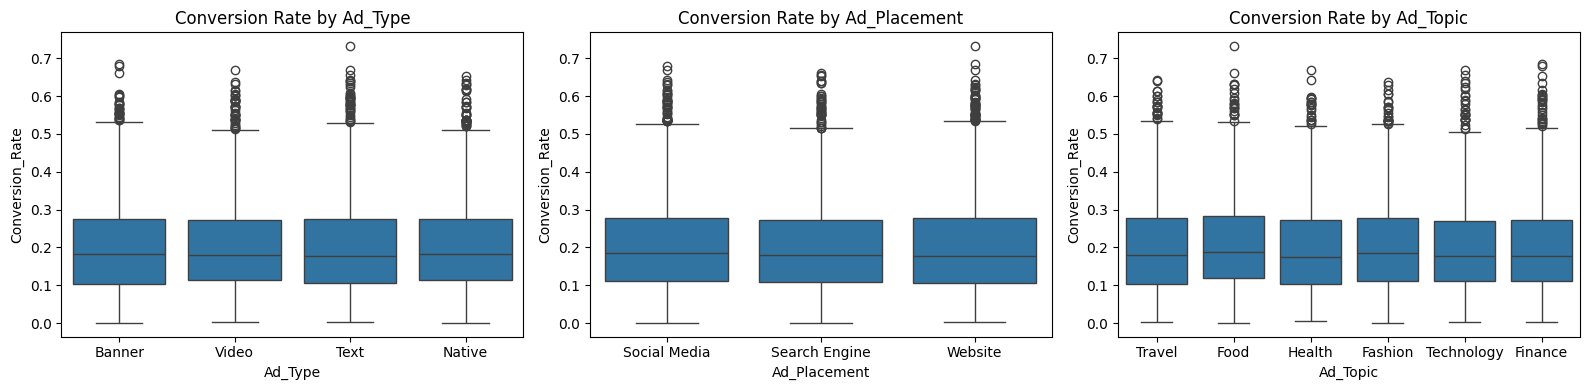

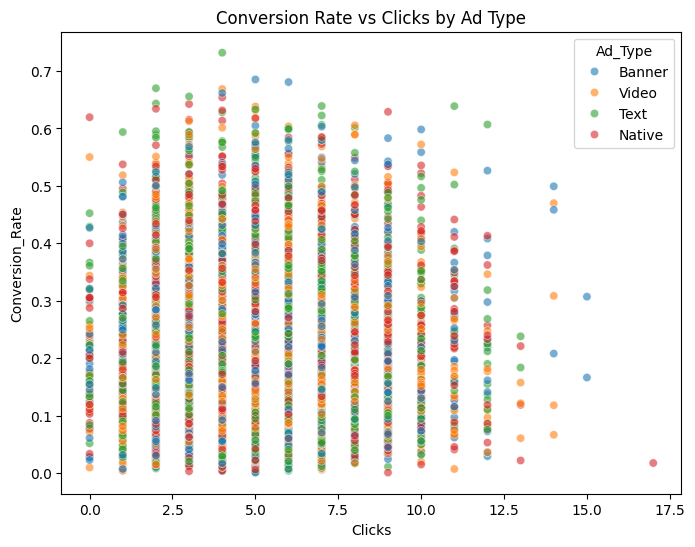

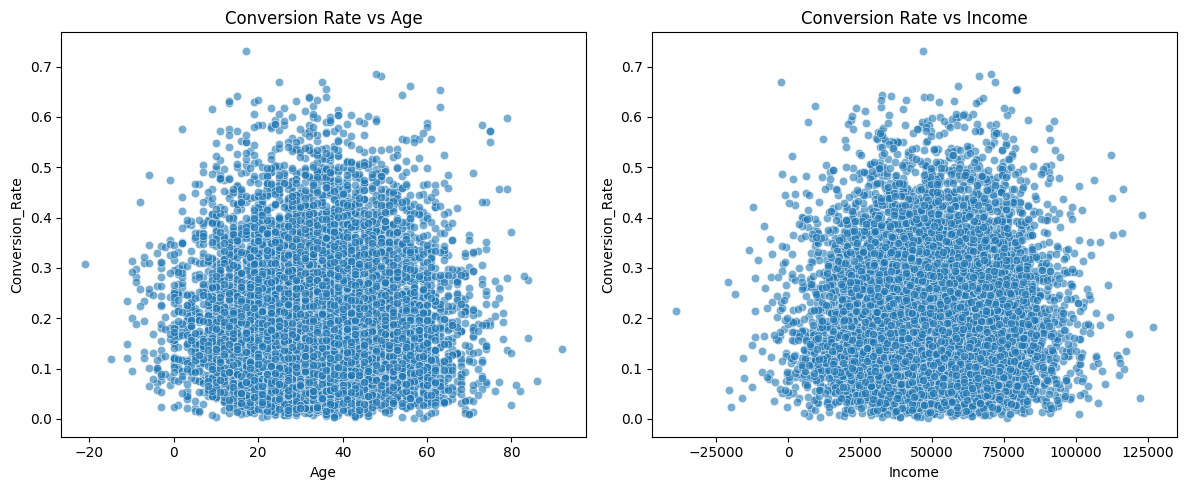

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame
# Make sure categorical variables are properly labeled
categorical_cols = ['Ad_Type', 'Ad_Placement', 'Ad_Topic']
for col in categorical_cols:
    df[col] = df[col].astype(str)

# 1. Boxplots: Conversion Rate by Ad Characteristics
plt.figure(figsize=(16, 4))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=col, y='Conversion_Rate', data=df)
    plt.title(f'Conversion Rate by {col}')
plt.tight_layout()
plt.show()

# 2. Scatter plot: Conversion Rate vs Clicks, colored by Ad_Type
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Clicks', y='Conversion_Rate', hue='Ad_Type', data=df, alpha=0.6)
plt.title('Conversion Rate vs Clicks by Ad Type')
plt.show()

# 3. Scatter plots: Conversion Rate vs Age and Income
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Conversion_Rate', data=df, alpha=0.6)
plt.title('Conversion Rate vs Age')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Income', y='Conversion_Rate', data=df, alpha=0.6)
plt.title('Conversion Rate vs Income')
plt.tight_layout()
plt.show()


In [106]:
"""
Alternative Causal Inference Methods When IV Fails
No instrumental variables required!
"""

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')


class AlternativeCausalMethods:
    """
    Causal inference methods that don't require instruments
    """
    
    def __init__(self, data):
        self.data = data.copy()
        self.propensity_scores = None
        self.matched_data = None
        
    # =========================================================================
    # METHOD 1: PROPENSITY SCORE MATCHING
    # =========================================================================
    
    def propensity_score_matching(self, treatment_var='Clicks', 
                                  outcome_var='Conversion_Rate',
                                  threshold=None,
                                  n_neighbors=1,
                                  caliper=0.1):
        """
        Propensity Score Matching: Match treated and control units based on 
        probability of treatment.
        
        Good when: You have observable confounders but no valid instrument
        
        Parameters:
        -----------
        treatment_var : str
            Variable to discretize into treatment (if continuous)
        outcome_var : str
            Outcome variable
        threshold : float
            Threshold to binarize treatment (if None, use median)
        n_neighbors : int
            Number of matches per treated unit
        caliper : float
            Maximum propensity score distance for matching
        """
        print("\n" + "="*70)
        print("METHOD 1: PROPENSITY SCORE MATCHING")
        print("="*70)
        
        # Binarize treatment if needed
        if threshold is None:
            threshold = self.data[treatment_var].median()
        
        self.data['Treatment'] = (self.data[treatment_var] > threshold).astype(int)
        
        print(f"\nTreatment definition: {treatment_var} > {threshold:.4f}")
        print(f"Treated units: {self.data['Treatment'].sum()}")
        print(f"Control units: {(1 - self.data['Treatment']).sum()}")
        
        # Define covariates (everything except treatment and outcome)
        exclude_cols = [treatment_var, outcome_var, 'Treatment', 'Click_Time']
        covariate_cols = [c for c in self.data.columns 
                         if c not in exclude_cols and self.data[c].dtype in ['int64', 'float64']]
        
        print(f"\nCovariates used: {len(covariate_cols)}")
        
        # Estimate propensity scores
        X = self.data[covariate_cols].fillna(self.data[covariate_cols].median())
        y = self.data['Treatment']
        
        # Use logistic regression for propensity scores
        ps_model = LogisticRegression(max_iter=1000, random_state=42)
        ps_model.fit(X, y)
        
        self.data['propensity_score'] = ps_model.predict_proba(X)[:, 1]
        self.propensity_scores = self.data['propensity_score']
        
        print(f"\nPropensity score range: [{self.propensity_scores.min():.4f}, "
              f"{self.propensity_scores.max():.4f}]")
        
        # Check overlap (common support)
        treated_ps = self.data[self.data['Treatment'] == 1]['propensity_score']
        control_ps = self.data[self.data['Treatment'] == 0]['propensity_score']
        
        overlap_min = max(treated_ps.min(), control_ps.min())
        overlap_max = min(treated_ps.max(), control_ps.max())
        
        print(f"Common support region: [{overlap_min:.4f}, {overlap_max:.4f}]")
        
        # Perform matching
        treated_indices = self.data[self.data['Treatment'] == 1].index
        control_indices = self.data[self.data['Treatment'] == 0].index
        
        treated_ps_values = self.data.loc[treated_indices, 'propensity_score'].values.reshape(-1, 1)
        control_ps_values = self.data.loc[control_indices, 'propensity_score'].values.reshape(-1, 1)
        
        # Find nearest neighbors
        nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
        nn.fit(control_ps_values)
        
        distances, indices = nn.kneighbors(treated_ps_values)
        
        # Apply caliper
        matched_pairs = []
        for i, (treated_idx, dist_array, match_indices) in enumerate(zip(treated_indices, distances, indices)):
            for dist, match_idx in zip(dist_array, match_indices):
                if dist <= caliper:
                    control_idx = control_indices[match_idx]
                    matched_pairs.append({
                        'treated_idx': treated_idx,
                        'control_idx': control_idx,
                        'distance': dist
                    })
        
        print(f"\nMatching results:")
        print(f"  Treated units matched: {len(set([p['treated_idx'] for p in matched_pairs]))}")
        print(f"  Total matched pairs: {len(matched_pairs)}")
        
        # Calculate treatment effect on matched sample
        if len(matched_pairs) > 0:
            treated_outcomes = []
            control_outcomes = []
            
            for pair in matched_pairs:
                treated_outcomes.append(self.data.loc[pair['treated_idx'], outcome_var])
                control_outcomes.append(self.data.loc[pair['control_idx'], outcome_var])
            
            ate = np.mean(treated_outcomes) - np.mean(control_outcomes)
            
            # T-test for significance
            t_stat, p_val = ttest_ind(treated_outcomes, control_outcomes)
            
            # Standard error
            se = np.sqrt(np.var(treated_outcomes)/len(treated_outcomes) + 
                        np.var(control_outcomes)/len(control_outcomes))
            
            print(f"\n{'='*70}")
            print(f"AVERAGE TREATMENT EFFECT (ATE)")
            print(f"{'='*70}")
            print(f"Effect size: {ate:.6f}")
            print(f"Standard error: {se:.6f}")
            print(f"95% CI: [{ate - 1.96*se:.6f}, {ate + 1.96*se:.6f}]")
            print(f"T-statistic: {t_stat:.4f}")
            print(f"P-value: {p_val:.4f}")
            print(f"Status: {'✓ Significant' if p_val < 0.05 else '✗ Not significant'}")
            
            return {
                'ate': ate,
                'se': se,
                'p_value': p_val,
                'n_matched': len(matched_pairs)
            }
        else:
            print("\n✗ No matches found within caliper distance")
            return None
    
    # =========================================================================
    # METHOD 2: INVERSE PROBABILITY WEIGHTING (IPW)
    # =========================================================================
    
    def inverse_probability_weighting(self, treatment_var='Clicks',
                                     outcome_var='Conversion_Rate',
                                     threshold=None):
        """
        Inverse Probability Weighting: Weight observations by inverse of 
        propensity to be treated.
        
        Good when: You want to use all data (not just matches)
        
        Less efficient than matching but uses full sample
        """
        print("\n" + "="*70)
        print("METHOD 2: INVERSE PROBABILITY WEIGHTING (IPW)")
        print("="*70)
        
        # Binarize treatment if needed
        if threshold is None:
            threshold = self.data[treatment_var].median()
        
        self.data['Treatment'] = (self.data[treatment_var] > threshold).astype(int)
        
        # Get propensity scores if not already estimated
        if self.propensity_scores is None:
            exclude_cols = [treatment_var, outcome_var, 'Treatment', 'Click_Time']
            covariate_cols = [c for c in self.data.columns 
                             if c not in exclude_cols and self.data[c].dtype in ['int64', 'float64']]
            
            X = self.data[covariate_cols].fillna(self.data[covariate_cols].median())
            y = self.data['Treatment']
            
            ps_model = LogisticRegression(max_iter=1000, random_state=42)
            ps_model.fit(X, y)
            self.data['propensity_score'] = ps_model.predict_proba(X)[:, 1]
        
        # Calculate IPW weights
        # For treated: 1 / propensity_score
        # For control: 1 / (1 - propensity_score)
        
        # Clip propensity scores to avoid extreme weights
        ps_clipped = self.data['propensity_score'].clip(0.01, 0.99)
        
        self.data['ipw_weight'] = np.where(
            self.data['Treatment'] == 1,
            1 / ps_clipped,
            1 / (1 - ps_clipped)
        )
        
        # Normalize weights
        treated_sum = self.data[self.data['Treatment'] == 1]['ipw_weight'].sum()
        control_sum = self.data[self.data['Treatment'] == 0]['ipw_weight'].sum()
        
        self.data['ipw_weight_norm'] = np.where(
            self.data['Treatment'] == 1,
            self.data['ipw_weight'] / treated_sum * self.data['Treatment'].sum(),
            self.data['ipw_weight'] / control_sum * (1 - self.data['Treatment']).sum()
        )
        
        print(f"\nWeight statistics:")
        print(f"  Mean weight: {self.data['ipw_weight'].mean():.4f}")
        print(f"  Max weight: {self.data['ipw_weight'].max():.4f}")
        print(f"  Min weight: {self.data['ipw_weight'].min():.4f}")
        
        # Calculate weighted treatment effect
        treated_weighted_mean = np.average(
            self.data[self.data['Treatment'] == 1][outcome_var],
            weights=self.data[self.data['Treatment'] == 1]['ipw_weight_norm']
        )
        
        control_weighted_mean = np.average(
            self.data[self.data['Treatment'] == 0][outcome_var],
            weights=self.data[self.data['Treatment'] == 0]['ipw_weight_norm']
        )
        
        ate = treated_weighted_mean - control_weighted_mean
        
        # Bootstrap standard errors
        n_bootstrap = 500
        boot_ates = []
        
        for _ in range(n_bootstrap):
            boot_idx = np.random.choice(len(self.data), size=len(self.data), replace=True)
            boot_data = self.data.iloc[boot_idx]
            
            treated_boot = np.average(
                boot_data[boot_data['Treatment'] == 1][outcome_var],
                weights=boot_data[boot_data['Treatment'] == 1]['ipw_weight_norm']
            )
            control_boot = np.average(
                boot_data[boot_data['Treatment'] == 0][outcome_var],
                weights=boot_data[boot_data['Treatment'] == 0]['ipw_weight_norm']
            )
            boot_ates.append(treated_boot - control_boot)
        
        se = np.std(boot_ates)
        
        print(f"\n{'='*70}")
        print(f"AVERAGE TREATMENT EFFECT (IPW)")
        print(f"{'='*70}")
        print(f"Effect size: {ate:.6f}")
        print(f"Standard error (bootstrapped): {se:.6f}")
        print(f"95% CI: [{ate - 1.96*se:.6f}, {ate + 1.96*se:.6f}]")
        
        return {
            'ate': ate,
            'se': se,
            'ci_lower': ate - 1.96*se,
            'ci_upper': ate + 1.96*se
        }
    
    # =========================================================================
    # METHOD 3: REGRESSION DISCONTINUITY DESIGN (RDD)
    # =========================================================================
    
    def regression_discontinuity(self, running_var, threshold, 
                                outcome_var='Conversion_Rate',
                                bandwidth=None):
        """
        Regression Discontinuity Design: Exploit discontinuous treatment assignment
        
        Good when: Treatment is assigned based on a threshold (e.g., Income > $50k)
        
        Example: Ads only shown to users with CTR > 0.05
        """
        print("\n" + "="*70)
        print("METHOD 3: REGRESSION DISCONTINUITY DESIGN")
        print("="*70)
        
        if running_var not in self.data.columns:
            print(f"✗ Running variable '{running_var}' not found")
            return None
        
        # Create treatment indicator
        self.data['Treatment_RDD'] = (self.data[running_var] > threshold).astype(int)
        
        # Center running variable at threshold
        self.data['running_centered'] = self.data[running_var] - threshold
        
        # Automatic bandwidth selection (if not provided)
        if bandwidth is None:
            bandwidth = self.data['running_centered'].abs().quantile(0.5)
        
        print(f"\nRDD Setup:")
        print(f"  Running variable: {running_var}")
        print(f"  Threshold: {threshold:.4f}")
        print(f"  Bandwidth: {bandwidth:.4f}")
        print(f"  Units just below threshold: {((self.data[running_var] >= threshold - bandwidth) & (self.data[running_var] < threshold)).sum()}")
        print(f"  Units just above threshold: {((self.data[running_var] >= threshold) & (self.data[running_var] <= threshold + bandwidth)).sum()}")
        
        # Restrict to bandwidth
        rdd_data = self.data[
            (self.data['running_centered'].abs() <= bandwidth)
        ].copy()
        
        if len(rdd_data) < 50:
            print(f"\n⚠ Warning: Only {len(rdd_data)} observations within bandwidth")
            print("  Consider increasing bandwidth or using different method")
            return None
        
        # Local linear regression
        X = sm.add_constant(pd.DataFrame({
            'Treatment': rdd_data['Treatment_RDD'],
            'running': rdd_data['running_centered'],
            'running_x_treatment': rdd_data['running_centered'] * rdd_data['Treatment_RDD']
        }))
        
        y = rdd_data[outcome_var]
        
        model = sm.OLS(y, X).fit()
        
        # Treatment effect is coefficient on Treatment dummy
        ate = model.params['Treatment']
        se = model.bse['Treatment']
        p_val = model.pvalues['Treatment']
        
        print(f"\n{'='*70}")
        print(f"REGRESSION DISCONTINUITY ESTIMATE")
        print(f"{'='*70}")
        print(f"Effect size: {ate:.6f}")
        print(f"Standard error: {se:.6f}")
        print(f"95% CI: [{ate - 1.96*se:.6f}, {ate + 1.96*se:.6f}]")
        print(f"P-value: {p_val:.4f}")
        print(f"Status: {'✓ Significant' if p_val < 0.05 else '✗ Not significant'}")
        
        print(f"\nFull regression results:")
        print(model.summary().tables[1])
        
        return {
            'ate': ate,
            'se': se,
            'p_value': p_val,
            'n_bandwidth': len(rdd_data)
        }
    
    # =========================================================================
    # METHOD 4: DOUBLY ROBUST ESTIMATION
    # =========================================================================
    
    def doubly_robust_estimation(self, treatment_var='Clicks',
                                outcome_var='Conversion_Rate',
                                threshold=None):
        """
        Doubly Robust Estimation: Combines propensity score and outcome regression
        
        Good when: You want protection against misspecification
        
        Works if EITHER propensity or outcome model is correct
        """
        print("\n" + "="*70)
        print("METHOD 4: DOUBLY ROBUST ESTIMATION")
        print("="*70)
        
        # Binarize treatment
        if threshold is None:
            threshold = self.data[treatment_var].median()
        
        self.data['Treatment'] = (self.data[treatment_var] > threshold).astype(int)
        
        # Define covariates
        exclude_cols = [treatment_var, outcome_var, 'Treatment', 'Click_Time']
        covariate_cols = [c for c in self.data.columns 
                         if c not in exclude_cols and self.data[c].dtype in ['int64', 'float64']]
        
        X = self.data[covariate_cols].fillna(self.data[covariate_cols].median())
        
        print(f"\nEstimating propensity scores...")
        # Step 1: Estimate propensity scores
        ps_model = LogisticRegression(max_iter=1000, random_state=42)
        ps_model.fit(X, self.data['Treatment'])
        ps = ps_model.predict_proba(X)[:, 1].clip(0.01, 0.99)
        
        print(f"Estimating outcome models...")
        # Step 2: Estimate outcome models for treated and control
        # Treated outcome model
        treated_data = self.data[self.data['Treatment'] == 1]
        X_treated = X[self.data['Treatment'] == 1]
        y_treated = treated_data[outcome_var]
        
        outcome_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
        outcome_model_1.fit(X_treated, y_treated)
        mu1 = outcome_model_1.predict(X)
        
        # Control outcome model
        control_data = self.data[self.data['Treatment'] == 0]
        X_control = X[self.data['Treatment'] == 0]
        y_control = control_data[outcome_var]
        
        outcome_model_0 = RandomForestRegressor(n_estimators=100, random_state=42)
        outcome_model_0.fit(X_control, y_control)
        mu0 = outcome_model_0.predict(X)
        
        # Step 3: Doubly robust estimation
        W = self.data['Treatment'].values
        Y = self.data[outcome_var].values
        
        # DR estimator
        dr_treated = mu1 + (W / ps) * (Y - mu1)
        dr_control = mu0 + ((1 - W) / (1 - ps)) * (Y - mu0)
        
        ate = np.mean(dr_treated - dr_control)
        
        # Bootstrap standard errors
        n_bootstrap = 500
        boot_ates = []
        
        for _ in range(n_bootstrap):
            boot_idx = np.random.choice(len(self.data), size=len(self.data), replace=True)
            dr_treated_boot = dr_treated[boot_idx]
            dr_control_boot = dr_control[boot_idx]
            boot_ates.append(np.mean(dr_treated_boot - dr_control_boot))
        
        se = np.std(boot_ates)
        
        print(f"\n{'='*70}")
        print(f"DOUBLY ROBUST ESTIMATE")
        print(f"{'='*70}")
        print(f"Effect size: {ate:.6f}")
        print(f"Standard error (bootstrapped): {se:.6f}")
        print(f"95% CI: [{ate - 1.96*se:.6f}, {ate + 1.96*se:.6f}]")
        
        print(f"\n✓ Doubly robust: Valid if EITHER propensity or outcome model is correct")
        
        return {
            'ate': ate,
            'se': se,
            'ci_lower': ate - 1.96*se,
            'ci_upper': ate + 1.96*se
        }


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Load data
    df = pd.read_csv('../datasets/project/Dataset_Ads.csv')
    
    # Initialize
    causal = AlternativeCausalMethods(df)
    
    print("\n" + "="*70)
    print("ALTERNATIVE CAUSAL INFERENCE METHODS DEMONSTRATION")
    print("="*70)
    
    # Method 1: Propensity Score Matching
    print("\n\n" + "🎯 Running Propensity Score Matching...")
    psm_results = causal.propensity_score_matching(
        treatment_var='Clicks',
        outcome_var='Conversion_Rate',
        threshold=None,  # Use median
        caliper=0.1
    )
    
    # Method 2: Inverse Probability Weighting
    print("\n\n" + "⚖️ Running Inverse Probability Weighting...")
    ipw_results = causal.inverse_probability_weighting(
        treatment_var='Clicks',
        outcome_var='Conversion_Rate'
    )
    
    # Method 3: Regression Discontinuity (if applicable)
    print("\n\n" + "📊 Running Regression Discontinuity...")
    print("(Assuming ads are only shown to users with Income > 50000)")
    rdd_results = causal.regression_discontinuity(
        running_var='Income',
        threshold=50000,
        outcome_var='Conversion_Rate'
    )
    
    # Method 4: Doubly Robust
    print("\n\n" + "🛡️ Running Doubly Robust Estimation...")
    dr_results = causal.doubly_robust_estimation(
        treatment_var='Clicks',
        outcome_var='Conversion_Rate'
    )
    
    print("\n\n" + "="*70)
    print("ALL METHODS COMPLETE")
    print("="*70)


ALTERNATIVE CAUSAL INFERENCE METHODS DEMONSTRATION


🎯 Running Propensity Score Matching...

METHOD 1: PROPENSITY SCORE MATCHING

Treatment definition: Clicks > 5.0000
Treated units: 3889
Control units: 6111

Covariates used: 3

Propensity score range: [0.3629, 0.4140]
Common support region: [0.3640, 0.4140]

Matching results:
  Treated units matched: 3889
  Total matched pairs: 3889

AVERAGE TREATMENT EFFECT (ATE)
Effect size: -0.000466
Standard error: 0.002755
95% CI: [-0.005865, 0.004934]
T-statistic: -0.1690
P-value: 0.8658
Status: ✗ Not significant


⚖️ Running Inverse Probability Weighting...

METHOD 2: INVERSE PROBABILITY WEIGHTING (IPW)

Weight statistics:
  Mean weight: 2.0000
  Max weight: 2.7472
  Min weight: 1.5697

AVERAGE TREATMENT EFFECT (IPW)
Effect size: 0.002313
Standard error (bootstrapped): 0.002418
95% CI: [-0.002425, 0.007052]


📊 Running Regression Discontinuity...
(Assuming ads are only shown to users with Income > 50000)

METHOD 3: REGRESSION DISCONTINUITY DES